In [27]:
import tensorflow as tf
import numpy as np
import collections
import tensorflow as tf
import numpy as np
import utils
import vgg19
import os
from time import strftime
import ntpath
from os import listdir
from os.path import isfile, join

from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import argparse

In [2]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:

class StyleTransfer:

    def __init__(self, content_layer_ids, style_layer_ids, init_image, content_image,
                 style_image, session, net, num_iter, loss_ratio, content_loss_norm_type):

        self.net = net
        self.sess = session

        # sort layers info
        self.CONTENT_LAYERS = collections.OrderedDict(sorted(content_layer_ids.items()))
        self.STYLE_LAYERS = collections.OrderedDict(sorted(style_layer_ids.items()))

        # preprocess input images
        self.p0 = np.float32(self.net.preprocess(content_image))
        self.a0 = np.float32(self.net.preprocess(style_image))
        self.x0 = np.float32(self.net.preprocess(init_image))

        # parameters for optimization
        self.content_loss_norm_type = content_loss_norm_type
        self.num_iter = num_iter
        self.loss_ratio = loss_ratio

        # build graph for style transfer
        self._build_graph()

    def _build_graph(self):

        """ prepare data """
        # this is what must be trained
        self.x = tf.Variable(self.x0, trainable=True, dtype=tf.float32)

        # graph input
        self.p = tf.placeholder(tf.float32, shape=self.p0.shape, name='content')
        self.a = tf.placeholder(tf.float32, shape=self.a0.shape, name='style')

        # get content-layer-feature for content loss
        content_layers = self.net.feed_forward(self.p, scope='content')
        self.Ps = {}
        for id in self.CONTENT_LAYERS:
            self.Ps[id] = content_layers[id]

        # get style-layer-feature for style loss
        style_layers = self.net.feed_forward(self.a, scope='style')
        self.As = {}
        for id in self.STYLE_LAYERS:
            self.As[id] = self._gram_matrix(style_layers[id])
        
        # get layer-values for x
        self.Fs = self.net.feed_forward(self.x, scope='mixed')

        """ compute loss """
        L_content = 0
        L_style = 0
        for id in self.Fs:
            if id in self.CONTENT_LAYERS:
                ## content loss ##

                F = self.Fs[id]            # content feature of x
                P = self.Ps[id]            # content feature of p

                _, h, w, d = F.get_shape() # first return value is batch size (must be one)
                N = h.value*w.value        # product of width and height
                M = d.value                # number of filters

                w = self.CONTENT_LAYERS[id]# weight for this layer

                # You may choose different normalization constant
                if self.content_loss_norm_type==1:
                    L_content += w * tf.reduce_sum(tf.pow((F-P), 2)) / 2 # original paper
                elif self.content_loss_norm_type == 2:
                    L_content += w * tf.reduce_sum(tf.pow((F-P), 2)) / (N*M) #artistic style transfer for videos
                elif self.content_loss_norm_type == 3: # this is from https://github.com/cysmith/neural-style-tf/blob/master/neural_style.py
                    L_content += w * (1. / (2. * np.sqrt(M) * np.sqrt(N))) * tf.reduce_sum(tf.pow((F - P), 2))

            elif id in self.STYLE_LAYERS:
                ## style loss ##

                F = self.Fs[id]

                _, h, w, d = F.get_shape()  # first return value is batch size (must be one)
                N = h.value * w.value       # product of width and height
                M = d.value                 # number of filters

                w = self.STYLE_LAYERS[id]   # weight for this layer

                G = self._gram_matrix(F)    # style feature of x
                A = self.As[id]             # style feature of a

                L_style += w * (1. / (4 * N ** 2 * M ** 2)) * tf.reduce_sum(tf.pow((G-A), 2))


        # fix beta as 1
        alpha = self.loss_ratio
        beta = 1

        self.L_content = L_content
        self.L_style = L_style
        self.L_total = alpha*L_content + beta*L_style

    def update(self):
        """ define optimizer L-BFGS """
        # this call back function is called every after loss is updated
        global _iter
        _iter = 0
        def callback(tl, cl, sl):
            global _iter
            print('iter : %4d, ' % _iter, 'L_total : %g, L_content : %g, L_style : %g' % (tl, cl, sl))
            _iter += 1

        optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.L_total, method='L-BFGS-B', options={'maxiter': self.num_iter})

        """ session run """
        # initialize variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        # optmization
        optimizer.minimize(self.sess,feed_dict={self.a:self.a0, self.p:self.p0},
                           fetches=[self.L_total, self.L_content, self.L_style], loss_callback=callback)

        """ get final result """
        final_image = self.sess.run(self.x)

        # ensure the image has valid pixel-values between 0 and 255
        final_image = np.clip(self.net.undo_preprocess(final_image), 0.0, 255.0)

        return final_image

    def _gram_matrix(self, tensor):

        shape = tensor.get_shape()

        # Get the number of feature channels for the input tensor,
        # which is assumed to be from a convolutional layer with 4-dim.
        num_channels = int(shape[3])

        # Reshape the tensor so it is a 2-dim matrix. This essentially
        # flattens the contents of each feature-channel.
        matrix = tf.reshape(tensor, shape=[-1, num_channels])

        # Calculate the Gram-matrix as the matrix-product of
        # the 2-dim matrix with itself. This calculates the
        # dot-products of all combinations of the feature-channels.
        gram = tf.matmul(tf.transpose(matrix), matrix)

        return gram

In [25]:
def get_output_filepath(content, style):
    content_name = ntpath.basename(content).split(".")[0]
    style_name = ntpath.basename(style).split(".")[0]
    return "results/{}_{}_{}".format(content_name, style_name, strftime("%Y-%m-%d-%H:%M")+'.jpg')
get_output_filepath(content, style)


'results/chapel_japan2_2018-04-07-22:23.jpg'

In [14]:
model_path='pre_trained_model'    #The directory where the pre-trained model was saved'
content='images/chapel.jpg'     #File path of content image (notation in the paper : p)
style='images/japan2.jpg'   #File path of style image (notation in the paper : a)
output='results/'+strftime("%Y-%m-%d-%H:%M")+'.jpg'  #File path of output image
loss_ratio=1e-3                   #Weight of content-loss relative to style-loss
content_layers=['conv4_2']        #VGG19 layers used for content loss
style_layers=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'] #VGG19 layers used for style loss
content_layer_weights=[1.0]       #Content loss for each content is multiplied by corresponding weight
style_layer_weights=[.2,.2,.2,.2,.2] #Style loss for each content is multiplied by corresponding weight
initial_type='content'            #choices = ['random','content','style'], The initial image for optimization (notation in the paper : x)
max_size=512                      #The maximum width or height of input images
content_loss_norm_type=3          #choices=[1,2,3],  Different types of normalization for content loss
num_iter=600                     #The number of iterations to run



try:
    assert len(content_layers) == len(content_layer_weights)
except:
    raise ('content layer info and weight info must be matched')
try:
    assert len(style_layers) == len(style_layer_weights)
except:
    raise('style layer info and weight info must be matched')

try:
    assert max_size > 100
except:
    raise ('Too small size')


model_file_path = model_path + '/' + vgg19.MODEL_FILE_NAME
try:
    assert os.path.exists(model_file_path)
except:
    raise Exception('There is no %s'%model_file_path)

try:
    size_in_KB = os.path.getsize(model_file_path)
    assert abs(size_in_KB - 534904783) < 10
except:
    print('check file size of \'imagenet-vgg-verydeep-19.mat\'')
    print('there are some files with the same name')
    print('pre_trained_model used here can be downloaded from bellow')
    print('http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat')
    raise()

try:
    assert os.path.exists(content)
except:
    raise('There is no %s'%content)

try:
    assert os.path.exists(style)
except:
    raise('There is no %s' % style)


"""add one dim for batch"""
# VGG19 requires input dimension to be (batch, height, width, channel)
def add_one_dim(image):
    shape = (1,) + image.shape
    return np.reshape(image, shape)

In [ ]:

# initiate VGG19 model
model_file_path = model_path + '/' + vgg19.MODEL_FILE_NAME
vgg_net = vgg19.VGG19(model_file_path)

style_dir = 'images/style'
content_dir = 'images/content'
style_files = [join(style_dir, f) for f in listdir(style_dir) if isfile(join(style_dir, f))] 
content_files = [join(content_dir, f) for f in listdir(content_dir) if isfile(join(content_dir, f))] 

for style in style_files:
    for content in content_files:
        print ("Starting to process {} and {}".format(style,content))
        # load content image and style image
        content_image = utils.load_image(content, max_size=max_size)
        style_image = utils.load_image(style, shape=(content_image.shape[1],content_image.shape[0]))

        # initial guess for output
        if initial_type == 'content':
            init_image = content_image
        elif initial_type == 'style':
            init_image = style_image
        elif initial_type == 'random':
            init_image = np.random.normal(size=content_image.shape, scale=np.std(content_image))

        # check input images for style-transfer
        # utils.plot_images(content_image,style_image, init_image)

        # create a map for content layers info
        CONTENT_LAYERS = {}
        for layer, weight in zip(content_layers,content_layer_weights):
            CONTENT_LAYERS[layer] = weight

        # create a map for style layers info
        STYLE_LAYERS = {}
        for layer, weight in zip(style_layers, style_layer_weights):
            STYLE_LAYERS[layer] = weight
        with tf.Graph().as_default():
            # open session
            sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
            # build the graph
            st = StyleTransfer(session = sess,
                      content_layer_ids = CONTENT_LAYERS,
                      style_layer_ids = STYLE_LAYERS,
                      init_image = add_one_dim(init_image),
                      content_image = add_one_dim(content_image),
                      style_image = add_one_dim(style_image),
                      net = vgg_net,
                      num_iter = num_iter,
                      loss_ratio = loss_ratio,
                      content_loss_norm_type = content_loss_norm_type,
                      )
            # launch the graph in a session
            result_image = st.update()
            # close session
            sess.close()
        # remove batch dimension
        shape = result_image.shape
        result_image = np.reshape(result_image,shape[1:])
        # save result
        utils.save_image(result_image,get_output_filepath(content, style))
    

# utils.plot_images(content_image,style_image, result_image)

Starting to process images/style/HTB1uQ_NOVXXXXahaXXXq6xXFXXX5.jpg and images/content/20170901_204727.jpg
('iter :    0, ', 'L_total : 2.45508e+10, L_content : 0, L_style : 2.45508e+10')
('iter :    1, ', 'L_total : 2.45454e+10, L_content : 202.625, L_style : 2.45454e+10')
('iter :    2, ', 'L_total : 2.45238e+10, L_content : 5067.45, L_style : 2.45238e+10')
('iter :    3, ', 'L_total : 2.44372e+10, L_content : 89283, L_style : 2.44372e+10')
('iter :    4, ', 'L_total : 2.40896e+10, L_content : 1.42387e+06, L_style : 2.40896e+10')
('iter :    5, ', 'L_total : 2.2831e+10, L_content : 1.6086e+07, L_style : 2.2831e+10')
('iter :    6, ', 'L_total : 1.37341e+10, L_content : 3.45496e+08, L_style : 1.37338e+10')
('iter :    7, ', 'L_total : 1.05761e+10, L_content : 1.37297e+09, L_style : 1.05747e+10')
('iter :    8, ', 'L_total : 5.30191e+09, L_content : 9.48562e+08, L_style : 5.30097e+09')
('iter :    9, ', 'L_total : 4.25603e+09, L_content : 9.78591e+08, L_style : 4.25505e+09')
('iter :   

('iter :   91, ', 'L_total : 3.95957e+07, L_content : 1.80559e+09, L_style : 3.77901e+07')
('iter :   92, ', 'L_total : 3.91359e+07, L_content : 1.80622e+09, L_style : 3.73296e+07')
('iter :   93, ', 'L_total : 3.86968e+07, L_content : 1.80749e+09, L_style : 3.68893e+07')
('iter :   94, ', 'L_total : 3.80581e+07, L_content : 1.8125e+09, L_style : 3.62456e+07')
('iter :   95, ', 'L_total : 3.76748e+07, L_content : 1.81825e+09, L_style : 3.58565e+07')
('iter :   96, ', 'L_total : 3.73727e+07, L_content : 1.81947e+09, L_style : 3.55532e+07')
('iter :   97, ', 'L_total : 3.72127e+07, L_content : 1.82299e+09, L_style : 3.53897e+07')
('iter :   98, ', 'L_total : 3.68296e+07, L_content : 1.82161e+09, L_style : 3.5008e+07')
('iter :   99, ', 'L_total : 3.65073e+07, L_content : 1.82319e+09, L_style : 3.46841e+07')
('iter :  100, ', 'L_total : 3.60261e+07, L_content : 1.82618e+09, L_style : 3.41999e+07')
('iter :  101, ', 'L_total : 3.58831e+07, L_content : 1.83511e+09, L_style : 3.4048e+07')
('

('iter :  182, ', 'L_total : 2.04566e+07, L_content : 1.95594e+09, L_style : 1.85006e+07')
('iter :  183, ', 'L_total : 2.0397e+07, L_content : 1.95611e+09, L_style : 1.84408e+07')
('iter :  184, ', 'L_total : 2.02803e+07, L_content : 1.95704e+09, L_style : 1.83233e+07')
('iter :  185, ', 'L_total : 2.0133e+07, L_content : 1.95849e+09, L_style : 1.81745e+07')
('iter :  186, ', 'L_total : 2.00402e+07, L_content : 1.95901e+09, L_style : 1.80812e+07')
('iter :  187, ', 'L_total : 1.99641e+07, L_content : 1.95973e+09, L_style : 1.80044e+07')
('iter :  188, ', 'L_total : 1.98547e+07, L_content : 1.96009e+09, L_style : 1.78946e+07')
('iter :  189, ', 'L_total : 1.97894e+07, L_content : 1.96104e+09, L_style : 1.78283e+07')
('iter :  190, ', 'L_total : 1.96731e+07, L_content : 1.9608e+09, L_style : 1.77123e+07')
('iter :  191, ', 'L_total : 1.95858e+07, L_content : 1.96116e+09, L_style : 1.76246e+07')
('iter :  192, ', 'L_total : 1.95109e+07, L_content : 1.96181e+09, L_style : 1.75491e+07')
('

('iter :  273, ', 'L_total : 1.42976e+07, L_content : 2.01012e+09, L_style : 1.22874e+07')
('iter :  274, ', 'L_total : 1.43066e+07, L_content : 2.01091e+09, L_style : 1.22957e+07')
('iter :  275, ', 'L_total : 1.42658e+07, L_content : 2.01049e+09, L_style : 1.22553e+07')
('iter :  276, ', 'L_total : 1.42183e+07, L_content : 2.01161e+09, L_style : 1.22066e+07')
('iter :  277, ', 'L_total : 1.41619e+07, L_content : 2.01269e+09, L_style : 1.21492e+07')
('iter :  278, ', 'L_total : 1.41068e+07, L_content : 2.01341e+09, L_style : 1.20933e+07')
('iter :  279, ', 'L_total : 1.40526e+07, L_content : 2.01497e+09, L_style : 1.20377e+07')
('iter :  280, ', 'L_total : 1.40099e+07, L_content : 2.01495e+09, L_style : 1.19949e+07')
('iter :  281, ', 'L_total : 1.3966e+07, L_content : 2.01546e+09, L_style : 1.19505e+07')
('iter :  282, ', 'L_total : 1.3929e+07, L_content : 2.01556e+09, L_style : 1.19134e+07')
('iter :  283, ', 'L_total : 1.39066e+07, L_content : 2.01578e+09, L_style : 1.18908e+07')
(

('iter :  364, ', 'L_total : 1.10696e+07, L_content : 2.05133e+09, L_style : 9.01832e+06')
('iter :  365, ', 'L_total : 1.1042e+07, L_content : 2.05192e+09, L_style : 8.9901e+06')
('iter :  366, ', 'L_total : 1.1037e+07, L_content : 2.05157e+09, L_style : 8.98539e+06')
('iter :  367, ', 'L_total : 1.09998e+07, L_content : 2.0517e+09, L_style : 8.94812e+06')
('iter :  368, ', 'L_total : 1.09864e+07, L_content : 2.05184e+09, L_style : 8.9346e+06')
('iter :  369, ', 'L_total : 1.0961e+07, L_content : 2.05217e+09, L_style : 8.90887e+06')
('iter :  370, ', 'L_total : 1.09245e+07, L_content : 2.05285e+09, L_style : 8.87164e+06')
('iter :  371, ', 'L_total : 1.09266e+07, L_content : 2.05298e+09, L_style : 8.87366e+06')
('iter :  372, ', 'L_total : 1.08998e+07, L_content : 2.05291e+09, L_style : 8.84691e+06')
('iter :  373, ', 'L_total : 1.08592e+07, L_content : 2.05365e+09, L_style : 8.8055e+06')
('iter :  374, ', 'L_total : 1.08253e+07, L_content : 2.05404e+09, L_style : 8.77121e+06')
('iter

('iter :  455, ', 'L_total : 9.28478e+06, L_content : 2.07565e+09, L_style : 7.20913e+06')
('iter :  456, ', 'L_total : 9.27406e+06, L_content : 2.07597e+09, L_style : 7.19809e+06')
('iter :  457, ', 'L_total : 9.26268e+06, L_content : 2.07596e+09, L_style : 7.18672e+06')
('iter :  458, ', 'L_total : 9.24773e+06, L_content : 2.07627e+09, L_style : 7.17147e+06')
('iter :  459, ', 'L_total : 9.2372e+06, L_content : 2.07629e+09, L_style : 7.16091e+06')
('iter :  460, ', 'L_total : 9.21963e+06, L_content : 2.07658e+09, L_style : 7.14306e+06')
('iter :  461, ', 'L_total : 9.19615e+06, L_content : 2.07644e+09, L_style : 7.11971e+06')
('iter :  462, ', 'L_total : 9.17872e+06, L_content : 2.07665e+09, L_style : 7.10207e+06')
('iter :  463, ', 'L_total : 9.16412e+06, L_content : 2.07636e+09, L_style : 7.08776e+06')
('iter :  464, ', 'L_total : 9.15856e+06, L_content : 2.07606e+09, L_style : 7.08251e+06')
('iter :  465, ', 'L_total : 9.14486e+06, L_content : 2.07624e+09, L_style : 7.06862e+06')


('iter :  547, ', 'L_total : 8.14502e+06, L_content : 2.0898e+09, L_style : 6.05521e+06')
('iter :  548, ', 'L_total : 8.13565e+06, L_content : 2.08974e+09, L_style : 6.04591e+06')
('iter :  549, ', 'L_total : 8.12642e+06, L_content : 2.08966e+09, L_style : 6.03675e+06')
('iter :  550, ', 'L_total : 8.12116e+06, L_content : 2.0902e+09, L_style : 6.03096e+06')
('iter :  551, ', 'L_total : 8.10769e+06, L_content : 2.09024e+09, L_style : 6.01745e+06')
('iter :  552, ', 'L_total : 8.09611e+06, L_content : 2.09058e+09, L_style : 6.00553e+06')
('iter :  553, ', 'L_total : 8.0865e+06, L_content : 2.09104e+09, L_style : 5.99546e+06')
('iter :  554, ', 'L_total : 8.0771e+06, L_content : 2.09147e+09, L_style : 5.98563e+06')
('iter :  555, ', 'L_total : 8.06585e+06, L_content : 2.09185e+09, L_style : 5.974e+06')
('iter :  556, ', 'L_total : 8.05618e+06, L_content : 2.09202e+09, L_style : 5.96416e+06')
('iter :  557, ', 'L_total : 8.04861e+06, L_content : 2.09178e+09, L_style : 5.95683e+06')
('ite

('iter :    8, ', 'L_total : 4.6022e+09, L_content : 1.19071e+09, L_style : 4.60101e+09')
('iter :    9, ', 'L_total : 3.05991e+09, L_content : 1.30702e+09, L_style : 3.0586e+09')
('iter :   10, ', 'L_total : 2.28697e+09, L_content : 1.41914e+09, L_style : 2.28555e+09')
('iter :   11, ', 'L_total : 1.76153e+09, L_content : 1.35364e+09, L_style : 1.76017e+09')
('iter :   12, ', 'L_total : 1.44268e+09, L_content : 1.42103e+09, L_style : 1.44125e+09')
('iter :   13, ', 'L_total : 1.10896e+09, L_content : 1.49709e+09, L_style : 1.10746e+09')
('iter :   14, ', 'L_total : 8.76872e+08, L_content : 1.54464e+09, L_style : 8.75327e+08')
('iter :   15, ', 'L_total : 7.49835e+08, L_content : 1.63976e+09, L_style : 7.48195e+08')
('iter :   16, ', 'L_total : 6.57648e+08, L_content : 1.60838e+09, L_style : 6.56039e+08')
('iter :   17, ', 'L_total : 6.06407e+08, L_content : 1.63294e+09, L_style : 6.04774e+08')
('iter :   18, ', 'L_total : 5.22123e+08, L_content : 1.68433e+09, L_style : 5.20439e+08')
(

('iter :   99, ', 'L_total : 4.4855e+07, L_content : 2.13868e+09, L_style : 4.27163e+07')
('iter :  100, ', 'L_total : 4.39723e+07, L_content : 2.14285e+09, L_style : 4.18294e+07')
('iter :  101, ', 'L_total : 4.32899e+07, L_content : 2.14169e+09, L_style : 4.11482e+07')
('iter :  102, ', 'L_total : 4.29233e+07, L_content : 2.14746e+09, L_style : 4.07758e+07')
('iter :  103, ', 'L_total : 4.24003e+07, L_content : 2.14677e+09, L_style : 4.02535e+07')
('iter :  104, ', 'L_total : 4.20374e+07, L_content : 2.14451e+09, L_style : 3.98929e+07')
('iter :  105, ', 'L_total : 4.16436e+07, L_content : 2.14658e+09, L_style : 3.9497e+07')
('iter :  106, ', 'L_total : 4.10148e+07, L_content : 2.15461e+09, L_style : 3.88602e+07')
('iter :  107, ', 'L_total : 4.03412e+07, L_content : 2.15633e+09, L_style : 3.81849e+07')
('iter :  108, ', 'L_total : 3.99844e+07, L_content : 2.15612e+09, L_style : 3.78283e+07')
('iter :  109, ', 'L_total : 3.95721e+07, L_content : 2.15739e+09, L_style : 3.74147e+07')
(

('iter :  190, ', 'L_total : 2.11214e+07, L_content : 2.25817e+09, L_style : 1.88632e+07')
('iter :  191, ', 'L_total : 2.10144e+07, L_content : 2.259e+09, L_style : 1.87554e+07')
('iter :  192, ', 'L_total : 2.09332e+07, L_content : 2.25971e+09, L_style : 1.86734e+07')
('iter :  193, ', 'L_total : 2.08148e+07, L_content : 2.26025e+09, L_style : 1.85546e+07')
('iter :  194, ', 'L_total : 2.07042e+07, L_content : 2.26092e+09, L_style : 1.84433e+07')
('iter :  195, ', 'L_total : 2.05825e+07, L_content : 2.26047e+09, L_style : 1.83221e+07')
('iter :  196, ', 'L_total : 2.05111e+07, L_content : 2.25973e+09, L_style : 1.82514e+07')
('iter :  197, ', 'L_total : 2.04230e+07, L_content : 2.26033e+09, L_style : 1.81627e+07')
('iter :  198, ', 'L_total : 2.03173e+07, L_content : 2.26021e+09, L_style : 1.80571e+07')
('iter :  199, ', 'L_total : 2.0204e+07, L_content : 2.26209e+09, L_style : 1.79419e+07')
('iter :  200, ', 'L_total : 2.01451e+07, L_content : 2.26283e+09, L_style : 1.78823e+07')
('

('iter :  281, ', 'L_total : 1.51251e+07, L_content : 2.3063e+09, L_style : 1.28188e+07')
('iter :  282, ', 'L_total : 1.50881e+07, L_content : 2.30613e+09, L_style : 1.2782e+07')
('iter :  283, ', 'L_total : 1.50467e+07, L_content : 2.30672e+09, L_style : 1.274e+07')
('iter :  284, ', 'L_total : 1.49926e+07, L_content : 2.30758e+09, L_style : 1.2685e+07')
('iter :  285, ', 'L_total : 1.49537e+07, L_content : 2.30805e+09, L_style : 1.26457e+07')
('iter :  286, ', 'L_total : 1.49022e+07, L_content : 2.30836e+09, L_style : 1.25939e+07')
('iter :  287, ', 'L_total : 1.48429e+07, L_content : 2.30826e+09, L_style : 1.25346e+07')
('iter :  288, ', 'L_total : 1.48568e+07, L_content : 2.30874e+09, L_style : 1.2548e+07')
('iter :  289, ', 'L_total : 1.48084e+07, L_content : 2.30854e+09, L_style : 1.24998e+07')
('iter :  290, ', 'L_total : 1.47743e+07, L_content : 2.30826e+09, L_style : 1.2466e+07')
('iter :  291, ', 'L_total : 1.47338e+07, L_content : 2.30852e+09, L_style : 1.24253e+07')
('iter

('iter :  373, ', 'L_total : 1.21008e+07, L_content : 2.33122e+09, L_style : 9.76962e+06')
('iter :  374, ', 'L_total : 1.21037e+07, L_content : 2.33275e+09, L_style : 9.77093e+06')
('iter :  375, ', 'L_total : 1.20861e+07, L_content : 2.33195e+09, L_style : 9.75415e+06')
('iter :  376, ', 'L_total : 1.2069e+07, L_content : 2.33172e+09, L_style : 9.73732e+06')
('iter :  377, ', 'L_total : 1.20497e+07, L_content : 2.33139e+09, L_style : 9.71828e+06')
('iter :  378, ', 'L_total : 1.20271e+07, L_content : 2.33147e+09, L_style : 9.69562e+06')
('iter :  379, ', 'L_total : 1.2005e+07, L_content : 2.33173e+09, L_style : 9.67327e+06')
('iter :  380, ', 'L_total : 1.19722e+07, L_content : 2.33216e+09, L_style : 9.64004e+06')
('iter :  381, ', 'L_total : 1.19699e+07, L_content : 2.33273e+09, L_style : 9.63715e+06')
('iter :  382, ', 'L_total : 1.1948e+07, L_content : 2.33244e+09, L_style : 9.61552e+06')
('iter :  383, ', 'L_total : 1.19131e+07, L_content : 2.33275e+09, L_style : 9.58037e+06')
('

('iter :  464, ', 'L_total : 1.03605e+07, L_content : 2.34639e+09, L_style : 8.01409e+06')
('iter :  465, ', 'L_total : 1.03465e+07, L_content : 2.34608e+09, L_style : 8.00044e+06')
('iter :  466, ', 'L_total : 1.03325e+07, L_content : 2.34612e+09, L_style : 7.98639e+06')
('iter :  467, ', 'L_total : 1.03174e+07, L_content : 2.34593e+09, L_style : 7.97143e+06')
('iter :  468, ', 'L_total : 1.02997e+07, L_content : 2.3459e+09, L_style : 7.95375e+06')
('iter :  469, ', 'L_total : 1.02806e+07, L_content : 2.3462e+09, L_style : 7.93437e+06')
('iter :  470, ', 'L_total : 1.02652e+07, L_content : 2.34654e+09, L_style : 7.91867e+06')
('iter :  471, ', 'L_total : 1.02497e+07, L_content : 2.34695e+09, L_style : 7.90277e+06')
('iter :  472, ', 'L_total : 1.02333e+07, L_content : 2.34716e+09, L_style : 7.88617e+06')
('iter :  473, ', 'L_total : 1.02126e+07, L_content : 2.3466e+09, L_style : 7.86599e+06')
('iter :  474, ', 'L_total : 1.01965e+07, L_content : 2.34694e+09, L_style : 7.84961e+06')
('

('iter :  555, ', 'L_total : 9.11707e+06, L_content : 2.35745e+09, L_style : 6.75962e+06')
('iter :  556, ', 'L_total : 9.10631e+06, L_content : 2.35785e+09, L_style : 6.74846e+06')
('iter :  557, ', 'L_total : 9.08324e+06, L_content : 2.35786e+09, L_style : 6.72537e+06')
('iter :  558, ', 'L_total : 9.07171e+06, L_content : 2.35792e+09, L_style : 6.71379e+06')
('iter :  559, ', 'L_total : 9.05869e+06, L_content : 2.35768e+09, L_style : 6.701e+06')
('iter :  560, ', 'L_total : 9.04826e+06, L_content : 2.35811e+09, L_style : 6.69015e+06')
('iter :  561, ', 'L_total : 9.04089e+06, L_content : 2.35826e+09, L_style : 6.68263e+06')
('iter :  562, ', 'L_total : 9.02396e+06, L_content : 2.35882e+09, L_style : 6.66514e+06')
('iter :  563, ', 'L_total : 9.01626e+06, L_content : 2.35843e+09, L_style : 6.65782e+06')
('iter :  564, ', 'L_total : 9.00297e+06, L_content : 2.35859e+09, L_style : 6.64439e+06')
('iter :  565, ', 'L_total : 9.0017e+06, L_content : 2.35894e+09, L_style : 6.64276e+06')
('

('iter :    6, ', 'L_total : 1.17641e+10, L_content : 3.1726e+08, L_style : 1.17637e+10')
('iter :    7, ', 'L_total : 8.09886e+09, L_content : 9.28637e+08, L_style : 8.09793e+09')
('iter :    8, ', 'L_total : 5.07772e+09, L_content : 7.73698e+08, L_style : 5.07695e+09')
('iter :    9, ', 'L_total : 4.15567e+09, L_content : 7.9496e+08, L_style : 4.15488e+09')
('iter :   10, ', 'L_total : 2.18813e+09, L_content : 9.45917e+08, L_style : 2.18718e+09')
('iter :   11, ', 'L_total : 1.32714e+09, L_content : 9.70451e+08, L_style : 1.32617e+09')
('iter :   12, ', 'L_total : 1.3567e+09, L_content : 1.05307e+09, L_style : 1.35565e+09')
('iter :   13, ', 'L_total : 1.09502e+09, L_content : 1.00335e+09, L_style : 1.09402e+09')
('iter :   14, ', 'L_total : 9.71698e+08, L_content : 1.02256e+09, L_style : 9.70675e+08')
('iter :   15, ', 'L_total : 7.98663e+08, L_content : 1.03967e+09, L_style : 7.97623e+08')
('iter :   16, ', 'L_total : 6.89762e+08, L_content : 1.11329e+09, L_style : 6.88648e+08')
('

('iter :   97, ', 'L_total : 5.28124e+07, L_content : 1.68995e+09, L_style : 5.11224e+07')
('iter :   98, ', 'L_total : 5.19922e+07, L_content : 1.69024e+09, L_style : 5.03019e+07')
('iter :   99, ', 'L_total : 5.17491e+07, L_content : 1.69937e+09, L_style : 5.00497e+07')
('iter :  100, ', 'L_total : 5.08262e+07, L_content : 1.69639e+09, L_style : 4.91298e+07')
('iter :  101, ', 'L_total : 5.05257e+07, L_content : 1.69823e+09, L_style : 4.88275e+07')
('iter :  102, ', 'L_total : 4.99757e+07, L_content : 1.70072e+09, L_style : 4.8275e+07')
('iter :  103, ', 'L_total : 4.91563e+07, L_content : 1.70722e+09, L_style : 4.74491e+07')
('iter :  104, ', 'L_total : 4.85093e+07, L_content : 1.71755e+09, L_style : 4.67918e+07')
('iter :  105, ', 'L_total : 4.77787e+07, L_content : 1.71679e+09, L_style : 4.60619e+07')
('iter :  106, ', 'L_total : 4.74309e+07, L_content : 1.71709e+09, L_style : 4.57139e+07')
('iter :  107, ', 'L_total : 4.70973e+07, L_content : 1.71707e+09, L_style : 4.53802e+07')


('iter :  188, ', 'L_total : 2.60476e+07, L_content : 1.84068e+09, L_style : 2.42069e+07')
('iter :  189, ', 'L_total : 2.59764e+07, L_content : 1.8423e+09, L_style : 2.41341e+07')
('iter :  190, ', 'L_total : 2.58564e+07, L_content : 1.84277e+09, L_style : 2.40136e+07')
('iter :  191, ', 'L_total : 2.57374e+07, L_content : 1.84352e+09, L_style : 2.38939e+07')
('iter :  192, ', 'L_total : 2.55847e+07, L_content : 1.84545e+09, L_style : 2.37392e+07')
('iter :  193, ', 'L_total : 2.54772e+07, L_content : 1.84559e+09, L_style : 2.36316e+07')
('iter :  194, ', 'L_total : 2.53508e+07, L_content : 1.84677e+09, L_style : 2.3504e+07')
('iter :  195, ', 'L_total : 2.51561e+07, L_content : 1.84846e+09, L_style : 2.33076e+07')
('iter :  196, ', 'L_total : 2.50877e+07, L_content : 1.85062e+09, L_style : 2.32371e+07')
('iter :  197, ', 'L_total : 2.4896e+07, L_content : 1.84943e+09, L_style : 2.30466e+07')
('iter :  198, ', 'L_total : 2.4802e+07, L_content : 1.84925e+09, L_style : 2.29528e+07')
('i

('iter :  279, ', 'L_total : 1.76866e+07, L_content : 1.92004e+09, L_style : 1.57666e+07')
('iter :  280, ', 'L_total : 1.7637e+07, L_content : 1.91979e+09, L_style : 1.57172e+07')
('iter :  281, ', 'L_total : 1.75881e+07, L_content : 1.91988e+09, L_style : 1.56682e+07')
('iter :  282, ', 'L_total : 1.75279e+07, L_content : 1.9204e+09, L_style : 1.56075e+07')
('iter :  283, ', 'L_total : 1.74575e+07, L_content : 1.92138e+09, L_style : 1.55362e+07')
('iter :  284, ', 'L_total : 1.73989e+07, L_content : 1.92166e+09, L_style : 1.54773e+07')
('iter :  285, ', 'L_total : 1.73402e+07, L_content : 1.92321e+09, L_style : 1.5417e+07')
('iter :  286, ', 'L_total : 1.72707e+07, L_content : 1.9236e+09, L_style : 1.53471e+07')
('iter :  287, ', 'L_total : 1.71876e+07, L_content : 1.92423e+09, L_style : 1.52634e+07')
('iter :  288, ', 'L_total : 1.71354e+07, L_content : 1.92524e+09, L_style : 1.52101e+07')
('iter :  289, ', 'L_total : 1.70815e+07, L_content : 1.92481e+09, L_style : 1.51567e+07')
('i

('iter :  370, ', 'L_total : 1.36055e+07, L_content : 1.97056e+09, L_style : 1.16349e+07')
('iter :  371, ', 'L_total : 1.35718e+07, L_content : 1.97116e+09, L_style : 1.16006e+07')
('iter :  372, ', 'L_total : 1.35496e+07, L_content : 1.9716e+09, L_style : 1.1578e+07')
('iter :  373, ', 'L_total : 1.35021e+07, L_content : 1.97233e+09, L_style : 1.15298e+07')
('iter :  374, ', 'L_total : 1.34856e+07, L_content : 1.97225e+09, L_style : 1.15133e+07')
('iter :  375, ', 'L_total : 1.3464e+07, L_content : 1.9719e+09, L_style : 1.14921e+07')
('iter :  376, ', 'L_total : 1.34349e+07, L_content : 1.97255e+09, L_style : 1.14623e+07')
('iter :  377, ', 'L_total : 1.33905e+07, L_content : 1.9733e+09, L_style : 1.14172e+07')
('iter :  378, ', 'L_total : 1.33948e+07, L_content : 1.97398e+09, L_style : 1.14208e+07')
('iter :  379, ', 'L_total : 1.33571e+07, L_content : 1.97367e+09, L_style : 1.13834e+07')
('iter :  380, ', 'L_total : 1.33162e+07, L_content : 1.97427e+09, L_style : 1.1342e+07')
('ite

('iter :  461, ', 'L_total : 1.14041e+07, L_content : 1.99776e+09, L_style : 9.40638e+06')
('iter :  462, ', 'L_total : 1.13826e+07, L_content : 1.99742e+09, L_style : 9.38519e+06')
('iter :  463, ', 'L_total : 1.13584e+07, L_content : 1.998e+09, L_style : 9.36042e+06')
('iter :  464, ', 'L_total : 1.1341e+07, L_content : 1.99846e+09, L_style : 9.34252e+06')
('iter :  465, ', 'L_total : 1.132e+07, L_content : 1.99963e+09, L_style : 9.32041e+06')
('iter :  466, ', 'L_total : 1.12956e+07, L_content : 1.99905e+09, L_style : 9.29651e+06')
('iter :  467, ', 'L_total : 1.12781e+07, L_content : 1.99913e+09, L_style : 9.27902e+06')
('iter :  468, ', 'L_total : 1.12613e+07, L_content : 1.99934e+09, L_style : 9.26195e+06')
('iter :  469, ', 'L_total : 1.12428e+07, L_content : 2.00005e+09, L_style : 9.24271e+06')
('iter :  470, ', 'L_total : 1.12219e+07, L_content : 2.00048e+09, L_style : 9.22141e+06')
('iter :  471, ', 'L_total : 1.11922e+07, L_content : 2.00112e+09, L_style : 9.19111e+06')
('it

('iter :  553, ', 'L_total : 9.82258e+06, L_content : 2.02215e+09, L_style : 7.80043e+06')
('iter :  554, ', 'L_total : 9.81171e+06, L_content : 2.0222e+09, L_style : 7.78951e+06')
('iter :  555, ', 'L_total : 9.80265e+06, L_content : 2.02203e+09, L_style : 7.78061e+06')
('iter :  556, ', 'L_total : 9.79186e+06, L_content : 2.02211e+09, L_style : 7.76974e+06')
('iter :  557, ', 'L_total : 9.777e+06, L_content : 2.02204e+09, L_style : 7.75496e+06')
('iter :  558, ', 'L_total : 9.76307e+06, L_content : 2.02215e+09, L_style : 7.74092e+06')
('iter :  559, ', 'L_total : 9.74999e+06, L_content : 2.02267e+09, L_style : 7.72732e+06')
('iter :  560, ', 'L_total : 9.73578e+06, L_content : 2.02268e+09, L_style : 7.7131e+06')
('iter :  561, ', 'L_total : 9.72216e+06, L_content : 2.02265e+09, L_style : 7.69952e+06')
('iter :  562, ', 'L_total : 9.69851e+06, L_content : 2.02264e+09, L_style : 7.67587e+06')
('iter :  563, ', 'L_total : 9.70082e+06, L_content : 2.02321e+09, L_style : 7.67762e+06')
('i

('iter :    6, ', 'L_total : 2.93316e+10, L_content : 1.93679e+08, L_style : 2.93314e+10')
('iter :    7, ', 'L_total : 3.37965e+10, L_content : 2.20469e+09, L_style : 3.37943e+10')
('iter :    8, ', 'L_total : 1.56392e+10, L_content : 9.78907e+08, L_style : 1.56382e+10')
('iter :    9, ', 'L_total : 1.46638e+10, L_content : 1.86298e+09, L_style : 1.4662e+10')
('iter :   10, ', 'L_total : 1.16331e+10, L_content : 1.37937e+09, L_style : 1.16317e+10')
('iter :   11, ', 'L_total : 7.72517e+09, L_content : 1.38983e+09, L_style : 7.72378e+09')
('iter :   12, ', 'L_total : 5.72722e+09, L_content : 1.43756e+09, L_style : 5.72578e+09')
('iter :   13, ', 'L_total : 3.61903e+09, L_content : 1.54413e+09, L_style : 3.61749e+09')
('iter :   14, ', 'L_total : 2.52127e+09, L_content : 1.50537e+09, L_style : 2.51976e+09')
('iter :   15, ', 'L_total : 2.48168e+09, L_content : 1.77852e+09, L_style : 2.47991e+09')
('iter :   16, ', 'L_total : 1.83474e+09, L_content : 1.60327e+09, L_style : 1.83314e+09')


('iter :   97, ', 'L_total : 7.99132e+07, L_content : 1.99167e+09, L_style : 7.79215e+07')
('iter :   98, ', 'L_total : 7.90179e+07, L_content : 1.9899e+09, L_style : 7.7028e+07')
('iter :   99, ', 'L_total : 7.75687e+07, L_content : 1.99181e+09, L_style : 7.55769e+07')
('iter :  100, ', 'L_total : 7.62975e+07, L_content : 1.99582e+09, L_style : 7.43017e+07')
('iter :  101, ', 'L_total : 7.52919e+07, L_content : 1.99832e+09, L_style : 7.32936e+07')
('iter :  102, ', 'L_total : 7.45815e+07, L_content : 2.00176e+09, L_style : 7.25797e+07')
('iter :  103, ', 'L_total : 7.43285e+07, L_content : 2.01027e+09, L_style : 7.23183e+07')
('iter :  104, ', 'L_total : 7.39634e+07, L_content : 2.00615e+09, L_style : 7.19572e+07')
('iter :  105, ', 'L_total : 7.31402e+07, L_content : 2.00692e+09, L_style : 7.11333e+07')
('iter :  106, ', 'L_total : 7.21826e+07, L_content : 2.00977e+09, L_style : 7.01728e+07')
('iter :  107, ', 'L_total : 7.10369e+07, L_content : 2.009e+09, L_style : 6.90279e+07')
('i

('iter :  188, ', 'L_total : 3.86001e+07, L_content : 2.06662e+09, L_style : 3.65334e+07')
('iter :  189, ', 'L_total : 3.84389e+07, L_content : 2.06704e+09, L_style : 3.63719e+07')
('iter :  190, ', 'L_total : 3.82222e+07, L_content : 2.06735e+09, L_style : 3.61548e+07')
('iter :  191, ', 'L_total : 3.79782e+07, L_content : 2.06795e+09, L_style : 3.59102e+07')
('iter :  192, ', 'L_total : 3.76654e+07, L_content : 2.06838e+09, L_style : 3.5597e+07')
('iter :  193, ', 'L_total : 3.74845e+07, L_content : 2.06827e+09, L_style : 3.54162e+07')
('iter :  194, ', 'L_total : 3.72171e+07, L_content : 2.06826e+09, L_style : 3.51488e+07')
('iter :  195, ', 'L_total : 3.68888e+07, L_content : 2.0679e+09, L_style : 3.48209e+07')
('iter :  196, ', 'L_total : 3.6648e+07, L_content : 2.06965e+09, L_style : 3.45784e+07')
('iter :  197, ', 'L_total : 3.65344e+07, L_content : 2.06976e+09, L_style : 3.44646e+07')
('iter :  198, ', 'L_total : 3.63525e+07, L_content : 2.07068e+09, L_style : 3.42818e+07')
('

('iter :  279, ', 'L_total : 2.52871e+07, L_content : 2.10783e+09, L_style : 2.31793e+07')
('iter :  280, ', 'L_total : 2.52222e+07, L_content : 2.10775e+09, L_style : 2.31145e+07')
('iter :  281, ', 'L_total : 2.51036e+07, L_content : 2.10788e+09, L_style : 2.29957e+07')
('iter :  282, ', 'L_total : 2.5028e+07, L_content : 2.10757e+09, L_style : 2.29204e+07')
('iter :  283, ', 'L_total : 2.49113e+07, L_content : 2.10792e+09, L_style : 2.28034e+07')
('iter :  284, ', 'L_total : 2.48379e+07, L_content : 2.10885e+09, L_style : 2.27291e+07')
('iter :  285, ', 'L_total : 2.47043e+07, L_content : 2.10892e+09, L_style : 2.25954e+07')
('iter :  286, ', 'L_total : 2.46106e+07, L_content : 2.10913e+09, L_style : 2.25015e+07')
('iter :  287, ', 'L_total : 2.45327e+07, L_content : 2.10936e+09, L_style : 2.24233e+07')
('iter :  288, ', 'L_total : 2.4468e+07, L_content : 2.10943e+09, L_style : 2.23586e+07')
('iter :  289, ', 'L_total : 2.43419e+07, L_content : 2.10979e+09, L_style : 2.22321e+07')
(

('iter :  371, ', 'L_total : 1.89586e+07, L_content : 2.1277e+09, L_style : 1.68309e+07')
('iter :  372, ', 'L_total : 1.89179e+07, L_content : 2.12741e+09, L_style : 1.67905e+07')
('iter :  373, ', 'L_total : 1.88566e+07, L_content : 2.1277e+09, L_style : 1.67289e+07')
('iter :  374, ', 'L_total : 1.88203e+07, L_content : 2.12773e+09, L_style : 1.66926e+07')
('iter :  375, ', 'L_total : 1.87697e+07, L_content : 2.12814e+09, L_style : 1.66416e+07')
('iter :  376, ', 'L_total : 1.87123e+07, L_content : 2.1281e+09, L_style : 1.65842e+07')
('iter :  377, ', 'L_total : 1.8652e+07, L_content : 2.12932e+09, L_style : 1.65227e+07')
('iter :  378, ', 'L_total : 1.86015e+07, L_content : 2.12912e+09, L_style : 1.64724e+07')
('iter :  379, ', 'L_total : 1.85643e+07, L_content : 2.12915e+09, L_style : 1.64352e+07')
('iter :  380, ', 'L_total : 1.85173e+07, L_content : 2.12925e+09, L_style : 1.63881e+07')
('iter :  381, ', 'L_total : 1.84745e+07, L_content : 2.12948e+09, L_style : 1.6345e+07')
('it

('iter :  463, ', 'L_total : 1.54447e+07, L_content : 2.14404e+09, L_style : 1.33006e+07')
('iter :  464, ', 'L_total : 1.54087e+07, L_content : 2.14392e+09, L_style : 1.32648e+07')
('iter :  465, ', 'L_total : 1.53854e+07, L_content : 2.14416e+09, L_style : 1.32413e+07')
('iter :  466, ', 'L_total : 1.53431e+07, L_content : 2.14437e+09, L_style : 1.31987e+07')
('iter :  467, ', 'L_total : 1.53082e+07, L_content : 2.14502e+09, L_style : 1.31632e+07')
('iter :  468, ', 'L_total : 1.52782e+07, L_content : 2.14477e+09, L_style : 1.31334e+07')
('iter :  469, ', 'L_total : 1.52327e+07, L_content : 2.14474e+09, L_style : 1.3088e+07')
('iter :  470, ', 'L_total : 1.52235e+07, L_content : 2.14421e+09, L_style : 1.30793e+07')
('iter :  471, ', 'L_total : 1.51878e+07, L_content : 2.14466e+09, L_style : 1.30431e+07')
('iter :  472, ', 'L_total : 1.51637e+07, L_content : 2.14541e+09, L_style : 1.30183e+07')
('iter :  473, ', 'L_total : 1.51413e+07, L_content : 2.14577e+09, L_style : 1.29955e+07')


('iter :  555, ', 'L_total : 1.30932e+07, L_content : 2.15638e+09, L_style : 1.09368e+07')
('iter :  556, ', 'L_total : 1.30703e+07, L_content : 2.15607e+09, L_style : 1.09142e+07')
('iter :  557, ', 'L_total : 1.30556e+07, L_content : 2.15596e+09, L_style : 1.08997e+07')
('iter :  558, ', 'L_total : 1.3022e+07, L_content : 2.15573e+09, L_style : 1.08663e+07')
('iter :  559, ', 'L_total : 1.3001e+07, L_content : 2.15607e+09, L_style : 1.08449e+07')
('iter :  560, ', 'L_total : 1.29736e+07, L_content : 2.15615e+09, L_style : 1.08175e+07')
('iter :  561, ', 'L_total : 1.29529e+07, L_content : 2.15612e+09, L_style : 1.07967e+07')
('iter :  562, ', 'L_total : 1.29365e+07, L_content : 2.15648e+09, L_style : 1.078e+07')
('iter :  563, ', 'L_total : 1.2908e+07, L_content : 2.15688e+09, L_style : 1.07512e+07')
('iter :  564, ', 'L_total : 1.28897e+07, L_content : 2.15739e+09, L_style : 1.07323e+07')
('iter :  565, ', 'L_total : 1.2861e+07, L_content : 2.15702e+09, L_style : 1.0704e+07')
('iter

('iter :    6, ', 'L_total : 1.37838e+10, L_content : 3.00214e+08, L_style : 1.37835e+10')
('iter :    7, ', 'L_total : 1.07975e+10, L_content : 1.13748e+09, L_style : 1.07964e+10')
('iter :    8, ', 'L_total : 4.84438e+09, L_content : 8.23398e+08, L_style : 4.84356e+09')
('iter :    9, ', 'L_total : 3.92704e+09, L_content : 8.5671e+08, L_style : 3.92618e+09')
('iter :   10, ', 'L_total : 2.34071e+09, L_content : 1.05276e+09, L_style : 2.33966e+09')
('iter :   11, ', 'L_total : 1.66507e+09, L_content : 1.07072e+09, L_style : 1.664e+09')
('iter :   12, ', 'L_total : 1.29797e+09, L_content : 1.08729e+09, L_style : 1.29688e+09')
('iter :   13, ', 'L_total : 1.09612e+09, L_content : 1.1341e+09, L_style : 1.09499e+09')
('iter :   14, ', 'L_total : 9.03286e+08, L_content : 1.13474e+09, L_style : 9.02151e+08')
('iter :   15, ', 'L_total : 7.60406e+08, L_content : 1.19185e+09, L_style : 7.59214e+08')
('iter :   16, ', 'L_total : 6.86325e+08, L_content : 1.19752e+09, L_style : 6.85127e+08')
('i

('iter :   97, ', 'L_total : 5.21854e+07, L_content : 1.73236e+09, L_style : 5.04531e+07')
('iter :   98, ', 'L_total : 5.15427e+07, L_content : 1.73538e+09, L_style : 4.98074e+07')
('iter :   99, ', 'L_total : 5.05187e+07, L_content : 1.73879e+09, L_style : 4.87799e+07')
('iter :  100, ', 'L_total : 5.08889e+07, L_content : 1.74879e+09, L_style : 4.91401e+07')
('iter :  101, ', 'L_total : 4.99541e+07, L_content : 1.74346e+09, L_style : 4.82107e+07')
('iter :  102, ', 'L_total : 4.95803e+07, L_content : 1.7465e+09, L_style : 4.78338e+07')
('iter :  103, ', 'L_total : 4.90378e+07, L_content : 1.74891e+09, L_style : 4.72889e+07')
('iter :  104, ', 'L_total : 4.8688e+07, L_content : 1.74706e+09, L_style : 4.69409e+07')
('iter :  105, ', 'L_total : 4.8378e+07, L_content : 1.7485e+09, L_style : 4.66296e+07')
('iter :  106, ', 'L_total : 4.77085e+07, L_content : 1.75294e+09, L_style : 4.59556e+07')
('iter :  107, ', 'L_total : 4.72026e+07, L_content : 1.75338e+09, L_style : 4.54492e+07')
('i

('iter :  188, ', 'L_total : 2.85527e+07, L_content : 1.83445e+09, L_style : 2.67182e+07')
('iter :  189, ', 'L_total : 2.84096e+07, L_content : 1.83482e+09, L_style : 2.65748e+07')
('iter :  190, ', 'L_total : 2.82382e+07, L_content : 1.83645e+09, L_style : 2.64017e+07')
('iter :  191, ', 'L_total : 2.81066e+07, L_content : 1.83655e+09, L_style : 2.62701e+07')
('iter :  192, ', 'L_total : 2.7965e+07, L_content : 1.83708e+09, L_style : 2.61279e+07')
('iter :  193, ', 'L_total : 2.78487e+07, L_content : 1.83727e+09, L_style : 2.60115e+07')
('iter :  194, ', 'L_total : 2.76971e+07, L_content : 1.83864e+09, L_style : 2.58585e+07')
('iter :  195, ', 'L_total : 2.75536e+07, L_content : 1.84128e+09, L_style : 2.57124e+07')
('iter :  196, ', 'L_total : 2.74497e+07, L_content : 1.84186e+09, L_style : 2.56079e+07')
('iter :  197, ', 'L_total : 2.72926e+07, L_content : 1.84311e+09, L_style : 2.54494e+07')
('iter :  198, ', 'L_total : 2.70287e+07, L_content : 1.84481e+09, L_style : 2.51839e+07')


('iter :  279, ', 'L_total : 1.96315e+07, L_content : 1.9026e+09, L_style : 1.77289e+07')
('iter :  280, ', 'L_total : 1.95295e+07, L_content : 1.90218e+09, L_style : 1.76273e+07')
('iter :  281, ', 'L_total : 1.94767e+07, L_content : 1.90237e+09, L_style : 1.75743e+07')
('iter :  282, ', 'L_total : 1.93795e+07, L_content : 1.90355e+09, L_style : 1.74759e+07')
('iter :  283, ', 'L_total : 1.93121e+07, L_content : 1.9042e+09, L_style : 1.74079e+07')
('iter :  284, ', 'L_total : 1.91556e+07, L_content : 1.90616e+09, L_style : 1.72495e+07')
('iter :  285, ', 'L_total : 1.91575e+07, L_content : 1.90861e+09, L_style : 1.72489e+07')
('iter :  286, ', 'L_total : 1.90834e+07, L_content : 1.9074e+09, L_style : 1.7176e+07')
('iter :  287, ', 'L_total : 1.9044e+07, L_content : 1.90728e+09, L_style : 1.71367e+07')
('iter :  288, ', 'L_total : 1.89592e+07, L_content : 1.90854e+09, L_style : 1.70506e+07')
('iter :  289, ', 'L_total : 1.89243e+07, L_content : 1.9083e+09, L_style : 1.7016e+07')
('iter

('iter :  370, ', 'L_total : 1.4548e+07, L_content : 1.9439e+09, L_style : 1.26041e+07')
('iter :  371, ', 'L_total : 1.45338e+07, L_content : 1.94481e+09, L_style : 1.2589e+07')
('iter :  372, ', 'L_total : 1.45022e+07, L_content : 1.94433e+09, L_style : 1.25578e+07')
('iter :  373, ', 'L_total : 1.44497e+07, L_content : 1.94503e+09, L_style : 1.25047e+07')
('iter :  374, ', 'L_total : 1.44198e+07, L_content : 1.94537e+09, L_style : 1.24744e+07')
('iter :  375, ', 'L_total : 1.43878e+07, L_content : 1.94517e+09, L_style : 1.24426e+07')
('iter :  376, ', 'L_total : 1.43257e+07, L_content : 1.9451e+09, L_style : 1.23806e+07')
('iter :  377, ', 'L_total : 1.43107e+07, L_content : 1.94455e+09, L_style : 1.23661e+07')
('iter :  378, ', 'L_total : 1.42563e+07, L_content : 1.94517e+09, L_style : 1.23111e+07')
('iter :  379, ', 'L_total : 1.42291e+07, L_content : 1.94571e+09, L_style : 1.22834e+07')
('iter :  380, ', 'L_total : 1.41929e+07, L_content : 1.94639e+09, L_style : 1.22465e+07')
('i

('iter :  461, ', 'L_total : 1.15777e+07, L_content : 1.97003e+09, L_style : 9.60763e+06')
('iter :  462, ', 'L_total : 1.15466e+07, L_content : 1.96992e+09, L_style : 9.57665e+06')
('iter :  463, ', 'L_total : 1.15165e+07, L_content : 1.96996e+09, L_style : 9.54652e+06')
('iter :  464, ', 'L_total : 1.14906e+07, L_content : 1.97015e+09, L_style : 9.5204e+06')
('iter :  465, ', 'L_total : 1.14617e+07, L_content : 1.97063e+09, L_style : 9.49107e+06')
('iter :  466, ', 'L_total : 1.14397e+07, L_content : 1.97092e+09, L_style : 9.4688e+06')
('iter :  467, ', 'L_total : 1.14162e+07, L_content : 1.9718e+09, L_style : 9.44436e+06')
('iter :  468, ', 'L_total : 1.13887e+07, L_content : 1.9721e+09, L_style : 9.41663e+06')
('iter :  469, ', 'L_total : 1.1367e+07, L_content : 1.972e+09, L_style : 9.39503e+06')
('iter :  470, ', 'L_total : 1.13453e+07, L_content : 1.97206e+09, L_style : 9.37326e+06')
('iter :  471, ', 'L_total : 1.13185e+07, L_content : 1.97205e+09, L_style : 9.34645e+06')
('iter

('iter :  553, ', 'L_total : 9.66517e+06, L_content : 1.98677e+09, L_style : 7.6784e+06')
('iter :  554, ', 'L_total : 9.64459e+06, L_content : 1.98659e+09, L_style : 7.658e+06')
('iter :  555, ', 'L_total : 9.62815e+06, L_content : 1.98671e+09, L_style : 7.64145e+06')
('iter :  556, ', 'L_total : 9.61331e+06, L_content : 1.98667e+09, L_style : 7.62664e+06')
('iter :  557, ', 'L_total : 9.60006e+06, L_content : 1.98691e+09, L_style : 7.61315e+06')
('iter :  558, ', 'L_total : 9.58243e+06, L_content : 1.98709e+09, L_style : 7.59534e+06')
('iter :  559, ', 'L_total : 9.56183e+06, L_content : 1.98756e+09, L_style : 7.57427e+06')
('iter :  560, ', 'L_total : 9.5389e+06, L_content : 1.98809e+09, L_style : 7.55080e+06')
('iter :  561, ', 'L_total : 9.53592e+06, L_content : 1.9882e+09, L_style : 7.54773e+06')
('iter :  562, ', 'L_total : 9.51913e+06, L_content : 1.9885e+09, L_style : 7.53063e+06')
('iter :  563, ', 'L_total : 9.501e+06, L_content : 1.98815e+09, L_style : 7.51285e+06')
('iter 

('iter :    4, ', 'L_total : 2.71884e+09, L_content : 1.45908e+06, L_style : 2.71884e+09')
('iter :    5, ', 'L_total : 2.32338e+09, L_content : 1.88423e+07, L_style : 2.32336e+09')
('iter :    6, ', 'L_total : 1.44896e+09, L_content : 1.83575e+08, L_style : 1.44877e+09')
('iter :    7, ', 'L_total : 9.94092e+08, L_content : 2.74835e+08, L_style : 9.93818e+08')
('iter :    8, ', 'L_total : 6.88586e+08, L_content : 3.89157e+08, L_style : 6.88196e+08')
('iter :    9, ', 'L_total : 5.04854e+08, L_content : 4.89462e+08, L_style : 5.04365e+08')
('iter :   10, ', 'L_total : 3.91759e+08, L_content : 5.54861e+08, L_style : 3.91204e+08')
('iter :   11, ', 'L_total : 3.13594e+08, L_content : 5.9058e+08, L_style : 3.13004e+08')
('iter :   12, ', 'L_total : 2.47022e+08, L_content : 6.32161e+08, L_style : 2.46389e+08')
('iter :   13, ', 'L_total : 1.99686e+08, L_content : 6.82384e+08, L_style : 1.99003e+08')
('iter :   14, ', 'L_total : 1.71382e+08, L_content : 7.109e+08, L_style : 1.70671e+08')
('

('iter :   95, ', 'L_total : 8.37491e+06, L_content : 1.00947e+09, L_style : 7.36544e+06')
('iter :   96, ', 'L_total : 8.17722e+06, L_content : 1.00895e+09, L_style : 7.16827e+06')
('iter :   97, ', 'L_total : 8.09452e+06, L_content : 1.00952e+09, L_style : 7.08501e+06')
('iter :   98, ', 'L_total : 7.97702e+06, L_content : 1.01102e+09, L_style : 6.96599e+06')
('iter :   99, ', 'L_total : 7.86491e+06, L_content : 1.01232e+09, L_style : 6.8526e+06')
('iter :  100, ', 'L_total : 7.73885e+06, L_content : 1.01372e+09, L_style : 6.72513e+06')
('iter :  101, ', 'L_total : 7.6011e+06, L_content : 1.01383e+09, L_style : 6.58726e+06')
('iter :  102, ', 'L_total : 7.50013e+06, L_content : 1.01497e+09, L_style : 6.48516e+06')
('iter :  103, ', 'L_total : 7.394e+06, L_content : 1.01559e+09, L_style : 6.37841e+06')
('iter :  104, ', 'L_total : 7.27138e+06, L_content : 1.01691e+09, L_style : 6.25448e+06')
('iter :  105, ', 'L_total : 7.17458e+06, L_content : 1.01707e+09, L_style : 6.1575e+06')
('it

('iter :  186, ', 'L_total : 3.72101e+06, L_content : 1.0532e+09, L_style : 2.66781e+06')
('iter :  187, ', 'L_total : 3.70012e+06, L_content : 1.05362e+09, L_style : 2.6465e+06')
('iter :  188, ', 'L_total : 3.6651e+06, L_content : 1.05441e+09, L_style : 2.61069e+06')
('iter :  189, ', 'L_total : 3.64173e+06, L_content : 1.05442e+09, L_style : 2.58731e+06')
('iter :  190, ', 'L_total : 3.62482e+06, L_content : 1.05429e+09, L_style : 2.57054e+06')
('iter :  191, ', 'L_total : 3.60782e+06, L_content : 1.05421e+09, L_style : 2.55360e+06')
('iter :  192, ', 'L_total : 3.59066e+06, L_content : 1.05426e+09, L_style : 2.53641e+06')
('iter :  193, ', 'L_total : 3.56329e+06, L_content : 1.05461e+09, L_style : 2.50869e+06')
('iter :  194, ', 'L_total : 3.54021e+06, L_content : 1.05481e+09, L_style : 2.4854e+06')
('iter :  195, ', 'L_total : 3.51698e+06, L_content : 1.05501e+09, L_style : 2.46197e+06')
('iter :  196, ', 'L_total : 3.50251e+06, L_content : 1.05506e+09, L_style : 2.44744e+06')
('i

('iter :  277, ', 'L_total : 2.60314e+06, L_content : 1.05819e+09, L_style : 1.54496e+06')
('iter :  278, ', 'L_total : 2.59620e+06, L_content : 1.05823e+09, L_style : 1.53797e+06')
('iter :  279, ', 'L_total : 2.58885e+06, L_content : 1.05821e+09, L_style : 1.53064e+06')
('iter :  280, ', 'L_total : 2.58079e+06, L_content : 1.05811e+09, L_style : 1.52268e+06')
('iter :  281, ', 'L_total : 2.57711e+06, L_content : 1.05798e+09, L_style : 1.51913e+06')
('iter :  282, ', 'L_total : 2.56920e+06, L_content : 1.05793e+09, L_style : 1.51127e+06')
('iter :  283, ', 'L_total : 2.56507e+06, L_content : 1.05795e+09, L_style : 1.50712e+06')
('iter :  284, ', 'L_total : 2.56063e+06, L_content : 1.05794e+09, L_style : 1.50269e+06')
('iter :  285, ', 'L_total : 2.54804e+06, L_content : 1.05803e+09, L_style : 1.49002e+06')
('iter :  286, ', 'L_total : 2.54521e+06, L_content : 1.05806e+09, L_style : 1.48715e+06')
('iter :  287, ', 'L_total : 2.536e+06, L_content : 1.05812e+09, L_style : 1.47788e+06')
(

('iter :  368, ', 'L_total : 2.20162e+06, L_content : 1.05036e+09, L_style : 1.15126e+06')
('iter :  369, ', 'L_total : 2.19871e+06, L_content : 1.05035e+09, L_style : 1.14836e+06')
('iter :  370, ', 'L_total : 2.19608e+06, L_content : 1.05038e+09, L_style : 1.1457e+06')
('iter :  371, ', 'L_total : 2.19431e+06, L_content : 1.05032e+09, L_style : 1.14399e+06')
('iter :  372, ', 'L_total : 2.19229e+06, L_content : 1.05029e+09, L_style : 1.142e+06')
('iter :  373, ', 'L_total : 2.19009e+06, L_content : 1.05015e+09, L_style : 1.13994e+06')
('iter :  374, ', 'L_total : 2.1869e+06, L_content : 1.05006e+09, L_style : 1.13684e+06')
('iter :  375, ', 'L_total : 2.18485e+06, L_content : 1.05003e+09, L_style : 1.13481e+06')
('iter :  376, ', 'L_total : 2.1821e+06, L_content : 1.04987e+09, L_style : 1.13223e+06')
('iter :  377, ', 'L_total : 2.17878e+06, L_content : 1.04963e+09, L_style : 1.12915e+06')
('iter :  378, ', 'L_total : 2.17603e+06, L_content : 1.04951e+09, L_style : 1.12651e+06')
('it

('iter :  460, ', 'L_total : 1.98559e+06, L_content : 1.03854e+09, L_style : 947055')
('iter :  461, ', 'L_total : 1.98345e+06, L_content : 1.03841e+09, L_style : 945040')
('iter :  462, ', 'L_total : 1.98137e+06, L_content : 1.0382e+09, L_style : 943164')
('iter :  463, ', 'L_total : 1.97946e+06, L_content : 1.03792e+09, L_style : 941535')
('iter :  464, ', 'L_total : 1.97691e+06, L_content : 1.03772e+09, L_style : 939189')
('iter :  465, ', 'L_total : 1.9754e+06, L_content : 1.0377e+09, L_style : 937700')
('iter :  466, ', 'L_total : 1.97317e+06, L_content : 1.03754e+09, L_style : 935626')
('iter :  467, ', 'L_total : 1.97299e+06, L_content : 1.03743e+09, L_style : 935554')
('iter :  468, ', 'L_total : 1.96916e+06, L_content : 1.03732e+09, L_style : 931834')
('iter :  469, ', 'L_total : 1.96767e+06, L_content : 1.03727e+09, L_style : 930397')
('iter :  470, ', 'L_total : 1.96606e+06, L_content : 1.03723e+09, L_style : 928826')
('iter :  471, ', 'L_total : 1.96394e+06, L_content : 1.0

('iter :  556, ', 'L_total : 1.82057e+06, L_content : 1.02959e+09, L_style : 790978')
('iter :  557, ', 'L_total : 1.81848e+06, L_content : 1.02947e+09, L_style : 789016')
('iter :  558, ', 'L_total : 1.81729e+06, L_content : 1.02937e+09, L_style : 787928')
('iter :  559, ', 'L_total : 1.81616e+06, L_content : 1.02921e+09, L_style : 786951')
('iter :  560, ', 'L_total : 1.8143e+06, L_content : 1.02902e+09, L_style : 785273')
('iter :  561, ', 'L_total : 1.81232e+06, L_content : 1.02887e+09, L_style : 783448')
('iter :  562, ', 'L_total : 1.81114e+06, L_content : 1.02885e+09, L_style : 782291')
('iter :  563, ', 'L_total : 1.8094e+06, L_content : 1.0288e+09, L_style : 780596')
('iter :  564, ', 'L_total : 1.80815e+06, L_content : 1.02865e+09, L_style : 779502')
('iter :  565, ', 'L_total : 1.8066e+06, L_content : 1.02862e+09, L_style : 777981')
('iter :  566, ', 'L_total : 1.8055e+06, L_content : 1.0285e+09, L_style : 777000')
('iter :  567, ', 'L_total : 1.80439e+06, L_content : 1.0284

('iter :   27, ', 'L_total : 1.00184e+08, L_content : 1.1078e+09, L_style : 9.90758e+07')
('iter :   28, ', 'L_total : 9.44683e+07, L_content : 1.11005e+09, L_style : 9.33582e+07')
('iter :   29, ', 'L_total : 8.8115e+07, L_content : 1.11595e+09, L_style : 8.6999e+07')
('iter :   30, ', 'L_total : 7.93915e+07, L_content : 1.13197e+09, L_style : 7.82595e+07')
('iter :   31, ', 'L_total : 7.51384e+07, L_content : 1.14386e+09, L_style : 7.39945e+07')
('iter :   32, ', 'L_total : 7.08164e+07, L_content : 1.14078e+09, L_style : 6.96756e+07')
('iter :   33, ', 'L_total : 6.77542e+07, L_content : 1.15212e+09, L_style : 6.66021e+07')
('iter :   34, ', 'L_total : 6.46785e+07, L_content : 1.1573e+09, L_style : 6.35212e+07')
('iter :   35, ', 'L_total : 6.07131e+07, L_content : 1.16726e+09, L_style : 5.95458e+07')
('iter :   36, ', 'L_total : 5.80039e+07, L_content : 1.17724e+09, L_style : 5.68267e+07')
('iter :   37, ', 'L_total : 5.56392e+07, L_content : 1.17858e+09, L_style : 5.44607e+07')
('i

('iter :  118, ', 'L_total : 9.31287e+06, L_content : 1.31419e+09, L_style : 7.99868e+06')
('iter :  119, ', 'L_total : 9.14727e+06, L_content : 1.31481e+09, L_style : 7.83245e+06')
('iter :  120, ', 'L_total : 9.0817e+06, L_content : 1.31477e+09, L_style : 7.76693e+06')
('iter :  121, ', 'L_total : 8.96907e+06, L_content : 1.31482e+09, L_style : 7.65425e+06')
('iter :  122, ', 'L_total : 8.90969e+06, L_content : 1.3148e+09, L_style : 7.5949e+06')
('iter :  123, ', 'L_total : 8.81464e+06, L_content : 1.31556e+09, L_style : 7.49908e+06')
('iter :  124, ', 'L_total : 8.72511e+06, L_content : 1.31647e+09, L_style : 7.40864e+06')
('iter :  125, ', 'L_total : 8.65094e+06, L_content : 1.31662e+09, L_style : 7.33432e+06')
('iter :  126, ', 'L_total : 8.55249e+06, L_content : 1.31748e+09, L_style : 7.23501e+06')
('iter :  127, ', 'L_total : 8.46005e+06, L_content : 1.31789e+09, L_style : 7.14216e+06')
('iter :  128, ', 'L_total : 8.37908e+06, L_content : 1.3183e+09, L_style : 7.06078e+06')
('i

('iter :  209, ', 'L_total : 4.88138e+06, L_content : 1.32186e+09, L_style : 3.55952e+06')
('iter :  210, ', 'L_total : 4.8626e+06, L_content : 1.32156e+09, L_style : 3.54104e+06')
('iter :  211, ', 'L_total : 4.83716e+06, L_content : 1.32154e+09, L_style : 3.51562e+06')
('iter :  212, ', 'L_total : 4.82743e+06, L_content : 1.32098e+09, L_style : 3.50645e+06')
('iter :  213, ', 'L_total : 4.78839e+06, L_content : 1.32079e+09, L_style : 3.4676e+06')
('iter :  214, ', 'L_total : 4.77468e+06, L_content : 1.32066e+09, L_style : 3.45402e+06')
('iter :  215, ', 'L_total : 4.75762e+06, L_content : 1.32041e+09, L_style : 3.4372e+06')
('iter :  216, ', 'L_total : 4.73267e+06, L_content : 1.32033e+09, L_style : 3.41234e+06')
('iter :  217, ', 'L_total : 4.70899e+06, L_content : 1.32008e+09, L_style : 3.38891e+06')
('iter :  218, ', 'L_total : 4.68356e+06, L_content : 1.31981e+09, L_style : 3.36375e+06')
('iter :  219, ', 'L_total : 4.65355e+06, L_content : 1.31951e+09, L_style : 3.33404e+06')
('

('iter :  300, ', 'L_total : 3.59041e+06, L_content : 1.30085e+09, L_style : 2.28956e+06')
('iter :  301, ', 'L_total : 3.53061e+06, L_content : 1.30132e+09, L_style : 2.22929e+06')
('iter :  302, ', 'L_total : 3.5205e+06, L_content : 1.30103e+09, L_style : 2.21947e+06')
('iter :  303, ', 'L_total : 3.51312e+06, L_content : 1.30057e+09, L_style : 2.21255e+06')
('iter :  304, ', 'L_total : 3.50384e+06, L_content : 1.30043e+09, L_style : 2.20341e+06')
('iter :  305, ', 'L_total : 3.49418e+06, L_content : 1.3e+09, L_style : 2.19418e+06')
('iter :  306, ', 'L_total : 3.48528e+06, L_content : 1.30001e+09, L_style : 2.18527e+06')
('iter :  307, ', 'L_total : 3.47824e+06, L_content : 1.30001e+09, L_style : 2.17823e+06')
('iter :  308, ', 'L_total : 3.47051e+06, L_content : 1.29958e+09, L_style : 2.17093e+06')
('iter :  309, ', 'L_total : 3.46024e+06, L_content : 1.29939e+09, L_style : 2.16085e+06')
('iter :  310, ', 'L_total : 3.44955e+06, L_content : 1.29899e+09, L_style : 2.15056e+06')
('it

('iter :  391, ', 'L_total : 2.89463e+06, L_content : 1.27445e+09, L_style : 1.62018e+06')
('iter :  392, ', 'L_total : 2.88725e+06, L_content : 1.2737e+09, L_style : 1.61355e+06')
('iter :  393, ', 'L_total : 2.87853e+06, L_content : 1.27312e+09, L_style : 1.60541e+06')
('iter :  394, ', 'L_total : 2.87145e+06, L_content : 1.27266e+09, L_style : 1.59879e+06')
('iter :  395, ', 'L_total : 2.86622e+06, L_content : 1.27251e+09, L_style : 1.59371e+06')
('iter :  396, ', 'L_total : 2.86193e+06, L_content : 1.2724e+09, L_style : 1.58954e+06')
('iter :  397, ', 'L_total : 2.85656e+06, L_content : 1.27158e+09, L_style : 1.58497e+06')
('iter :  398, ', 'L_total : 2.84963e+06, L_content : 1.27124e+09, L_style : 1.57839e+06')
('iter :  399, ', 'L_total : 2.84433e+06, L_content : 1.27081e+09, L_style : 1.57352e+06')
('iter :  400, ', 'L_total : 2.83879e+06, L_content : 1.27024e+09, L_style : 1.56855e+06')
('iter :  401, ', 'L_total : 2.83495e+06, L_content : 1.27016e+09, L_style : 1.56479e+06')
(

('iter :  482, ', 'L_total : 2.47835e+06, L_content : 1.24917e+09, L_style : 1.22918e+06')
('iter :  483, ', 'L_total : 2.47391e+06, L_content : 1.24881e+09, L_style : 1.2251e+06')
('iter :  484, ', 'L_total : 2.47047e+06, L_content : 1.24859e+09, L_style : 1.22188e+06')
('iter :  485, ', 'L_total : 2.46716e+06, L_content : 1.24759e+09, L_style : 1.21957e+06')
('iter :  486, ', 'L_total : 2.46156e+06, L_content : 1.24749e+09, L_style : 1.21407e+06')
('iter :  487, ', 'L_total : 2.4587e+06, L_content : 1.24734e+09, L_style : 1.21136e+06')
('iter :  488, ', 'L_total : 2.45509e+06, L_content : 1.24697e+09, L_style : 1.20813e+06')
('iter :  489, ', 'L_total : 2.45066e+06, L_content : 1.24673e+09, L_style : 1.20393e+06')
('iter :  490, ', 'L_total : 2.4474e+06, L_content : 1.24644e+09, L_style : 1.20097e+06')
('iter :  491, ', 'L_total : 2.44463e+06, L_content : 1.24668e+09, L_style : 1.19794e+06')
('iter :  492, ', 'L_total : 2.44175e+06, L_content : 1.24633e+09, L_style : 1.19542e+06')
('

('iter :  573, ', 'L_total : 2.21376e+06, L_content : 1.22733e+09, L_style : 986427')
('iter :  574, ', 'L_total : 2.21094e+06, L_content : 1.22697e+09, L_style : 983974')
('iter :  575, ', 'L_total : 2.20876e+06, L_content : 1.22675e+09, L_style : 982007')
('iter :  576, ', 'L_total : 2.20671e+06, L_content : 1.22667e+09, L_style : 980036')
('iter :  577, ', 'L_total : 2.20407e+06, L_content : 1.22669e+09, L_style : 977376')
('iter :  578, ', 'L_total : 2.20236e+06, L_content : 1.22623e+09, L_style : 976131')
('iter :  579, ', 'L_total : 2.19977e+06, L_content : 1.22612e+09, L_style : 973654')
('iter :  580, ', 'L_total : 2.19726e+06, L_content : 1.22576e+09, L_style : 971498')
('iter :  581, ', 'L_total : 2.19527e+06, L_content : 1.22523e+09, L_style : 970035')
('iter :  582, ', 'L_total : 2.19307e+06, L_content : 1.22508e+09, L_style : 967990')
('iter :  583, ', 'L_total : 2.19108e+06, L_content : 1.22483e+09, L_style : 966250')
('iter :  584, ', 'L_total : 2.18951e+06, L_content : 

('iter :   41, ', 'L_total : 2.35869e+07, L_content : 7.31181e+08, L_style : 2.28557e+07')
('iter :   42, ', 'L_total : 2.26013e+07, L_content : 7.36276e+08, L_style : 2.18651e+07')
('iter :   43, ', 'L_total : 2.18899e+07, L_content : 7.38426e+08, L_style : 2.11514e+07')
('iter :   44, ', 'L_total : 2.11489e+07, L_content : 7.40633e+08, L_style : 2.04082e+07')
('iter :   45, ', 'L_total : 2.06973e+07, L_content : 7.41521e+08, L_style : 1.99557e+07')
('iter :   46, ', 'L_total : 1.98752e+07, L_content : 7.45585e+08, L_style : 1.91296e+07')
('iter :   47, ', 'L_total : 1.90851e+07, L_content : 7.46144e+08, L_style : 1.8339e+07')
('iter :   48, ', 'L_total : 1.82965e+07, L_content : 7.48655e+08, L_style : 1.75479e+07')
('iter :   49, ', 'L_total : 1.76654e+07, L_content : 7.50868e+08, L_style : 1.69145e+07')
('iter :   50, ', 'L_total : 1.71346e+07, L_content : 7.5473e+08, L_style : 1.63799e+07')
('iter :   51, ', 'L_total : 1.66153e+07, L_content : 7.58126e+08, L_style : 1.58572e+07')
(

('iter :  132, ', 'L_total : 4.83984e+06, L_content : 8.50084e+08, L_style : 3.98976e+06')
('iter :  133, ', 'L_total : 4.78934e+06, L_content : 8.50492e+08, L_style : 3.93885e+06')
('iter :  134, ', 'L_total : 4.74222e+06, L_content : 8.51367e+08, L_style : 3.89085e+06')
('iter :  135, ', 'L_total : 4.6969e+06, L_content : 8.51795e+08, L_style : 3.84511e+06')
('iter :  136, ', 'L_total : 4.64207e+06, L_content : 8.52512e+08, L_style : 3.78956e+06')
('iter :  137, ', 'L_total : 4.59585e+06, L_content : 8.53596e+08, L_style : 3.74226e+06')
('iter :  138, ', 'L_total : 4.56029e+06, L_content : 8.53602e+08, L_style : 3.70669e+06')
('iter :  139, ', 'L_total : 4.55863e+06, L_content : 8.53062e+08, L_style : 3.70557e+06')
('iter :  140, ', 'L_total : 4.50693e+06, L_content : 8.53517e+08, L_style : 3.65341e+06')
('iter :  141, ', 'L_total : 4.47911e+06, L_content : 8.53969e+08, L_style : 3.62514e+06')
('iter :  142, ', 'L_total : 4.44562e+06, L_content : 8.54161e+08, L_style : 3.59146e+06')


('iter :  223, ', 'L_total : 2.90415e+06, L_content : 8.57324e+08, L_style : 2.04683e+06')
('iter :  224, ', 'L_total : 2.89317e+06, L_content : 8.57155e+08, L_style : 2.03601e+06')
('iter :  225, ', 'L_total : 2.87711e+06, L_content : 8.57095e+08, L_style : 2.02002e+06')
('iter :  226, ', 'L_total : 2.86343e+06, L_content : 8.56883e+08, L_style : 2.00655e+06')
('iter :  227, ', 'L_total : 2.853e+06, L_content : 8.56661e+08, L_style : 1.99634e+06')
('iter :  228, ', 'L_total : 2.85072e+06, L_content : 8.56624e+08, L_style : 1.99409e+06')
('iter :  229, ', 'L_total : 2.82998e+06, L_content : 8.56174e+08, L_style : 1.97381e+06')
('iter :  230, ', 'L_total : 2.82076e+06, L_content : 8.56166e+08, L_style : 1.9646e+06')
('iter :  231, ', 'L_total : 2.81221e+06, L_content : 8.56141e+08, L_style : 1.95607e+06')
('iter :  232, ', 'L_total : 2.79714e+06, L_content : 8.56082e+08, L_style : 1.94106e+06')
('iter :  233, ', 'L_total : 2.7914e+06, L_content : 8.56154e+08, L_style : 1.93525e+06')
('i

('iter :  314, ', 'L_total : 2.1997e+06, L_content : 8.51068e+08, L_style : 1.34863e+06')
('iter :  315, ', 'L_total : 2.19512e+06, L_content : 8.50881e+08, L_style : 1.34424e+06')
('iter :  316, ', 'L_total : 2.19024e+06, L_content : 8.50846e+08, L_style : 1.33939e+06')
('iter :  317, ', 'L_total : 2.18587e+06, L_content : 8.5073e+08, L_style : 1.33514e+06')
('iter :  318, ', 'L_total : 2.18202e+06, L_content : 8.50732e+08, L_style : 1.33129e+06')
('iter :  319, ', 'L_total : 2.1755e+06, L_content : 8.50403e+08, L_style : 1.3251e+06')
('iter :  320, ', 'L_total : 2.17658e+06, L_content : 8.50557e+08, L_style : 1.32602e+06')
('iter :  321, ', 'L_total : 2.17137e+06, L_content : 8.5047e+08, L_style : 1.3209e+06')
('iter :  322, ', 'L_total : 2.16648e+06, L_content : 8.5049e+08, L_style : 1.31599e+06')
('iter :  323, ', 'L_total : 2.16312e+06, L_content : 8.5033e+08, L_style : 1.31279e+06')
('iter :  324, ', 'L_total : 2.15999e+06, L_content : 8.50261e+08, L_style : 1.30973e+06')
('iter 

('iter :  405, ', 'L_total : 1.85844e+06, L_content : 8.38806e+08, L_style : 1.01964e+06')
('iter :  406, ', 'L_total : 1.85626e+06, L_content : 8.3878e+08, L_style : 1.01748e+06')
('iter :  407, ', 'L_total : 1.85644e+06, L_content : 8.38358e+08, L_style : 1.01808e+06')
('iter :  408, ', 'L_total : 1.85335e+06, L_content : 8.38564e+08, L_style : 1.01479e+06')
('iter :  409, ', 'L_total : 1.84875e+06, L_content : 8.38578e+08, L_style : 1.01017e+06')
('iter :  410, ', 'L_total : 1.84552e+06, L_content : 8.3842e+08, L_style : 1.0071e+06')
('iter :  411, ', 'L_total : 1.84228e+06, L_content : 8.38224e+08, L_style : 1.00406e+06')
('iter :  412, ', 'L_total : 1.83953e+06, L_content : 8.3814e+08, L_style : 1.00139e+06')
('iter :  413, ', 'L_total : 1.83706e+06, L_content : 8.37996e+08, L_style : 999060')
('iter :  414, ', 'L_total : 1.83432e+06, L_content : 8.37711e+08, L_style : 996614')
('iter :  415, ', 'L_total : 1.83152e+06, L_content : 8.37622e+08, L_style : 993897')
('iter :  416, ', 

('iter :  501, ', 'L_total : 1.63608e+06, L_content : 8.2472e+08, L_style : 811363')
('iter :  502, ', 'L_total : 1.63441e+06, L_content : 8.24578e+08, L_style : 809830')
('iter :  503, ', 'L_total : 1.6321e+06, L_content : 8.24324e+08, L_style : 807771')
('iter :  504, ', 'L_total : 1.62952e+06, L_content : 8.24196e+08, L_style : 805322')
('iter :  505, ', 'L_total : 1.62781e+06, L_content : 8.23844e+08, L_style : 803968')
('iter :  506, ', 'L_total : 1.62585e+06, L_content : 8.23929e+08, L_style : 801926')
('iter :  507, ', 'L_total : 1.6241e+06, L_content : 8.23783e+08, L_style : 800321')
('iter :  508, ', 'L_total : 1.62161e+06, L_content : 8.23555e+08, L_style : 798052')
('iter :  509, ', 'L_total : 1.62003e+06, L_content : 8.2321e+08, L_style : 796819')
('iter :  510, ', 'L_total : 1.61807e+06, L_content : 8.23153e+08, L_style : 794916')
('iter :  511, ', 'L_total : 1.61662e+06, L_content : 8.23039e+08, L_style : 793581')
('iter :  512, ', 'L_total : 1.61423e+06, L_content : 8.22

('iter :  597, ', 'L_total : 1.48295e+06, L_content : 8.10223e+08, L_style : 672732')
('iter :  598, ', 'L_total : 1.48097e+06, L_content : 8.10113e+08, L_style : 670854')
('iter :  599, ', 'L_total : 1.47991e+06, L_content : 8.10088e+08, L_style : 669820')
('iter :  600, ', 'L_total : 1.47826e+06, L_content : 8.09957e+08, L_style : 668305')
('iter :  601, ', 'L_total : 1.47676e+06, L_content : 8.09906e+08, L_style : 666855')
('iter :  602, ', 'L_total : 1.4752e+06, L_content : 8.09681e+08, L_style : 665524')
('iter :  603, ', 'L_total : 1.4737e+06, L_content : 8.09516e+08, L_style : 664185')
('iter :  604, ', 'L_total : 1.47252e+06, L_content : 8.09301e+08, L_style : 663218')
('iter :  605, ', 'L_total : 1.47131e+06, L_content : 8.09219e+08, L_style : 662095')
('iter :  606, ', 'L_total : 1.46983e+06, L_content : 8.09158e+08, L_style : 660670')
('iter :  607, ', 'L_total : 1.4687e+06, L_content : 8.08963e+08, L_style : 659739')
('iter :  608, ', 'L_total : 1.46719e+06, L_content : 8.0

('iter :   72, ', 'L_total : 5.707e+07, L_content : 7.73507e+08, L_style : 5.62965e+07')
('iter :   73, ', 'L_total : 5.61238e+07, L_content : 7.73967e+08, L_style : 5.53499e+07')
('iter :   74, ', 'L_total : 5.53324e+07, L_content : 7.7586e+08, L_style : 5.45565e+07')
('iter :   75, ', 'L_total : 5.47176e+07, L_content : 7.77451e+08, L_style : 5.39402e+07')
('iter :   76, ', 'L_total : 5.38009e+07, L_content : 7.79135e+08, L_style : 5.30218e+07')
('iter :   77, ', 'L_total : 5.31252e+07, L_content : 7.82412e+08, L_style : 5.23428e+07')
('iter :   78, ', 'L_total : 5.23979e+07, L_content : 7.80377e+08, L_style : 5.16175e+07')
('iter :   79, ', 'L_total : 5.19861e+07, L_content : 7.81899e+08, L_style : 5.12042e+07')
('iter :   80, ', 'L_total : 5.13897e+07, L_content : 7.8193e+08, L_style : 5.06077e+07')
('iter :   81, ', 'L_total : 5.0804e+07, L_content : 7.83092e+08, L_style : 5.00209e+07')
('iter :   82, ', 'L_total : 5.02222e+07, L_content : 7.83988e+08, L_style : 4.94382e+07')
('it

('iter :  164, ', 'L_total : 2.44173e+07, L_content : 8.30468e+08, L_style : 2.35869e+07')
('iter :  165, ', 'L_total : 2.42505e+07, L_content : 8.31105e+08, L_style : 2.34194e+07')
('iter :  166, ', 'L_total : 2.41037e+07, L_content : 8.31341e+08, L_style : 2.32723e+07')
('iter :  167, ', 'L_total : 2.39653e+07, L_content : 8.31615e+08, L_style : 2.31336e+07')
('iter :  168, ', 'L_total : 2.38002e+07, L_content : 8.31226e+08, L_style : 2.2969e+07')
('iter :  169, ', 'L_total : 2.36674e+07, L_content : 8.31293e+08, L_style : 2.28361e+07')
('iter :  170, ', 'L_total : 2.35657e+07, L_content : 8.31653e+08, L_style : 2.27341e+07')
('iter :  171, ', 'L_total : 2.34265e+07, L_content : 8.31446e+08, L_style : 2.2595e+07')
('iter :  172, ', 'L_total : 2.32791e+07, L_content : 8.32153e+08, L_style : 2.2447e+07')
('iter :  173, ', 'L_total : 2.31479e+07, L_content : 8.32099e+08, L_style : 2.23158e+07')
('iter :  174, ', 'L_total : 2.30333e+07, L_content : 8.32414e+08, L_style : 2.22009e+07')
('

('iter :  255, ', 'L_total : 1.56989e+07, L_content : 8.40635e+08, L_style : 1.48583e+07')
('iter :  256, ', 'L_total : 1.56341e+07, L_content : 8.4109e+08, L_style : 1.4793e+07')
('iter :  257, ', 'L_total : 1.55775e+07, L_content : 8.41142e+08, L_style : 1.47364e+07')
('iter :  258, ', 'L_total : 1.55184e+07, L_content : 8.41684e+08, L_style : 1.46767e+07')
('iter :  259, ', 'L_total : 1.54601e+07, L_content : 8.41437e+08, L_style : 1.46187e+07')
('iter :  260, ', 'L_total : 1.54091e+07, L_content : 8.41188e+08, L_style : 1.45679e+07')
('iter :  261, ', 'L_total : 1.53465e+07, L_content : 8.41093e+08, L_style : 1.45054e+07')
('iter :  262, ', 'L_total : 1.52747e+07, L_content : 8.4137e+08, L_style : 1.44333e+07')
('iter :  263, ', 'L_total : 1.52118e+07, L_content : 8.41563e+08, L_style : 1.43702e+07')
('iter :  264, ', 'L_total : 1.51649e+07, L_content : 8.41614e+08, L_style : 1.43233e+07')
('iter :  265, ', 'L_total : 1.5113e+07, L_content : 8.42049e+08, L_style : 1.4271e+07')
('it

('iter :  346, ', 'L_total : 1.1418e+07, L_content : 8.43273e+08, L_style : 1.05747e+07')
('iter :  347, ', 'L_total : 1.13788e+07, L_content : 8.43489e+08, L_style : 1.05353e+07')
('iter :  348, ', 'L_total : 1.13462e+07, L_content : 8.43317e+08, L_style : 1.05029e+07')
('iter :  349, ', 'L_total : 1.13182e+07, L_content : 8.43406e+08, L_style : 1.04748e+07')
('iter :  350, ', 'L_total : 1.12608e+07, L_content : 8.43127e+08, L_style : 1.04177e+07')
('iter :  351, ', 'L_total : 1.12204e+07, L_content : 8.43461e+08, L_style : 1.03769e+07')
('iter :  352, ', 'L_total : 1.11774e+07, L_content : 8.43327e+08, L_style : 1.03341e+07')
('iter :  353, ', 'L_total : 1.11471e+07, L_content : 8.43299e+08, L_style : 1.03038e+07')
('iter :  354, ', 'L_total : 1.11194e+07, L_content : 8.43072e+08, L_style : 1.02763e+07')
('iter :  355, ', 'L_total : 1.10889e+07, L_content : 8.43103e+08, L_style : 1.02458e+07')
('iter :  356, ', 'L_total : 1.104e+07, L_content : 8.4301e+08, L_style : 1.0197e+07')
('it

('iter :  437, ', 'L_total : 9.01682e+06, L_content : 8.43487e+08, L_style : 8.17334e+06')
('iter :  438, ', 'L_total : 8.99846e+06, L_content : 8.43634e+08, L_style : 8.15482e+06')
('iter :  439, ', 'L_total : 8.97434e+06, L_content : 8.43598e+08, L_style : 8.13074e+06')
('iter :  440, ', 'L_total : 8.95893e+06, L_content : 8.43164e+08, L_style : 8.11577e+06')
('iter :  441, ', 'L_total : 8.93497e+06, L_content : 8.43097e+08, L_style : 8.09187e+06')
('iter :  442, ', 'L_total : 8.9198e+06, L_content : 8.43092e+08, L_style : 8.07671e+06')
('iter :  443, ', 'L_total : 8.90483e+06, L_content : 8.42988e+08, L_style : 8.06184e+06')
('iter :  444, ', 'L_total : 8.88448e+06, L_content : 8.42988e+08, L_style : 8.04149e+06')
('iter :  445, ', 'L_total : 8.86028e+06, L_content : 8.43061e+08, L_style : 8.01722e+06')
('iter :  446, ', 'L_total : 8.83438e+06, L_content : 8.43139e+08, L_style : 7.99124e+06')
('iter :  447, ', 'L_total : 8.81353e+06, L_content : 8.43302e+08, L_style : 7.97022e+06')


('iter :  529, ', 'L_total : 7.41719e+06, L_content : 8.44146e+08, L_style : 6.57305e+06')
('iter :  530, ', 'L_total : 7.39613e+06, L_content : 8.44445e+08, L_style : 6.55168e+06')
('iter :  531, ', 'L_total : 7.38569e+06, L_content : 8.4427e+08, L_style : 6.54142e+06')
('iter :  532, ', 'L_total : 7.36947e+06, L_content : 8.44216e+08, L_style : 6.52525e+06')
('iter :  533, ', 'L_total : 7.36048e+06, L_content : 8.44116e+08, L_style : 6.51636e+06')
('iter :  534, ', 'L_total : 7.34827e+06, L_content : 8.43939e+08, L_style : 6.50433e+06')
('iter :  535, ', 'L_total : 7.33547e+06, L_content : 8.43793e+08, L_style : 6.49168e+06')
('iter :  536, ', 'L_total : 7.31816e+06, L_content : 8.43483e+08, L_style : 6.47468e+06')
('iter :  537, ', 'L_total : 7.30673e+06, L_content : 8.43611e+08, L_style : 6.46312e+06')
('iter :  538, ', 'L_total : 7.29103e+06, L_content : 8.43715e+08, L_style : 6.44732e+06')
('iter :  539, ', 'L_total : 7.27632e+06, L_content : 8.43701e+08, L_style : 6.43261e+06')


('iter :    8, ', 'L_total : 7.04537e+08, L_content : 2.89266e+08, L_style : 7.04248e+08')
('iter :    9, ', 'L_total : 5.36129e+08, L_content : 3.92731e+08, L_style : 5.35736e+08')
('iter :   10, ', 'L_total : 4.46047e+08, L_content : 4.68444e+08, L_style : 4.45578e+08')
('iter :   11, ', 'L_total : 3.81933e+08, L_content : 5.17042e+08, L_style : 3.81416e+08')
('iter :   12, ', 'L_total : 3.38061e+08, L_content : 5.42115e+08, L_style : 3.37519e+08')
('iter :   13, ', 'L_total : 2.93004e+08, L_content : 5.74724e+08, L_style : 2.92429e+08')
('iter :   14, ', 'L_total : 2.53511e+08, L_content : 6.36776e+08, L_style : 2.52875e+08')
('iter :   15, ', 'L_total : 2.30453e+08, L_content : 6.45728e+08, L_style : 2.29807e+08')
('iter :   16, ', 'L_total : 2.12436e+08, L_content : 6.51174e+08, L_style : 2.11785e+08')
('iter :   17, ', 'L_total : 1.99814e+08, L_content : 6.59651e+08, L_style : 1.99154e+08')
('iter :   18, ', 'L_total : 1.81062e+08, L_content : 6.83291e+08, L_style : 1.80379e+08')

('iter :   99, ', 'L_total : 2.00044e+07, L_content : 1.01753e+09, L_style : 1.89869e+07')
('iter :  100, ', 'L_total : 1.98582e+07, L_content : 1.01755e+09, L_style : 1.88406e+07')
('iter :  101, ', 'L_total : 1.96752e+07, L_content : 1.01941e+09, L_style : 1.86557e+07')
('iter :  102, ', 'L_total : 1.94672e+07, L_content : 1.02022e+09, L_style : 1.8447e+07')
('iter :  103, ', 'L_total : 1.93143e+07, L_content : 1.02173e+09, L_style : 1.82925e+07')
('iter :  104, ', 'L_total : 1.90836e+07, L_content : 1.02202e+09, L_style : 1.80615e+07')
('iter :  105, ', 'L_total : 1.88375e+07, L_content : 1.02314e+09, L_style : 1.78144e+07')
('iter :  106, ', 'L_total : 1.86216e+07, L_content : 1.0242e+09, L_style : 1.75974e+07')
('iter :  107, ', 'L_total : 1.84312e+07, L_content : 1.02387e+09, L_style : 1.74074e+07')
('iter :  108, ', 'L_total : 1.82569e+07, L_content : 1.02595e+09, L_style : 1.7231e+07')
('iter :  109, ', 'L_total : 1.80762e+07, L_content : 1.02708e+09, L_style : 1.70492e+07')
('

('iter :  190, ', 'L_total : 9.85493e+06, L_content : 1.07564e+09, L_style : 8.77929e+06')
('iter :  191, ', 'L_total : 9.80649e+06, L_content : 1.07522e+09, L_style : 8.73127e+06')
('iter :  192, ', 'L_total : 9.75776e+06, L_content : 1.07558e+09, L_style : 8.68217e+06')
('iter :  193, ', 'L_total : 9.70299e+06, L_content : 1.07563e+09, L_style : 8.62736e+06')
('iter :  194, ', 'L_total : 9.65341e+06, L_content : 1.07662e+09, L_style : 8.57679e+06')
('iter :  195, ', 'L_total : 9.59883e+06, L_content : 1.07681e+09, L_style : 8.52202e+06')
('iter :  196, ', 'L_total : 9.5443e+06, L_content : 1.07733e+09, L_style : 8.46696e+06')
('iter :  197, ', 'L_total : 9.49229e+06, L_content : 1.07754e+09, L_style : 8.41475e+06')
('iter :  198, ', 'L_total : 9.44495e+06, L_content : 1.07748e+09, L_style : 8.36747e+06')
('iter :  199, ', 'L_total : 9.37075e+06, L_content : 1.07791e+09, L_style : 8.29284e+06')
('iter :  200, ', 'L_total : 9.31726e+06, L_content : 1.07745e+09, L_style : 8.23982e+06')


('iter :  281, ', 'L_total : 6.48043e+06, L_content : 1.09475e+09, L_style : 5.38568e+06')
('iter :  282, ', 'L_total : 6.46327e+06, L_content : 1.0949e+09, L_style : 5.36837e+06')
('iter :  283, ', 'L_total : 6.44018e+06, L_content : 1.09497e+09, L_style : 5.34521e+06')
('iter :  284, ', 'L_total : 6.40682e+06, L_content : 1.09496e+09, L_style : 5.31186e+06')
('iter :  285, ', 'L_total : 6.42932e+06, L_content : 1.09463e+09, L_style : 5.3347e+06')
('iter :  286, ', 'L_total : 6.38968e+06, L_content : 1.09488e+09, L_style : 5.29479e+06')
('iter :  287, ', 'L_total : 6.36952e+06, L_content : 1.09496e+09, L_style : 5.27456e+06')
('iter :  288, ', 'L_total : 6.34742e+06, L_content : 1.09479e+09, L_style : 5.25263e+06')
('iter :  289, ', 'L_total : 6.33167e+06, L_content : 1.09519e+09, L_style : 5.23648e+06')
('iter :  290, ', 'L_total : 6.31271e+06, L_content : 1.09509e+09, L_style : 5.21761e+06')
('iter :  291, ', 'L_total : 6.2812e+06, L_content : 1.09492e+09, L_style : 5.18628e+06')
('

('iter :  372, ', 'L_total : 4.98552e+06, L_content : 1.0969e+09, L_style : 3.88861e+06')
('iter :  373, ', 'L_total : 4.97817e+06, L_content : 1.09691e+09, L_style : 3.88126e+06')
('iter :  374, ', 'L_total : 4.96942e+06, L_content : 1.09687e+09, L_style : 3.87255e+06')
('iter :  375, ', 'L_total : 4.95563e+06, L_content : 1.09691e+09, L_style : 3.85872e+06')
('iter :  376, ', 'L_total : 4.96045e+06, L_content : 1.09592e+09, L_style : 3.86453e+06')
('iter :  377, ', 'L_total : 4.94637e+06, L_content : 1.0965e+09, L_style : 3.84987e+06')
('iter :  378, ', 'L_total : 4.93376e+06, L_content : 1.09663e+09, L_style : 3.83713e+06')
('iter :  379, ', 'L_total : 4.92164e+06, L_content : 1.0967e+09, L_style : 3.82494e+06')
('iter :  380, ', 'L_total : 4.91275e+06, L_content : 1.09675e+09, L_style : 3.816e+06')
('iter :  381, ', 'L_total : 4.89962e+06, L_content : 1.09674e+09, L_style : 3.80288e+06')
('iter :  382, ', 'L_total : 4.88898e+06, L_content : 1.09677e+09, L_style : 3.79220e+06')
('it

('iter :  463, ', 'L_total : 4.16556e+06, L_content : 1.09663e+09, L_style : 3.06893e+06')
('iter :  464, ', 'L_total : 4.16049e+06, L_content : 1.09675e+09, L_style : 3.06373e+06')
('iter :  465, ', 'L_total : 4.15466e+06, L_content : 1.09669e+09, L_style : 3.05796e+06')
('iter :  466, ', 'L_total : 4.14255e+06, L_content : 1.09661e+09, L_style : 3.04594e+06')
('iter :  467, ', 'L_total : 4.13868e+06, L_content : 1.09644e+09, L_style : 3.04224e+06')
('iter :  468, ', 'L_total : 4.13062e+06, L_content : 1.09653e+09, L_style : 3.03409e+06')
('iter :  469, ', 'L_total : 4.1257e+06, L_content : 1.09655e+09, L_style : 3.02915e+06')
('iter :  470, ', 'L_total : 4.11901e+06, L_content : 1.09652e+09, L_style : 3.02249e+06')
('iter :  471, ', 'L_total : 4.11257e+06, L_content : 1.09652e+09, L_style : 3.01605e+06')
('iter :  472, ', 'L_total : 4.10522e+06, L_content : 1.09633e+09, L_style : 3.00888e+06')
('iter :  473, ', 'L_total : 4.09832e+06, L_content : 1.09634e+09, L_style : 3.00198e+06')


('iter :  554, ', 'L_total : 3.6534e+06, L_content : 1.09427e+09, L_style : 2.55913e+06')
('iter :  555, ', 'L_total : 3.64785e+06, L_content : 1.09428e+09, L_style : 2.55357e+06')
('iter :  556, ', 'L_total : 3.6432e+06, L_content : 1.09444e+09, L_style : 2.54876e+06')
('iter :  557, ', 'L_total : 3.63842e+06, L_content : 1.09437e+09, L_style : 2.54405e+06')
('iter :  558, ', 'L_total : 3.63424e+06, L_content : 1.09446e+09, L_style : 2.53978e+06')
('iter :  559, ', 'L_total : 3.62994e+06, L_content : 1.09453e+09, L_style : 2.53541e+06')
('iter :  560, ', 'L_total : 3.62492e+06, L_content : 1.09467e+09, L_style : 2.53025e+06')
('iter :  561, ', 'L_total : 3.6199e+06, L_content : 1.0947e+09, L_style : 2.5252e+06')
('iter :  562, ', 'L_total : 3.61597e+06, L_content : 1.09466e+09, L_style : 2.52131e+06')
('iter :  563, ', 'L_total : 3.60957e+06, L_content : 1.09464e+09, L_style : 2.51492e+06')
('iter :  564, ', 'L_total : 3.61154e+06, L_content : 1.09419e+09, L_style : 2.51735e+06')
('it

('iter :   24, ', 'L_total : 5.93893e+07, L_content : 9.57004e+08, L_style : 5.84323e+07')
('iter :   25, ', 'L_total : 5.60699e+07, L_content : 9.69467e+08, L_style : 5.51005e+07')
('iter :   26, ', 'L_total : 5.18017e+07, L_content : 9.89259e+08, L_style : 5.08124e+07')
('iter :   27, ', 'L_total : 4.7567e+07, L_content : 1.00347e+09, L_style : 4.65635e+07')
('iter :   28, ', 'L_total : 4.88706e+07, L_content : 1.03313e+09, L_style : 4.78374e+07')
('iter :   29, ', 'L_total : 4.54014e+07, L_content : 1.01678e+09, L_style : 4.43846e+07')
('iter :   30, ', 'L_total : 4.2608e+07, L_content : 1.02262e+09, L_style : 4.15854e+07')
('iter :   31, ', 'L_total : 4.07178e+07, L_content : 1.04545e+09, L_style : 3.96723e+07')
('iter :   32, ', 'L_total : 3.71596e+07, L_content : 1.03738e+09, L_style : 3.61222e+07')
('iter :   33, ', 'L_total : 3.5599e+07, L_content : 1.03973e+09, L_style : 3.45593e+07')
('iter :   34, ', 'L_total : 3.41243e+07, L_content : 1.04775e+09, L_style : 3.30766e+07')
('

('iter :  115, ', 'L_total : 6.78728e+06, L_content : 1.23287e+09, L_style : 5.55442e+06')
('iter :  116, ', 'L_total : 6.72272e+06, L_content : 1.23265e+09, L_style : 5.49006e+06')
('iter :  117, ', 'L_total : 6.67369e+06, L_content : 1.23347e+09, L_style : 5.44022e+06')
('iter :  118, ', 'L_total : 6.58937e+06, L_content : 1.23432e+09, L_style : 5.35505e+06')
('iter :  119, ', 'L_total : 6.54155e+06, L_content : 1.23599e+09, L_style : 5.30556e+06')
('iter :  120, ', 'L_total : 6.47536e+06, L_content : 1.23543e+09, L_style : 5.23993e+06')
('iter :  121, ', 'L_total : 6.43739e+06, L_content : 1.23584e+09, L_style : 5.20154e+06')
('iter :  122, ', 'L_total : 6.37464e+06, L_content : 1.23626e+09, L_style : 5.13838e+06')
('iter :  123, ', 'L_total : 6.32023e+06, L_content : 1.2383e+09, L_style : 5.08193e+06')
('iter :  124, ', 'L_total : 6.22852e+06, L_content : 1.23907e+09, L_style : 4.98944e+06')
('iter :  125, ', 'L_total : 6.18018e+06, L_content : 1.23927e+09, L_style : 4.9409e+06')
(

('iter :  207, ', 'L_total : 3.85304e+06, L_content : 1.26679e+09, L_style : 2.58625e+06')
('iter :  208, ', 'L_total : 3.83312e+06, L_content : 1.26704e+09, L_style : 2.56608e+06')
('iter :  209, ', 'L_total : 3.82157e+06, L_content : 1.2669e+09, L_style : 2.55467e+06')
('iter :  210, ', 'L_total : 3.80781e+06, L_content : 1.26669e+09, L_style : 2.54111e+06')
('iter :  211, ', 'L_total : 3.79698e+06, L_content : 1.26716e+09, L_style : 2.52982e+06')
('iter :  212, ', 'L_total : 3.78679e+06, L_content : 1.26703e+09, L_style : 2.51976e+06')
('iter :  213, ', 'L_total : 3.77509e+06, L_content : 1.26699e+09, L_style : 2.5081e+06')
('iter :  214, ', 'L_total : 3.76065e+06, L_content : 1.26702e+09, L_style : 2.49363e+06')
('iter :  215, ', 'L_total : 3.73765e+06, L_content : 1.26723e+09, L_style : 2.47042e+06')
('iter :  216, ', 'L_total : 3.73245e+06, L_content : 1.26742e+09, L_style : 2.46503e+06')
('iter :  217, ', 'L_total : 3.70976e+06, L_content : 1.26744e+09, L_style : 2.44232e+06')
(

('iter :  298, ', 'L_total : 2.98522e+06, L_content : 1.2585e+09, L_style : 1.72672e+06')
('iter :  299, ', 'L_total : 2.981e+06, L_content : 1.2581e+09, L_style : 1.7229e+06')
('iter :  300, ', 'L_total : 2.97235e+06, L_content : 1.25804e+09, L_style : 1.71431e+06')
('iter :  301, ', 'L_total : 2.96359e+06, L_content : 1.25783e+09, L_style : 1.70576e+06')
('iter :  302, ', 'L_total : 2.95727e+06, L_content : 1.25732e+09, L_style : 1.69994e+06')
('iter :  303, ', 'L_total : 2.94909e+06, L_content : 1.25736e+09, L_style : 1.69173e+06')
('iter :  304, ', 'L_total : 2.94324e+06, L_content : 1.25713e+09, L_style : 1.68611e+06')
('iter :  305, ', 'L_total : 2.93907e+06, L_content : 1.25724e+09, L_style : 1.68183e+06')
('iter :  306, ', 'L_total : 2.93412e+06, L_content : 1.25712e+09, L_style : 1.677e+06')
('iter :  307, ', 'L_total : 2.92848e+06, L_content : 1.25703e+09, L_style : 1.67145e+06')
('iter :  308, ', 'L_total : 2.92295e+06, L_content : 1.25718e+09, L_style : 1.66577e+06')
('iter

('iter :  390, ', 'L_total : 2.56236e+06, L_content : 1.24989e+09, L_style : 1.31247e+06')
('iter :  391, ', 'L_total : 2.55987e+06, L_content : 1.24966e+09, L_style : 1.31021e+06')
('iter :  392, ', 'L_total : 2.55425e+06, L_content : 1.24962e+09, L_style : 1.30463e+06')
('iter :  393, ', 'L_total : 2.55118e+06, L_content : 1.24937e+09, L_style : 1.3018e+06')
('iter :  394, ', 'L_total : 2.54809e+06, L_content : 1.24925e+09, L_style : 1.29885e+06')
('iter :  395, ', 'L_total : 2.54454e+06, L_content : 1.24918e+09, L_style : 1.29536e+06')
('iter :  396, ', 'L_total : 2.54127e+06, L_content : 1.24905e+09, L_style : 1.29222e+06')
('iter :  397, ', 'L_total : 2.53782e+06, L_content : 1.24895e+09, L_style : 1.28887e+06')
('iter :  398, ', 'L_total : 2.53517e+06, L_content : 1.24892e+09, L_style : 1.28626e+06')
('iter :  399, ', 'L_total : 2.53254e+06, L_content : 1.24874e+09, L_style : 1.2838e+06')
('iter :  400, ', 'L_total : 2.53009e+06, L_content : 1.24867e+09, L_style : 1.28142e+06')
(

('iter :  482, ', 'L_total : 2.31831e+06, L_content : 1.23641e+09, L_style : 1.0819e+06')
('iter :  483, ', 'L_total : 2.31636e+06, L_content : 1.23599e+09, L_style : 1.08037e+06')
('iter :  484, ', 'L_total : 2.31353e+06, L_content : 1.23614e+09, L_style : 1.07739e+06')
('iter :  485, ', 'L_total : 2.31124e+06, L_content : 1.23617e+09, L_style : 1.07507e+06')
('iter :  486, ', 'L_total : 2.30884e+06, L_content : 1.23613e+09, L_style : 1.07271e+06')
('iter :  487, ', 'L_total : 2.30677e+06, L_content : 1.23597e+09, L_style : 1.0708e+06')
('iter :  488, ', 'L_total : 2.30261e+06, L_content : 1.23602e+09, L_style : 1.06659e+06')
('iter :  489, ', 'L_total : 2.30075e+06, L_content : 1.23588e+09, L_style : 1.06487e+06')
('iter :  490, ', 'L_total : 2.29875e+06, L_content : 1.23578e+09, L_style : 1.06297e+06')
('iter :  491, ', 'L_total : 2.2966e+06, L_content : 1.23574e+09, L_style : 1.06086e+06')
('iter :  492, ', 'L_total : 2.29383e+06, L_content : 1.23565e+09, L_style : 1.05819e+06')
('

('iter :  577, ', 'L_total : 2.15027e+06, L_content : 1.22642e+09, L_style : 923849')
('iter :  578, ', 'L_total : 2.14929e+06, L_content : 1.22632e+09, L_style : 922975')
('iter :  579, ', 'L_total : 2.147e+06, L_content : 1.22612e+09, L_style : 920886')
('iter :  580, ', 'L_total : 2.14539e+06, L_content : 1.22575e+09, L_style : 919640')
('iter :  581, ', 'L_total : 2.14433e+06, L_content : 1.22586e+09, L_style : 918467')
('iter :  582, ', 'L_total : 2.14267e+06, L_content : 1.22579e+09, L_style : 916888')
('iter :  583, ', 'L_total : 2.14122e+06, L_content : 1.22557e+09, L_style : 915654')
('iter :  584, ', 'L_total : 2.14007e+06, L_content : 1.22547e+09, L_style : 914604')
('iter :  585, ', 'L_total : 2.13885e+06, L_content : 1.22543e+09, L_style : 913416')
('iter :  586, ', 'L_total : 2.13728e+06, L_content : 1.22518e+09, L_style : 912100')
('iter :  587, ', 'L_total : 2.13562e+06, L_content : 1.225e+09, L_style : 910621')
('iter :  588, ', 'L_total : 2.13472e+06, L_content : 1.22

('iter :   40, ', 'L_total : 5.39436e+07, L_content : 1.3433e+09, L_style : 5.26003e+07')
('iter :   41, ', 'L_total : 5.1733e+07, L_content : 1.34543e+09, L_style : 5.03876e+07')
('iter :   42, ', 'L_total : 5.04679e+07, L_content : 1.35086e+09, L_style : 4.9117e+07')
('iter :   43, ', 'L_total : 4.83709e+07, L_content : 1.35735e+09, L_style : 4.70135e+07')
('iter :   44, ', 'L_total : 4.66862e+07, L_content : 1.37009e+09, L_style : 4.53161e+07')
('iter :   45, ', 'L_total : 4.5463e+07, L_content : 1.36946e+09, L_style : 4.40936e+07')
('iter :   46, ', 'L_total : 4.45478e+07, L_content : 1.3713e+09, L_style : 4.31765e+07')
('iter :   47, ', 'L_total : 4.28138e+07, L_content : 1.37764e+09, L_style : 4.14362e+07')
('iter :   48, ', 'L_total : 4.13307e+07, L_content : 1.39277e+09, L_style : 3.99379e+07')
('iter :   49, ', 'L_total : 3.93281e+07, L_content : 1.38588e+09, L_style : 3.79422e+07')
('iter :   50, ', 'L_total : 3.85519e+07, L_content : 1.39414e+09, L_style : 3.71578e+07')
('it

('iter :  131, ', 'L_total : 1.09917e+07, L_content : 1.51089e+09, L_style : 9.48086e+06')
('iter :  132, ', 'L_total : 1.0903e+07, L_content : 1.51078e+09, L_style : 9.39224e+06')
('iter :  133, ', 'L_total : 1.07839e+07, L_content : 1.5104e+09, L_style : 9.27355e+06')
('iter :  134, ', 'L_total : 1.07123e+07, L_content : 1.51187e+09, L_style : 9.20043e+06')
('iter :  135, ', 'L_total : 1.061e+07, L_content : 1.51196e+09, L_style : 9.09801e+06')
('iter :  136, ', 'L_total : 1.05363e+07, L_content : 1.51218e+09, L_style : 9.0241e+06')
('iter :  137, ', 'L_total : 1.04798e+07, L_content : 1.51283e+09, L_style : 8.96701e+06')
('iter :  138, ', 'L_total : 1.03593e+07, L_content : 1.51349e+09, L_style : 8.84584e+06')
('iter :  139, ', 'L_total : 1.02901e+07, L_content : 1.51703e+09, L_style : 8.7731e+06')
('iter :  140, ', 'L_total : 1.02368e+07, L_content : 1.51574e+09, L_style : 8.72108e+06')
('iter :  141, ', 'L_total : 1.0197e+07, L_content : 1.51521e+09, L_style : 8.68177e+06')
('iter

('iter :  222, ', 'L_total : 6.35746e+06, L_content : 1.52145e+09, L_style : 4.83601e+06')
('iter :  223, ', 'L_total : 6.32626e+06, L_content : 1.52142e+09, L_style : 4.80485e+06')
('iter :  224, ', 'L_total : 6.29363e+06, L_content : 1.52116e+09, L_style : 4.77248e+06')
('iter :  225, ', 'L_total : 6.26153e+06, L_content : 1.5213e+09, L_style : 4.74023e+06')
('iter :  226, ', 'L_total : 6.22133e+06, L_content : 1.52122e+09, L_style : 4.70011e+06')
('iter :  227, ', 'L_total : 6.18672e+06, L_content : 1.52127e+09, L_style : 4.66544e+06')
('iter :  228, ', 'L_total : 6.15319e+06, L_content : 1.52091e+09, L_style : 4.63228e+06')
('iter :  229, ', 'L_total : 6.12707e+06, L_content : 1.52068e+09, L_style : 4.60638e+06')
('iter :  230, ', 'L_total : 6.14233e+06, L_content : 1.51949e+09, L_style : 4.62284e+06')
('iter :  231, ', 'L_total : 6.10331e+06, L_content : 1.52014e+09, L_style : 4.58317e+06')
('iter :  232, ', 'L_total : 6.08103e+06, L_content : 1.52058e+09, L_style : 4.56045e+06')


('iter :  313, ', 'L_total : 4.47317e+06, L_content : 1.50722e+09, L_style : 2.96594e+06')
('iter :  314, ', 'L_total : 4.45982e+06, L_content : 1.50691e+09, L_style : 2.9529e+06')
('iter :  315, ', 'L_total : 4.43752e+06, L_content : 1.50644e+09, L_style : 2.93108e+06')
('iter :  316, ', 'L_total : 4.42867e+06, L_content : 1.50652e+09, L_style : 2.92215e+06')
('iter :  317, ', 'L_total : 4.40969e+06, L_content : 1.50633e+09, L_style : 2.90335e+06')
('iter :  318, ', 'L_total : 4.4006e+06, L_content : 1.50592e+09, L_style : 2.89467e+06')
('iter :  319, ', 'L_total : 4.3903e+06, L_content : 1.50587e+09, L_style : 2.88443e+06')
('iter :  320, ', 'L_total : 4.3767e+06, L_content : 1.5052e+09, L_style : 2.8715e+06')
('iter :  321, ', 'L_total : 4.3657e+06, L_content : 1.50486e+09, L_style : 2.86084e+06')
('iter :  322, ', 'L_total : 4.35541e+06, L_content : 1.50464e+09, L_style : 2.85076e+06')
('iter :  323, ', 'L_total : 4.3389e+06, L_content : 1.50469e+09, L_style : 2.83422e+06')
('iter 

('iter :  404, ', 'L_total : 3.64258e+06, L_content : 1.48621e+09, L_style : 2.15638e+06')
('iter :  405, ', 'L_total : 3.64359e+06, L_content : 1.4849e+09, L_style : 2.15869e+06')
('iter :  406, ', 'L_total : 3.63505e+06, L_content : 1.48558e+09, L_style : 2.14948e+06')
('iter :  407, ', 'L_total : 3.62469e+06, L_content : 1.4851e+09, L_style : 2.13959e+06')
('iter :  408, ', 'L_total : 3.6224e+06, L_content : 1.48467e+09, L_style : 2.13773e+06')
('iter :  409, ', 'L_total : 3.61506e+06, L_content : 1.48517e+09, L_style : 2.12989e+06')
('iter :  410, ', 'L_total : 3.61056e+06, L_content : 1.48495e+09, L_style : 2.12561e+06')
('iter :  411, ', 'L_total : 3.60404e+06, L_content : 1.48458e+09, L_style : 2.11946e+06')
('iter :  412, ', 'L_total : 3.59344e+06, L_content : 1.48393e+09, L_style : 2.10952e+06')
('iter :  413, ', 'L_total : 3.58596e+06, L_content : 1.48337e+09, L_style : 2.10258e+06')
('iter :  414, ', 'L_total : 3.57864e+06, L_content : 1.48339e+09, L_style : 2.09525e+06')
('

('iter :  495, ', 'L_total : 3.17026e+06, L_content : 1.46547e+09, L_style : 1.70478e+06')
('iter :  496, ', 'L_total : 3.16318e+06, L_content : 1.46475e+09, L_style : 1.69842e+06')
('iter :  497, ', 'L_total : 3.15794e+06, L_content : 1.46438e+09, L_style : 1.69355e+06')
('iter :  498, ', 'L_total : 3.15257e+06, L_content : 1.46353e+09, L_style : 1.68904e+06')
('iter :  499, ', 'L_total : 3.14693e+06, L_content : 1.46373e+09, L_style : 1.6832e+06')
('iter :  500, ', 'L_total : 3.14345e+06, L_content : 1.46342e+09, L_style : 1.68003e+06')
('iter :  501, ', 'L_total : 3.13855e+06, L_content : 1.46349e+09, L_style : 1.67507e+06')
('iter :  502, ', 'L_total : 3.13454e+06, L_content : 1.46323e+09, L_style : 1.67131e+06')
('iter :  503, ', 'L_total : 3.12913e+06, L_content : 1.4628e+09, L_style : 1.66633e+06')
('iter :  504, ', 'L_total : 3.12581e+06, L_content : 1.46243e+09, L_style : 1.66338e+06')
('iter :  505, ', 'L_total : 3.11974e+06, L_content : 1.46237e+09, L_style : 1.65737e+06')
(

('iter :  586, ', 'L_total : 2.80673e+06, L_content : 1.44429e+09, L_style : 1.36245e+06')
('iter :  587, ', 'L_total : 2.80333e+06, L_content : 1.44396e+09, L_style : 1.35937e+06')
('iter :  588, ', 'L_total : 2.80029e+06, L_content : 1.44407e+09, L_style : 1.35622e+06')
('iter :  589, ', 'L_total : 2.7971e+06, L_content : 1.44378e+09, L_style : 1.35333e+06')
('iter :  590, ', 'L_total : 2.79379e+06, L_content : 1.44358e+09, L_style : 1.35021e+06')
('iter :  591, ', 'L_total : 2.78917e+06, L_content : 1.44312e+09, L_style : 1.34605e+06')
('iter :  592, ', 'L_total : 2.78524e+06, L_content : 1.44271e+09, L_style : 1.34253e+06')
('iter :  593, ', 'L_total : 2.78114e+06, L_content : 1.4426e+09, L_style : 1.33853e+06')
('iter :  594, ', 'L_total : 2.77572e+06, L_content : 1.44232e+09, L_style : 1.33339e+06')
('iter :  595, ', 'L_total : 2.77235e+06, L_content : 1.44257e+09, L_style : 1.32978e+06')
('iter :  596, ', 'L_total : 2.76742e+06, L_content : 1.44195e+09, L_style : 1.32547e+06')
(

('iter :   52, ', 'L_total : 2.64763e+07, L_content : 9.4883e+08, L_style : 2.55275e+07')
('iter :   53, ', 'L_total : 2.60206e+07, L_content : 9.51297e+08, L_style : 2.50693e+07')
('iter :   54, ', 'L_total : 2.54892e+07, L_content : 9.52197e+08, L_style : 2.4537e+07')
('iter :   55, ', 'L_total : 2.48035e+07, L_content : 9.55475e+08, L_style : 2.38481e+07')
('iter :   56, ', 'L_total : 2.42856e+07, L_content : 9.57409e+08, L_style : 2.33282e+07')
('iter :   57, ', 'L_total : 2.36737e+07, L_content : 9.61471e+08, L_style : 2.27122e+07')
('iter :   58, ', 'L_total : 2.33099e+07, L_content : 9.61895e+08, L_style : 2.2348e+07')
('iter :   59, ', 'L_total : 2.23641e+07, L_content : 9.69246e+08, L_style : 2.13948e+07')
('iter :   60, ', 'L_total : 2.21303e+07, L_content : 9.69303e+08, L_style : 2.1161e+07')
('iter :   61, ', 'L_total : 2.16631e+07, L_content : 9.70917e+08, L_style : 2.06922e+07')
('iter :   62, ', 'L_total : 2.11963e+07, L_content : 9.73188e+08, L_style : 2.02231e+07')
('i

('iter :  143, ', 'L_total : 7.61585e+06, L_content : 1.08801e+09, L_style : 6.52784e+06')
('iter :  144, ', 'L_total : 7.59218e+06, L_content : 1.08892e+09, L_style : 6.50326e+06')
('iter :  145, ', 'L_total : 7.54093e+06, L_content : 1.08845e+09, L_style : 6.45248e+06')
('iter :  146, ', 'L_total : 7.50807e+06, L_content : 1.08837e+09, L_style : 6.4197e+06')
('iter :  147, ', 'L_total : 7.44769e+06, L_content : 1.08856e+09, L_style : 6.35913e+06')
('iter :  148, ', 'L_total : 7.38694e+06, L_content : 1.0903e+09, L_style : 6.29664e+06')
('iter :  149, ', 'L_total : 7.31307e+06, L_content : 1.09075e+09, L_style : 6.22232e+06')
('iter :  150, ', 'L_total : 7.27538e+06, L_content : 1.09119e+09, L_style : 6.18419e+06')
('iter :  151, ', 'L_total : 7.21439e+06, L_content : 1.09183e+09, L_style : 6.12256e+06')
('iter :  152, ', 'L_total : 7.12918e+06, L_content : 1.09274e+09, L_style : 6.03644e+06')
('iter :  153, ', 'L_total : 7.07987e+06, L_content : 1.09301e+09, L_style : 5.98686e+06')
(

('iter :  234, ', 'L_total : 4.77085e+06, L_content : 1.10025e+09, L_style : 3.67061e+06')
('iter :  235, ', 'L_total : 4.7508e+06, L_content : 1.10023e+09, L_style : 3.65057e+06')
('iter :  236, ', 'L_total : 4.73481e+06, L_content : 1.09949e+09, L_style : 3.63532e+06')
('iter :  237, ', 'L_total : 4.71958e+06, L_content : 1.09968e+09, L_style : 3.6199e+06')
('iter :  238, ', 'L_total : 4.69946e+06, L_content : 1.09973e+09, L_style : 3.59972e+06')
('iter :  239, ', 'L_total : 4.67954e+06, L_content : 1.09943e+09, L_style : 3.58011e+06')
('iter :  240, ', 'L_total : 4.65235e+06, L_content : 1.0995e+09, L_style : 3.55285e+06')
('iter :  241, ', 'L_total : 4.63638e+06, L_content : 1.09938e+09, L_style : 3.53699e+06')
('iter :  242, ', 'L_total : 4.61749e+06, L_content : 1.09965e+09, L_style : 3.51784e+06')
('iter :  243, ', 'L_total : 4.60025e+06, L_content : 1.09967e+09, L_style : 3.50058e+06')
('iter :  244, ', 'L_total : 4.58325e+06, L_content : 1.09983e+09, L_style : 3.48341e+06')
('

('iter :  326, ', 'L_total : 3.67021e+06, L_content : 1.09844e+09, L_style : 2.57177e+06')
('iter :  327, ', 'L_total : 3.66343e+06, L_content : 1.09848e+09, L_style : 2.56495e+06')
('iter :  328, ', 'L_total : 3.65469e+06, L_content : 1.09852e+09, L_style : 2.55616e+06')
('iter :  329, ', 'L_total : 3.64511e+06, L_content : 1.09828e+09, L_style : 2.54683e+06')
('iter :  330, ', 'L_total : 3.63805e+06, L_content : 1.0983e+09, L_style : 2.53975e+06')
('iter :  331, ', 'L_total : 3.62567e+06, L_content : 1.09812e+09, L_style : 2.52756e+06')
('iter :  332, ', 'L_total : 3.61758e+06, L_content : 1.09833e+09, L_style : 2.51925e+06')
('iter :  333, ', 'L_total : 3.608e+06, L_content : 1.09822e+09, L_style : 2.50977e+06')
('iter :  334, ', 'L_total : 3.6028e+06, L_content : 1.09791e+09, L_style : 2.50489e+06')
('iter :  335, ', 'L_total : 3.5951e+06, L_content : 1.09805e+09, L_style : 2.49705e+06')
('iter :  336, ', 'L_total : 3.58423e+06, L_content : 1.09806e+09, L_style : 2.48617e+06')
('it

('iter :  418, ', 'L_total : 3.09792e+06, L_content : 1.0948e+09, L_style : 2.00312e+06')
('iter :  419, ', 'L_total : 3.09365e+06, L_content : 1.09467e+09, L_style : 1.99897e+06')
('iter :  420, ', 'L_total : 3.08575e+06, L_content : 1.09446e+09, L_style : 1.9913e+06')
('iter :  421, ', 'L_total : 3.07954e+06, L_content : 1.09429e+09, L_style : 1.98525e+06')
('iter :  422, ', 'L_total : 3.07433e+06, L_content : 1.09422e+09, L_style : 1.98012e+06')
('iter :  423, ', 'L_total : 3.0704e+06, L_content : 1.09432e+09, L_style : 1.97607e+06')
('iter :  424, ', 'L_total : 3.06504e+06, L_content : 1.09436e+09, L_style : 1.97068e+06')
('iter :  425, ', 'L_total : 3.05836e+06, L_content : 1.09399e+09, L_style : 1.96437e+06')
('iter :  426, ', 'L_total : 3.05217e+06, L_content : 1.09412e+09, L_style : 1.95805e+06')
('iter :  427, ', 'L_total : 3.04763e+06, L_content : 1.09394e+09, L_style : 1.9537e+06')
('iter :  428, ', 'L_total : 3.04252e+06, L_content : 1.09379e+09, L_style : 1.94873e+06')
('i

('iter :  509, ', 'L_total : 2.69735e+06, L_content : 1.08995e+09, L_style : 1.6074e+06')
('iter :  510, ', 'L_total : 2.69272e+06, L_content : 1.09007e+09, L_style : 1.60265e+06')
('iter :  511, ', 'L_total : 2.68928e+06, L_content : 1.09011e+09, L_style : 1.59917e+06')
('iter :  512, ', 'L_total : 2.68669e+06, L_content : 1.08994e+09, L_style : 1.59674e+06')
('iter :  513, ', 'L_total : 2.68284e+06, L_content : 1.08985e+09, L_style : 1.593e+06')
('iter :  514, ', 'L_total : 2.67819e+06, L_content : 1.08969e+09, L_style : 1.5885e+06')
('iter :  515, ', 'L_total : 2.67378e+06, L_content : 1.08965e+09, L_style : 1.58413e+06')
('iter :  516, ', 'L_total : 2.66988e+06, L_content : 1.0896e+09, L_style : 1.58029e+06')
('iter :  517, ', 'L_total : 2.66573e+06, L_content : 1.08944e+09, L_style : 1.57628e+06')
('iter :  518, ', 'L_total : 2.66174e+06, L_content : 1.08953e+09, L_style : 1.57222e+06')
('iter :  519, ', 'L_total : 2.65999e+06, L_content : 1.08935e+09, L_style : 1.57064e+06')
('it

('iter :  600, ', 'L_total : 2.42184e+06, L_content : 1.08602e+09, L_style : 1.33582e+06')
('iter :  601, ', 'L_total : 2.41912e+06, L_content : 1.08587e+09, L_style : 1.33324e+06')
('iter :  602, ', 'L_total : 2.41627e+06, L_content : 1.0859e+09, L_style : 1.33038e+06')
('iter :  603, ', 'L_total : 2.41322e+06, L_content : 1.0857e+09, L_style : 1.32752e+06')
('iter :  604, ', 'L_total : 2.41074e+06, L_content : 1.0856e+09, L_style : 1.32513e+06')
('iter :  605, ', 'L_total : 2.40859e+06, L_content : 1.08553e+09, L_style : 1.32306e+06')
('iter :  606, ', 'L_total : 2.40689e+06, L_content : 1.0853e+09, L_style : 1.32159e+06')
('iter :  607, ', 'L_total : 2.40471e+06, L_content : 1.08542e+09, L_style : 1.3193e+06')
('iter :  608, ', 'L_total : 2.40258e+06, L_content : 1.08548e+09, L_style : 1.31709e+06')
('iter :  609, ', 'L_total : 2.4001e+06, L_content : 1.08547e+09, L_style : 1.31463e+06')
('iter :  610, ', 'L_total : 2.3972e+06, L_content : 1.08537e+09, L_style : 1.31183e+06')
('iter

('iter :   54, ', 'L_total : 2.60003e+07, L_content : 8.17582e+08, L_style : 2.51827e+07')
('iter :   55, ', 'L_total : 2.52823e+07, L_content : 8.26779e+08, L_style : 2.44555e+07')
('iter :   56, ', 'L_total : 2.43889e+07, L_content : 8.24299e+08, L_style : 2.35646e+07')
('iter :   57, ', 'L_total : 2.40948e+07, L_content : 8.24114e+08, L_style : 2.32707e+07')
('iter :   58, ', 'L_total : 2.37918e+07, L_content : 8.29117e+08, L_style : 2.29627e+07')
('iter :   59, ', 'L_total : 2.32659e+07, L_content : 8.2992e+08, L_style : 2.2436e+07')
('iter :   60, ', 'L_total : 2.26162e+07, L_content : 8.34096e+08, L_style : 2.17821e+07')
('iter :   61, ', 'L_total : 2.21938e+07, L_content : 8.37319e+08, L_style : 2.13565e+07')
('iter :   62, ', 'L_total : 2.17943e+07, L_content : 8.37189e+08, L_style : 2.09571e+07')
('iter :   63, ', 'L_total : 2.14291e+07, L_content : 8.38319e+08, L_style : 2.05908e+07')
('iter :   64, ', 'L_total : 2.13461e+07, L_content : 8.39839e+08, L_style : 2.05062e+07')
(

('iter :  145, ', 'L_total : 9.61703e+06, L_content : 9.17657e+08, L_style : 8.69937e+06')
('iter :  146, ', 'L_total : 9.548e+06, L_content : 9.16744e+08, L_style : 8.63125e+06')
('iter :  147, ', 'L_total : 9.48245e+06, L_content : 9.17865e+08, L_style : 8.56459e+06')
('iter :  148, ', 'L_total : 9.44061e+06, L_content : 9.18185e+08, L_style : 8.52242e+06')
('iter :  149, ', 'L_total : 9.36982e+06, L_content : 9.18531e+08, L_style : 8.45129e+06')
('iter :  150, ', 'L_total : 9.30907e+06, L_content : 9.19055e+08, L_style : 8.39002e+06')
('iter :  151, ', 'L_total : 9.24382e+06, L_content : 9.19595e+08, L_style : 8.32422e+06')
('iter :  152, ', 'L_total : 9.18243e+06, L_content : 9.20291e+08, L_style : 8.26214e+06')
('iter :  153, ', 'L_total : 9.12985e+06, L_content : 9.21133e+08, L_style : 8.20871e+06')
('iter :  154, ', 'L_total : 9.09149e+06, L_content : 9.22916e+08, L_style : 8.16858e+06')
('iter :  155, ', 'L_total : 9.01405e+06, L_content : 9.2228e+08, L_style : 8.09176e+06')
('

('iter :  237, ', 'L_total : 6.46607e+06, L_content : 9.43532e+08, L_style : 5.52254e+06')
('iter :  238, ', 'L_total : 6.4447e+06, L_content : 9.43976e+08, L_style : 5.50073e+06')
('iter :  239, ', 'L_total : 6.43123e+06, L_content : 9.4419e+08, L_style : 5.48704e+06')
('iter :  240, ', 'L_total : 6.41406e+06, L_content : 9.44375e+08, L_style : 5.46969e+06')
('iter :  241, ', 'L_total : 6.38746e+06, L_content : 9.44614e+08, L_style : 5.44285e+06')
('iter :  242, ', 'L_total : 6.36117e+06, L_content : 9.44609e+08, L_style : 5.41656e+06')
('iter :  243, ', 'L_total : 6.33231e+06, L_content : 9.44483e+08, L_style : 5.38783e+06')
('iter :  244, ', 'L_total : 6.3128e+06, L_content : 9.44302e+08, L_style : 5.36849e+06')
('iter :  245, ', 'L_total : 6.29202e+06, L_content : 9.44443e+08, L_style : 5.34757e+06')
('iter :  246, ', 'L_total : 6.27135e+06, L_content : 9.44542e+08, L_style : 5.32681e+06')
('iter :  247, ', 'L_total : 6.25519e+06, L_content : 9.44358e+08, L_style : 5.31083e+06')
('

('iter :  328, ', 'L_total : 4.97384e+06, L_content : 9.57876e+08, L_style : 4.01596e+06')
('iter :  329, ', 'L_total : 4.96213e+06, L_content : 9.57657e+08, L_style : 4.00447e+06')
('iter :  330, ', 'L_total : 4.95057e+06, L_content : 9.57784e+08, L_style : 3.99279e+06')
('iter :  331, ', 'L_total : 4.9325e+06, L_content : 9.57998e+08, L_style : 3.9745e+06')
('iter :  332, ', 'L_total : 4.92783e+06, L_content : 9.58157e+08, L_style : 3.96968e+06')
('iter :  333, ', 'L_total : 4.91516e+06, L_content : 9.58168e+08, L_style : 3.95699e+06')
('iter :  334, ', 'L_total : 4.90355e+06, L_content : 9.5807e+08, L_style : 3.94548e+06')
('iter :  335, ', 'L_total : 4.89216e+06, L_content : 9.58074e+08, L_style : 3.93409e+06')
('iter :  336, ', 'L_total : 4.88039e+06, L_content : 9.58115e+08, L_style : 3.92227e+06')
('iter :  337, ', 'L_total : 4.86595e+06, L_content : 9.58709e+08, L_style : 3.90724e+06')
('iter :  338, ', 'L_total : 4.85246e+06, L_content : 9.58398e+08, L_style : 3.89406e+06')
('

('iter :  420, ', 'L_total : 4.06915e+06, L_content : 9.61209e+08, L_style : 3.10794e+06')
('iter :  421, ', 'L_total : 4.06202e+06, L_content : 9.61064e+08, L_style : 3.10096e+06')
('iter :  422, ', 'L_total : 4.05464e+06, L_content : 9.61076e+08, L_style : 3.09357e+06')
('iter :  423, ', 'L_total : 4.04947e+06, L_content : 9.61153e+08, L_style : 3.08832e+06')
('iter :  424, ', 'L_total : 4.04256e+06, L_content : 9.61257e+08, L_style : 3.0813e+06')
('iter :  425, ', 'L_total : 4.03325e+06, L_content : 9.61388e+08, L_style : 3.07186e+06')
('iter :  426, ', 'L_total : 4.0245e+06, L_content : 9.61458e+08, L_style : 3.06304e+06')
('iter :  427, ', 'L_total : 4.01586e+06, L_content : 9.61525e+08, L_style : 3.05434e+06')
('iter :  428, ', 'L_total : 4.00859e+06, L_content : 9.6137e+08, L_style : 3.04722e+06')
('iter :  429, ', 'L_total : 4.00204e+06, L_content : 9.61749e+08, L_style : 3.0403e+06')
('iter :  430, ', 'L_total : 3.99527e+06, L_content : 9.6175e+08, L_style : 3.03352e+06')
('it

('iter :  512, ', 'L_total : 3.51199e+06, L_content : 9.62474e+08, L_style : 2.54952e+06')
('iter :  513, ', 'L_total : 3.50822e+06, L_content : 9.62564e+08, L_style : 2.54566e+06')
('iter :  514, ', 'L_total : 3.50385e+06, L_content : 9.62551e+08, L_style : 2.5413e+06')
('iter :  515, ', 'L_total : 3.49929e+06, L_content : 9.62594e+08, L_style : 2.53669e+06')
('iter :  516, ', 'L_total : 3.49329e+06, L_content : 9.6241e+08, L_style : 2.53088e+06')
('iter :  517, ', 'L_total : 3.48878e+06, L_content : 9.62273e+08, L_style : 2.52651e+06')
('iter :  518, ', 'L_total : 3.48213e+06, L_content : 9.6215e+08, L_style : 2.51998e+06')
('iter :  519, ', 'L_total : 3.48269e+06, L_content : 9.61819e+08, L_style : 2.52087e+06')
('iter :  520, ', 'L_total : 3.47762e+06, L_content : 9.6199e+08, L_style : 2.51563e+06')
('iter :  521, ', 'L_total : 3.4704e+06, L_content : 9.61989e+08, L_style : 2.50841e+06')
('iter :  522, ', 'L_total : 3.46361e+06, L_content : 9.62112e+08, L_style : 2.50149e+06')
('it

('iter :  603, ', 'L_total : 3.08564e+06, L_content : 9.62162e+08, L_style : 2.12348e+06')
('iter :  604, ', 'L_total : 3.08248e+06, L_content : 9.62126e+08, L_style : 2.12035e+06')
('iter :  605, ', 'L_total : 3.07706e+06, L_content : 9.62048e+08, L_style : 2.11502e+06')
('iter :  606, ', 'L_total : 3.07322e+06, L_content : 9.61885e+08, L_style : 2.11134e+06')
('iter :  607, ', 'L_total : 3.07096e+06, L_content : 9.61839e+08, L_style : 2.10912e+06')
('iter :  608, ', 'L_total : 3.0713e+06, L_content : 9.62083e+08, L_style : 2.10922e+06')
('iter :  609, ', 'L_total : 3.06781e+06, L_content : 9.61958e+08, L_style : 2.10585e+06')
('iter :  610, ', 'L_total : 3.06479e+06, L_content : 9.619e+08, L_style : 2.10289e+06')
('iter :  611, ', 'L_total : 3.06023e+06, L_content : 9.61869e+08, L_style : 2.09836e+06')
('iter :  612, ', 'L_total : 3.05673e+06, L_content : 9.6179e+08, L_style : 2.09494e+06')
('iter :  613, ', 'L_total : 3.05293e+06, L_content : 9.61842e+08, L_style : 2.09109e+06')
('i

('iter :   64, ', 'L_total : 1.01616e+07, L_content : 9.12656e+08, L_style : 9.24892e+06')
('iter :   65, ', 'L_total : 9.93396e+06, L_content : 9.15689e+08, L_style : 9.01827e+06')
('iter :   66, ', 'L_total : 9.79192e+06, L_content : 9.16623e+08, L_style : 8.8753e+06')
('iter :   67, ', 'L_total : 9.659e+06, L_content : 9.19339e+08, L_style : 8.73966e+06')
('iter :   68, ', 'L_total : 9.48951e+06, L_content : 9.22419e+08, L_style : 8.56709e+06')
('iter :   69, ', 'L_total : 9.34862e+06, L_content : 9.23746e+08, L_style : 8.42487e+06')
('iter :   70, ', 'L_total : 9.26118e+06, L_content : 9.22812e+08, L_style : 8.33837e+06')
('iter :   71, ', 'L_total : 9.10943e+06, L_content : 9.25124e+08, L_style : 8.1843e+06')
('iter :   72, ', 'L_total : 8.93261e+06, L_content : 9.30997e+08, L_style : 8.00161e+06')
('iter :   73, ', 'L_total : 8.81579e+06, L_content : 9.30897e+08, L_style : 7.88489e+06')
('iter :   74, ', 'L_total : 8.70214e+06, L_content : 9.31904e+08, L_style : 7.77024e+06')
('i

('iter :  155, ', 'L_total : 4.57671e+06, L_content : 9.89677e+08, L_style : 3.58703e+06')
('iter :  156, ', 'L_total : 4.54921e+06, L_content : 9.90061e+08, L_style : 3.55915e+06')
('iter :  157, ', 'L_total : 4.52716e+06, L_content : 9.90718e+08, L_style : 3.53644e+06')
('iter :  158, ', 'L_total : 4.50776e+06, L_content : 9.90526e+08, L_style : 3.51724e+06')
('iter :  159, ', 'L_total : 4.48878e+06, L_content : 9.90712e+08, L_style : 3.49807e+06')
('iter :  160, ', 'L_total : 4.47114e+06, L_content : 9.9079e+08, L_style : 3.48035e+06')
('iter :  161, ', 'L_total : 4.44935e+06, L_content : 9.91133e+08, L_style : 3.45822e+06')
('iter :  162, ', 'L_total : 4.43102e+06, L_content : 9.91644e+08, L_style : 3.43937e+06')
('iter :  163, ', 'L_total : 4.41609e+06, L_content : 9.91498e+08, L_style : 3.42459e+06')
('iter :  164, ', 'L_total : 4.39646e+06, L_content : 9.91361e+08, L_style : 3.4051e+06')
('iter :  165, ', 'L_total : 4.37833e+06, L_content : 9.91271e+08, L_style : 3.38706e+06')
(

('iter :  246, ', 'L_total : 3.41889e+06, L_content : 9.93578e+08, L_style : 2.42531e+06')
('iter :  247, ', 'L_total : 3.40697e+06, L_content : 9.93653e+08, L_style : 2.41331e+06')
('iter :  248, ', 'L_total : 3.4014e+06, L_content : 9.93868e+08, L_style : 2.40754e+06')
('iter :  249, ', 'L_total : 3.38845e+06, L_content : 9.9373e+08, L_style : 2.39472e+06')
('iter :  250, ', 'L_total : 3.38386e+06, L_content : 9.93772e+08, L_style : 2.39009e+06')
('iter :  251, ', 'L_total : 3.37586e+06, L_content : 9.93792e+08, L_style : 2.38207e+06')
('iter :  252, ', 'L_total : 3.36539e+06, L_content : 9.94044e+08, L_style : 2.37135e+06')
('iter :  253, ', 'L_total : 3.35775e+06, L_content : 9.93894e+08, L_style : 2.36385e+06')
('iter :  254, ', 'L_total : 3.35134e+06, L_content : 9.93814e+08, L_style : 2.35752e+06')
('iter :  255, ', 'L_total : 3.34262e+06, L_content : 9.93803e+08, L_style : 2.34882e+06')
('iter :  256, ', 'L_total : 3.33272e+06, L_content : 9.93631e+08, L_style : 2.33909e+06')
(

('iter :  337, ', 'L_total : 2.85268e+06, L_content : 9.95427e+08, L_style : 1.85725e+06')
('iter :  338, ', 'L_total : 2.84736e+06, L_content : 9.95382e+08, L_style : 1.85198e+06')
('iter :  339, ', 'L_total : 2.84288e+06, L_content : 9.95466e+08, L_style : 1.84742e+06')
('iter :  340, ', 'L_total : 2.83873e+06, L_content : 9.95379e+08, L_style : 1.84335e+06')
('iter :  341, ', 'L_total : 2.83372e+06, L_content : 9.95254e+08, L_style : 1.83847e+06')
('iter :  342, ', 'L_total : 2.82845e+06, L_content : 9.95148e+08, L_style : 1.83331e+06')
('iter :  343, ', 'L_total : 2.82179e+06, L_content : 9.94985e+08, L_style : 1.8268e+06')
('iter :  344, ', 'L_total : 2.81938e+06, L_content : 9.94917e+08, L_style : 1.82446e+06')
('iter :  345, ', 'L_total : 2.8133e+06, L_content : 9.94965e+08, L_style : 1.81833e+06')
('iter :  346, ', 'L_total : 2.80989e+06, L_content : 9.94942e+08, L_style : 1.81495e+06')
('iter :  347, ', 'L_total : 2.80572e+06, L_content : 9.94953e+08, L_style : 1.81077e+06')
(

('iter :  428, ', 'L_total : 2.50206e+06, L_content : 9.89582e+08, L_style : 1.51248e+06')
('iter :  429, ', 'L_total : 2.49831e+06, L_content : 9.8946e+08, L_style : 1.50885e+06')
('iter :  430, ', 'L_total : 2.49507e+06, L_content : 9.89268e+08, L_style : 1.5058e+06')
('iter :  431, ', 'L_total : 2.49163e+06, L_content : 9.89024e+08, L_style : 1.50261e+06')
('iter :  432, ', 'L_total : 2.48882e+06, L_content : 9.89008e+08, L_style : 1.49982e+06')
('iter :  433, ', 'L_total : 2.4858e+06, L_content : 9.88988e+08, L_style : 1.49681e+06')
('iter :  434, ', 'L_total : 2.48275e+06, L_content : 9.88963e+08, L_style : 1.49378e+06')
('iter :  435, ', 'L_total : 2.48032e+06, L_content : 9.88913e+08, L_style : 1.49141e+06')
('iter :  436, ', 'L_total : 2.47724e+06, L_content : 9.8892e+08, L_style : 1.48832e+06')
('iter :  437, ', 'L_total : 2.47357e+06, L_content : 9.8875e+08, L_style : 1.48482e+06')
('iter :  438, ', 'L_total : 2.47017e+06, L_content : 9.88654e+08, L_style : 1.48151e+06')
('it

('iter :  519, ', 'L_total : 2.25892e+06, L_content : 9.84838e+08, L_style : 1.27408e+06')
('iter :  520, ', 'L_total : 2.25654e+06, L_content : 9.848e+08, L_style : 1.27174e+06')
('iter :  521, ', 'L_total : 2.25304e+06, L_content : 9.84685e+08, L_style : 1.26835e+06')
('iter :  522, ', 'L_total : 2.25115e+06, L_content : 9.84737e+08, L_style : 1.26641e+06')
('iter :  523, ', 'L_total : 2.24864e+06, L_content : 9.84627e+08, L_style : 1.26401e+06')
('iter :  524, ', 'L_total : 2.24593e+06, L_content : 9.84428e+08, L_style : 1.2615e+06')
('iter :  525, ', 'L_total : 2.24443e+06, L_content : 9.84398e+08, L_style : 1.26004e+06')
('iter :  526, ', 'L_total : 2.24197e+06, L_content : 9.84263e+08, L_style : 1.25771e+06')
('iter :  527, ', 'L_total : 2.2402e+06, L_content : 9.84247e+08, L_style : 1.25596e+06')
('iter :  528, ', 'L_total : 2.23826e+06, L_content : 9.84225e+08, L_style : 1.25403e+06')
('iter :  529, ', 'L_total : 2.23632e+06, L_content : 9.84169e+08, L_style : 1.25215e+06')
('i

('iter :  610, ', 'L_total : 2.08738e+06, L_content : 9.7781e+08, L_style : 1.10957e+06')
('iter :  611, ', 'L_total : 2.08616e+06, L_content : 9.77816e+08, L_style : 1.10835e+06')
('iter :  612, ', 'L_total : 2.08431e+06, L_content : 9.77737e+08, L_style : 1.10657e+06')
('iter :  613, ', 'L_total : 2.08254e+06, L_content : 9.77681e+08, L_style : 1.10486e+06')
('iter :  614, ', 'L_total : 2.08067e+06, L_content : 9.77463e+08, L_style : 1.1032e+06')
('iter :  615, ', 'L_total : 2.07923e+06, L_content : 9.77404e+08, L_style : 1.10183e+06')
('iter :  616, ', 'L_total : 2.07707e+06, L_content : 9.77281e+08, L_style : 1.09978e+06')
('iter :  617, ', 'L_total : 2.07697e+06, L_content : 9.77134e+08, L_style : 1.09983e+06')
('iter :  618, ', 'L_total : 2.07592e+06, L_content : 9.77206e+08, L_style : 1.09871e+06')
('iter :  619, ', 'L_total : 2.07484e+06, L_content : 9.77106e+08, L_style : 1.09773e+06')
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEE

('iter :   78, ', 'L_total : 2.01692e+07, L_content : 1.42631e+09, L_style : 1.87429e+07')
('iter :   79, ', 'L_total : 1.99543e+07, L_content : 1.42838e+09, L_style : 1.85259e+07')
('iter :   80, ', 'L_total : 1.97012e+07, L_content : 1.43035e+09, L_style : 1.82708e+07')
('iter :   81, ', 'L_total : 1.92951e+07, L_content : 1.43437e+09, L_style : 1.78608e+07')
('iter :   82, ', 'L_total : 1.89725e+07, L_content : 1.43783e+09, L_style : 1.75346e+07')
('iter :   83, ', 'L_total : 1.91119e+07, L_content : 1.43679e+09, L_style : 1.76751e+07')
('iter :   84, ', 'L_total : 1.87949e+07, L_content : 1.43735e+09, L_style : 1.73576e+07')
('iter :   85, ', 'L_total : 1.87732e+07, L_content : 1.44522e+09, L_style : 1.7328e+07')
('iter :   86, ', 'L_total : 1.86373e+07, L_content : 1.44101e+09, L_style : 1.71963e+07')
('iter :   87, ', 'L_total : 1.84298e+07, L_content : 1.44222e+09, L_style : 1.69876e+07')
('iter :   88, ', 'L_total : 1.81751e+07, L_content : 1.44367e+09, L_style : 1.67314e+07')


('iter :  169, ', 'L_total : 9.48367e+06, L_content : 1.54245e+09, L_style : 7.94123e+06')
('iter :  170, ', 'L_total : 9.40328e+06, L_content : 1.54391e+09, L_style : 7.85937e+06')
('iter :  171, ', 'L_total : 9.40492e+06, L_content : 1.54198e+09, L_style : 7.86295e+06')
('iter :  172, ', 'L_total : 9.37236e+06, L_content : 1.54296e+09, L_style : 7.8294e+06')
('iter :  173, ', 'L_total : 9.32727e+06, L_content : 1.54388e+09, L_style : 7.78339e+06')
('iter :  174, ', 'L_total : 9.25892e+06, L_content : 1.5453e+09, L_style : 7.71362e+06')
('iter :  175, ', 'L_total : 9.22192e+06, L_content : 1.54567e+09, L_style : 7.67626e+06')
('iter :  176, ', 'L_total : 9.17938e+06, L_content : 1.54558e+09, L_style : 7.6338e+06')
('iter :  177, ', 'L_total : 9.11998e+06, L_content : 1.54688e+09, L_style : 7.5731e+06')
('iter :  178, ', 'L_total : 9.08676e+06, L_content : 1.54739e+09, L_style : 7.53937e+06')
('iter :  179, ', 'L_total : 9.03262e+06, L_content : 1.54848e+09, L_style : 7.48414e+06')
('i

('iter :  261, ', 'L_total : 6.39258e+06, L_content : 1.59282e+09, L_style : 4.79977e+06')
('iter :  262, ', 'L_total : 6.35725e+06, L_content : 1.59362e+09, L_style : 4.76363e+06')
('iter :  263, ', 'L_total : 6.34084e+06, L_content : 1.59324e+09, L_style : 4.7476e+06')
('iter :  264, ', 'L_total : 6.32619e+06, L_content : 1.59393e+09, L_style : 4.73226e+06')
('iter :  265, ', 'L_total : 6.31172e+06, L_content : 1.5946e+09, L_style : 4.71712e+06')
('iter :  266, ', 'L_total : 6.29053e+06, L_content : 1.59467e+09, L_style : 4.69586e+06')
('iter :  267, ', 'L_total : 6.27363e+06, L_content : 1.59511e+09, L_style : 4.67852e+06')
('iter :  268, ', 'L_total : 6.24708e+06, L_content : 1.59613e+09, L_style : 4.65095e+06')
('iter :  269, ', 'L_total : 6.21925e+06, L_content : 1.59673e+09, L_style : 4.62252e+06')
('iter :  270, ', 'L_total : 6.1953e+06, L_content : 1.59682e+09, L_style : 4.59848e+06')
('iter :  271, ', 'L_total : 6.19129e+06, L_content : 1.59803e+09, L_style : 4.59326e+06')
('

('iter :  353, ', 'L_total : 5.08403e+06, L_content : 1.61163e+09, L_style : 3.4724e+06')
('iter :  354, ', 'L_total : 5.07139e+06, L_content : 1.612e+09, L_style : 3.45939e+06')
('iter :  355, ', 'L_total : 5.05975e+06, L_content : 1.61198e+09, L_style : 3.44777e+06')
('iter :  356, ', 'L_total : 5.04951e+06, L_content : 1.61231e+09, L_style : 3.4372e+06')
('iter :  357, ', 'L_total : 5.03634e+06, L_content : 1.6123e+09, L_style : 3.42404e+06')
('iter :  358, ', 'L_total : 5.02298e+06, L_content : 1.61231e+09, L_style : 3.41067e+06')
('iter :  359, ', 'L_total : 5.01357e+06, L_content : 1.61244e+09, L_style : 3.40114e+06')
('iter :  360, ', 'L_total : 5.0077e+06, L_content : 1.61216e+09, L_style : 3.39554e+06')
('iter :  361, ', 'L_total : 4.99752e+06, L_content : 1.61243e+09, L_style : 3.3851e+06')
('iter :  362, ', 'L_total : 4.98701e+06, L_content : 1.6127e+09, L_style : 3.37431e+06')
('iter :  363, ', 'L_total : 4.97248e+06, L_content : 1.61297e+09, L_style : 3.35952e+06')
('iter 

('iter :  444, ', 'L_total : 4.32925e+06, L_content : 1.61938e+09, L_style : 2.70987e+06')
('iter :  445, ', 'L_total : 4.32491e+06, L_content : 1.61957e+09, L_style : 2.70534e+06')
('iter :  446, ', 'L_total : 4.32033e+06, L_content : 1.61971e+09, L_style : 2.70062e+06')
('iter :  447, ', 'L_total : 4.31598e+06, L_content : 1.61982e+09, L_style : 2.69616e+06')
('iter :  448, ', 'L_total : 4.31114e+06, L_content : 1.61988e+09, L_style : 2.69126e+06')
('iter :  449, ', 'L_total : 4.30198e+06, L_content : 1.61984e+09, L_style : 2.68215e+06')
('iter :  450, ', 'L_total : 4.30379e+06, L_content : 1.61997e+09, L_style : 2.68382e+06')
('iter :  451, ', 'L_total : 4.29639e+06, L_content : 1.61988e+09, L_style : 2.67651e+06')
('iter :  452, ', 'L_total : 4.29011e+06, L_content : 1.61972e+09, L_style : 2.6704e+06')
('iter :  453, ', 'L_total : 4.28698e+06, L_content : 1.62007e+09, L_style : 2.66691e+06')
('iter :  454, ', 'L_total : 4.27902e+06, L_content : 1.61952e+09, L_style : 2.6595e+06')
(

('iter :  535, ', 'L_total : 3.8962e+06, L_content : 1.62369e+09, L_style : 2.27251e+06')
('iter :  536, ', 'L_total : 3.89092e+06, L_content : 1.62368e+09, L_style : 2.26724e+06')
('iter :  537, ', 'L_total : 3.88748e+06, L_content : 1.62361e+09, L_style : 2.26386e+06')
('iter :  538, ', 'L_total : 3.88728e+06, L_content : 1.62384e+09, L_style : 2.26344e+06')
('iter :  539, ', 'L_total : 3.88486e+06, L_content : 1.62371e+09, L_style : 2.26115e+06')
('iter :  540, ', 'L_total : 3.88179e+06, L_content : 1.62379e+09, L_style : 2.258e+06')
('iter :  541, ', 'L_total : 3.87742e+06, L_content : 1.62381e+09, L_style : 2.25361e+06')
('iter :  542, ', 'L_total : 3.87343e+06, L_content : 1.624e+09, L_style : 2.24944e+06')
('iter :  543, ', 'L_total : 3.87046e+06, L_content : 1.62385e+09, L_style : 2.24662e+06')
('iter :  544, ', 'L_total : 3.86721e+06, L_content : 1.62383e+09, L_style : 2.24338e+06')
('iter :  545, ', 'L_total : 3.86358e+06, L_content : 1.62374e+09, L_style : 2.23984e+06')
('it

Starting to process images/style/kandinsky.jpg and images/content/cells.jpg
('iter :    0, ', 'L_total : 1.24707e+10, L_content : 0, L_style : 1.24707e+10')
('iter :    1, ', 'L_total : 1.24664e+10, L_content : 254.395, L_style : 1.24664e+10')
('iter :    2, ', 'L_total : 1.24492e+10, L_content : 6344.11, L_style : 1.24492e+10')
('iter :    3, ', 'L_total : 1.23808e+10, L_content : 111152, L_style : 1.23808e+10')
('iter :    4, ', 'L_total : 1.21159e+10, L_content : 1.72425e+06, L_style : 1.21159e+10')
('iter :    5, ', 'L_total : 1.12173e+10, L_content : 2.09698e+07, L_style : 1.12173e+10')
('iter :    6, ', 'L_total : 8.02557e+09, L_content : 2.63423e+08, L_style : 8.0253e+09')
('iter :    7, ', 'L_total : 5.71808e+09, L_content : 6.41359e+08, L_style : 5.71743e+09')
('iter :    8, ', 'L_total : 4.27915e+09, L_content : 8.6521e+08, L_style : 4.27828e+09')
('iter :    9, ', 'L_total : 3.13373e+09, L_content : 1.03841e+09, L_style : 3.13269e+09')
('iter :   10, ', 'L_total : 2.27684e+0

('iter :   90, ', 'L_total : 3.14838e+07, L_content : 1.94367e+09, L_style : 2.95402e+07')
('iter :   91, ', 'L_total : 3.11012e+07, L_content : 1.94501e+09, L_style : 2.91562e+07')
('iter :   92, ', 'L_total : 3.07233e+07, L_content : 1.94341e+09, L_style : 2.87799e+07')
('iter :   93, ', 'L_total : 3.04834e+07, L_content : 1.94596e+09, L_style : 2.85374e+07')
('iter :   94, ', 'L_total : 3.01025e+07, L_content : 1.9445e+09, L_style : 2.8158e+07')
('iter :   95, ', 'L_total : 2.96722e+07, L_content : 1.94759e+09, L_style : 2.77246e+07')
('iter :   96, ', 'L_total : 2.93356e+07, L_content : 1.94706e+09, L_style : 2.73885e+07')
('iter :   97, ', 'L_total : 2.90722e+07, L_content : 1.94716e+09, L_style : 2.7125e+07')
('iter :   98, ', 'L_total : 2.87053e+07, L_content : 1.94808e+09, L_style : 2.67572e+07')
('iter :   99, ', 'L_total : 2.84348e+07, L_content : 1.94639e+09, L_style : 2.64884e+07')
('iter :  100, ', 'L_total : 2.8026e+07, L_content : 1.9494e+09, L_style : 2.60766e+07')
('it

('iter :  181, ', 'L_total : 1.55215e+07, L_content : 1.98929e+09, L_style : 1.35322e+07')
('iter :  182, ', 'L_total : 1.54691e+07, L_content : 1.98987e+09, L_style : 1.34792e+07')
('iter :  183, ', 'L_total : 1.53762e+07, L_content : 1.98919e+09, L_style : 1.3387e+07')
('iter :  184, ', 'L_total : 1.52707e+07, L_content : 1.98903e+09, L_style : 1.32817e+07')
('iter :  185, ', 'L_total : 1.51736e+07, L_content : 1.98775e+09, L_style : 1.31859e+07')
('iter :  186, ', 'L_total : 1.5107e+07, L_content : 1.98747e+09, L_style : 1.31195e+07')
('iter :  187, ', 'L_total : 1.50264e+07, L_content : 1.98799e+09, L_style : 1.30384e+07')
('iter :  188, ', 'L_total : 1.50573e+07, L_content : 1.98773e+09, L_style : 1.30696e+07')
('iter :  189, ', 'L_total : 1.49785e+07, L_content : 1.98786e+09, L_style : 1.29906e+07')
('iter :  190, ', 'L_total : 1.48887e+07, L_content : 1.98876e+09, L_style : 1.29e+07')
('iter :  191, ', 'L_total : 1.47916e+07, L_content : 1.98899e+09, L_style : 1.28027e+07')
('it

('iter :  272, ', 'L_total : 1.03646e+07, L_content : 1.99857e+09, L_style : 8.36605e+06')
('iter :  273, ', 'L_total : 1.03319e+07, L_content : 1.99868e+09, L_style : 8.33322e+06')
('iter :  274, ', 'L_total : 1.0292e+07, L_content : 1.99934e+09, L_style : 8.29264e+06')
('iter :  275, ', 'L_total : 1.02641e+07, L_content : 1.9989e+09, L_style : 8.26523e+06')
('iter :  276, ', 'L_total : 1.02139e+07, L_content : 2.00037e+09, L_style : 8.21354e+06')
('iter :  277, ', 'L_total : 1.01977e+07, L_content : 2.00024e+09, L_style : 8.19749e+06')
('iter :  278, ', 'L_total : 1.01448e+07, L_content : 1.99989e+09, L_style : 8.14488e+06')
('iter :  279, ', 'L_total : 1.00757e+07, L_content : 1.99976e+09, L_style : 8.07595e+06')
('iter :  280, ', 'L_total : 1.00645e+07, L_content : 1.99967e+09, L_style : 8.0648e+06')
('iter :  281, ', 'L_total : 1.00321e+07, L_content : 1.99964e+09, L_style : 8.03242e+06')
('iter :  282, ', 'L_total : 9.9805e+06, L_content : 1.99946e+09, L_style : 7.98104e+06')
('i

('iter :  363, ', 'L_total : 7.5998e+06, L_content : 1.99968e+09, L_style : 5.60012e+06')
('iter :  364, ', 'L_total : 7.5823e+06, L_content : 1.9998e+09, L_style : 5.5825e+06')
('iter :  365, ', 'L_total : 7.55465e+06, L_content : 2.00005e+09, L_style : 5.5546e+06')
('iter :  366, ', 'L_total : 7.55936e+06, L_content : 1.99923e+09, L_style : 5.56012e+06')
('iter :  367, ', 'L_total : 7.53608e+06, L_content : 1.99961e+09, L_style : 5.53647e+06')
('iter :  368, ', 'L_total : 7.50878e+06, L_content : 1.99992e+09, L_style : 5.50886e+06')
('iter :  369, ', 'L_total : 7.48902e+06, L_content : 1.9999e+09, L_style : 5.48912e+06')
('iter :  370, ', 'L_total : 7.47183e+06, L_content : 2.0004e+09, L_style : 5.47143e+06')
('iter :  371, ', 'L_total : 7.44522e+06, L_content : 2e+09, L_style : 5.44523e+06')
('iter :  372, ', 'L_total : 7.42268e+06, L_content : 1.99973e+09, L_style : 5.42294e+06')
('iter :  373, ', 'L_total : 7.40473e+06, L_content : 1.99985e+09, L_style : 5.40488e+06')
('iter :  37

('iter :  454, ', 'L_total : 6.08498e+06, L_content : 1.99814e+09, L_style : 4.08684e+06')
('iter :  455, ', 'L_total : 6.06585e+06, L_content : 1.99755e+09, L_style : 4.0683e+06')
('iter :  456, ', 'L_total : 6.05274e+06, L_content : 1.99729e+09, L_style : 4.05544e+06')
('iter :  457, ', 'L_total : 6.03413e+06, L_content : 1.99691e+09, L_style : 4.03722e+06')
('iter :  458, ', 'L_total : 6.03713e+06, L_content : 1.99745e+09, L_style : 4.03968e+06')
('iter :  459, ', 'L_total : 6.02458e+06, L_content : 1.99715e+09, L_style : 4.02743e+06')
('iter :  460, ', 'L_total : 6.0116e+06, L_content : 1.9972e+09, L_style : 4.01441e+06')
('iter :  461, ', 'L_total : 5.99952e+06, L_content : 1.99757e+09, L_style : 4.00195e+06')
('iter :  462, ', 'L_total : 5.98822e+06, L_content : 1.99735e+09, L_style : 3.99087e+06')
('iter :  463, ', 'L_total : 5.97578e+06, L_content : 1.99725e+09, L_style : 3.97853e+06')
('iter :  464, ', 'L_total : 5.96145e+06, L_content : 1.99721e+09, L_style : 3.96423e+06')
('

('iter :  545, ', 'L_total : 5.08677e+06, L_content : 1.99373e+09, L_style : 3.09304e+06')
('iter :  546, ', 'L_total : 5.08001e+06, L_content : 1.99366e+09, L_style : 3.08635e+06')
('iter :  547, ', 'L_total : 5.07212e+06, L_content : 1.99379e+09, L_style : 3.07833e+06')
('iter :  548, ', 'L_total : 5.06234e+06, L_content : 1.99378e+09, L_style : 3.06856e+06')
('iter :  549, ', 'L_total : 5.05032e+06, L_content : 1.99423e+09, L_style : 3.05609e+06')
('iter :  550, ', 'L_total : 5.04027e+06, L_content : 1.99398e+09, L_style : 3.04629e+06')
('iter :  551, ', 'L_total : 5.0324e+06, L_content : 1.99381e+09, L_style : 3.03859e+06')
('iter :  552, ', 'L_total : 5.02202e+06, L_content : 1.99366e+09, L_style : 3.02835e+06')
('iter :  553, ', 'L_total : 5.01424e+06, L_content : 1.99353e+09, L_style : 3.02071e+06')
('iter :  554, ', 'L_total : 5.00368e+06, L_content : 1.99367e+09, L_style : 3.01002e+06')
('iter :  555, ', 'L_total : 4.994e+06, L_content : 1.99336e+09, L_style : 3.00063e+06')
('

('iter :   10, ', 'L_total : 1.24295e+09, L_content : 6.39257e+08, L_style : 1.24231e+09')
('iter :   11, ', 'L_total : 9.70985e+08, L_content : 6.96827e+08, L_style : 9.70288e+08')
('iter :   12, ', 'L_total : 6.59016e+08, L_content : 7.81931e+08, L_style : 6.58234e+08')
('iter :   13, ', 'L_total : 6.29333e+08, L_content : 9.096e+08, L_style : 6.28423e+08')
('iter :   14, ', 'L_total : 4.47976e+08, L_content : 8.56756e+08, L_style : 4.47119e+08')
('iter :   15, ', 'L_total : 4.08101e+08, L_content : 8.7951e+08, L_style : 4.07222e+08')
('iter :   16, ', 'L_total : 3.69498e+08, L_content : 9.05854e+08, L_style : 3.68593e+08')
('iter :   17, ', 'L_total : 3.22346e+08, L_content : 9.50126e+08, L_style : 3.21396e+08')
('iter :   18, ', 'L_total : 2.61692e+08, L_content : 9.92966e+08, L_style : 2.60699e+08')
('iter :   19, ', 'L_total : 2.32353e+08, L_content : 9.94727e+08, L_style : 2.31358e+08')
('iter :   20, ', 'L_total : 2.0637e+08, L_content : 1.01648e+09, L_style : 2.05354e+08')
('i

('iter :  101, ', 'L_total : 2.08758e+07, L_content : 1.41816e+09, L_style : 1.94577e+07')
('iter :  102, ', 'L_total : 2.06416e+07, L_content : 1.42046e+09, L_style : 1.92211e+07')
('iter :  103, ', 'L_total : 2.03785e+07, L_content : 1.42142e+09, L_style : 1.89571e+07')
('iter :  104, ', 'L_total : 2.01474e+07, L_content : 1.42329e+09, L_style : 1.87242e+07')
('iter :  105, ', 'L_total : 1.99519e+07, L_content : 1.4235e+09, L_style : 1.85284e+07')
('iter :  106, ', 'L_total : 1.97039e+07, L_content : 1.42474e+09, L_style : 1.82792e+07')
('iter :  107, ', 'L_total : 2.02982e+07, L_content : 1.4276e+09, L_style : 1.88706e+07')
('iter :  108, ', 'L_total : 1.96146e+07, L_content : 1.42549e+09, L_style : 1.81891e+07')
('iter :  109, ', 'L_total : 1.94149e+07, L_content : 1.42604e+09, L_style : 1.79888e+07')
('iter :  110, ', 'L_total : 1.92933e+07, L_content : 1.4307e+09, L_style : 1.78626e+07')
('iter :  111, ', 'L_total : 1.91024e+07, L_content : 1.42914e+09, L_style : 1.76732e+07')
('

('iter :  192, ', 'L_total : 1.18828e+07, L_content : 1.49344e+09, L_style : 1.03893e+07')
('iter :  193, ', 'L_total : 1.18624e+07, L_content : 1.49378e+09, L_style : 1.03686e+07')
('iter :  194, ', 'L_total : 1.18073e+07, L_content : 1.49442e+09, L_style : 1.03129e+07')
('iter :  195, ', 'L_total : 1.17776e+07, L_content : 1.49649e+09, L_style : 1.02811e+07')
('iter :  196, ', 'L_total : 1.17024e+07, L_content : 1.49614e+09, L_style : 1.02063e+07')
('iter :  197, ', 'L_total : 1.1661e+07, L_content : 1.49636e+09, L_style : 1.01646e+07')
('iter :  198, ', 'L_total : 1.16003e+07, L_content : 1.4974e+09, L_style : 1.01029e+07')
('iter :  199, ', 'L_total : 1.16071e+07, L_content : 1.4974e+09, L_style : 1.01097e+07')
('iter :  200, ', 'L_total : 1.15715e+07, L_content : 1.49738e+09, L_style : 1.00741e+07')
('iter :  201, ', 'L_total : 1.15299e+07, L_content : 1.49797e+09, L_style : 1.0032e+07')
('iter :  202, ', 'L_total : 1.14607e+07, L_content : 1.49856e+09, L_style : 9.96209e+06')
('i

('iter :  283, ', 'L_total : 8.76727e+06, L_content : 1.53187e+09, L_style : 7.2354e+06')
('iter :  284, ', 'L_total : 8.74896e+06, L_content : 1.532e+09, L_style : 7.21696e+06')
('iter :  285, ', 'L_total : 8.72683e+06, L_content : 1.53233e+09, L_style : 7.1945e+06')
('iter :  286, ', 'L_total : 8.67802e+06, L_content : 1.53281e+09, L_style : 7.14521e+06')
('iter :  287, ', 'L_total : 8.69259e+06, L_content : 1.53474e+09, L_style : 7.15785e+06')
('iter :  288, ', 'L_total : 8.65152e+06, L_content : 1.53368e+09, L_style : 7.11785e+06')
('iter :  289, ', 'L_total : 8.63201e+06, L_content : 1.53367e+09, L_style : 7.09834e+06')
('iter :  290, ', 'L_total : 8.61559e+06, L_content : 1.53413e+09, L_style : 7.08146e+06')
('iter :  291, ', 'L_total : 8.60228e+06, L_content : 1.53437e+09, L_style : 7.06791e+06')
('iter :  292, ', 'L_total : 8.57935e+06, L_content : 1.53463e+09, L_style : 7.04472e+06')
('iter :  293, ', 'L_total : 8.54458e+06, L_content : 1.53515e+09, L_style : 7.00943e+06')
('i

('iter :  374, ', 'L_total : 6.97401e+06, L_content : 1.55332e+09, L_style : 5.42068e+06')
('iter :  375, ', 'L_total : 6.95909e+06, L_content : 1.5536e+09, L_style : 5.40549e+06')
('iter :  376, ', 'L_total : 6.94396e+06, L_content : 1.55402e+09, L_style : 5.38994e+06')
('iter :  377, ', 'L_total : 6.92917e+06, L_content : 1.55404e+09, L_style : 5.37513e+06')
('iter :  378, ', 'L_total : 6.91274e+06, L_content : 1.55436e+09, L_style : 5.35838e+06')
('iter :  379, ', 'L_total : 6.89838e+06, L_content : 1.55408e+09, L_style : 5.34431e+06')
('iter :  380, ', 'L_total : 6.88192e+06, L_content : 1.55409e+09, L_style : 5.32782e+06')
('iter :  381, ', 'L_total : 6.86006e+06, L_content : 1.55435e+09, L_style : 5.30571e+06')
('iter :  382, ', 'L_total : 6.84477e+06, L_content : 1.55474e+09, L_style : 5.29003e+06')
('iter :  383, ', 'L_total : 6.82812e+06, L_content : 1.55498e+09, L_style : 5.27314e+06')
('iter :  384, ', 'L_total : 6.81457e+06, L_content : 1.55484e+09, L_style : 5.25973e+06')


('iter :  466, ', 'L_total : 5.84563e+06, L_content : 1.56565e+09, L_style : 4.27998e+06')
('iter :  467, ', 'L_total : 5.83493e+06, L_content : 1.56571e+09, L_style : 4.26922e+06')
('iter :  468, ', 'L_total : 5.82381e+06, L_content : 1.56567e+09, L_style : 4.25814e+06')
('iter :  469, ', 'L_total : 5.81186e+06, L_content : 1.56571e+09, L_style : 4.24615e+06')
('iter :  470, ', 'L_total : 5.79896e+06, L_content : 1.5657e+09, L_style : 4.23326e+06')
('iter :  471, ', 'L_total : 5.79119e+06, L_content : 1.56581e+09, L_style : 4.22537e+06')
('iter :  472, ', 'L_total : 5.78244e+06, L_content : 1.56579e+09, L_style : 4.21665e+06')
('iter :  473, ', 'L_total : 5.77110e+06, L_content : 1.56603e+09, L_style : 4.20507e+06')
('iter :  474, ', 'L_total : 5.76294e+06, L_content : 1.56599e+09, L_style : 4.19695e+06')
('iter :  475, ', 'L_total : 5.75421e+06, L_content : 1.56623e+09, L_style : 4.18798e+06')
('iter :  476, ', 'L_total : 5.74662e+06, L_content : 1.566e+09, L_style : 4.18062e+06')
('

('iter :  558, ', 'L_total : 5.10008e+06, L_content : 1.57417e+09, L_style : 3.52591e+06')
('iter :  559, ', 'L_total : 5.09337e+06, L_content : 1.57421e+09, L_style : 3.51915e+06')
('iter :  560, ', 'L_total : 5.08893e+06, L_content : 1.57414e+09, L_style : 3.51479e+06')
('iter :  561, ', 'L_total : 5.08172e+06, L_content : 1.57407e+09, L_style : 3.50765e+06')
('iter :  562, ', 'L_total : 5.0779e+06, L_content : 1.57359e+09, L_style : 3.5043e+06')
('iter :  563, ', 'L_total : 5.07209e+06, L_content : 1.57379e+09, L_style : 3.4983e+06')
('iter :  564, ', 'L_total : 5.06812e+06, L_content : 1.5739e+09, L_style : 3.49422e+06')
('iter :  565, ', 'L_total : 5.06335e+06, L_content : 1.57389e+09, L_style : 3.48946e+06')
('iter :  566, ', 'L_total : 5.05627e+06, L_content : 1.57388e+09, L_style : 3.48239e+06')
('iter :  567, ', 'L_total : 5.04833e+06, L_content : 1.57395e+09, L_style : 3.47438e+06')
('iter :  568, ', 'L_total : 5.04368e+06, L_content : 1.57378e+09, L_style : 3.4699e+06')
('it

('iter :   16, ', 'L_total : 3.65236e+08, L_content : 1.11474e+09, L_style : 3.64121e+08')
('iter :   17, ', 'L_total : 3.17763e+08, L_content : 1.14124e+09, L_style : 3.16622e+08')
('iter :   18, ', 'L_total : 2.67484e+08, L_content : 1.14463e+09, L_style : 2.6634e+08')
('iter :   19, ', 'L_total : 2.42748e+08, L_content : 1.15776e+09, L_style : 2.41591e+08')
('iter :   20, ', 'L_total : 2.19537e+08, L_content : 1.16888e+09, L_style : 2.18368e+08')
('iter :   21, ', 'L_total : 1.96709e+08, L_content : 1.17759e+09, L_style : 1.95532e+08')
('iter :   22, ', 'L_total : 1.76375e+08, L_content : 1.21602e+09, L_style : 1.75159e+08')
('iter :   23, ', 'L_total : 1.55417e+08, L_content : 1.18993e+09, L_style : 1.54227e+08')
('iter :   24, ', 'L_total : 1.466e+08, L_content : 1.20223e+09, L_style : 1.45398e+08')
('iter :   25, ', 'L_total : 1.40258e+08, L_content : 1.20806e+09, L_style : 1.3905e+08')
('iter :   26, ', 'L_total : 1.62108e+08, L_content : 1.2236e+09, L_style : 1.60885e+08')
('it

('iter :  107, ', 'L_total : 2.06579e+07, L_content : 1.38075e+09, L_style : 1.92771e+07')
('iter :  108, ', 'L_total : 2.04395e+07, L_content : 1.38061e+09, L_style : 1.90588e+07')
('iter :  109, ', 'L_total : 2.02219e+07, L_content : 1.38117e+09, L_style : 1.88407e+07')
('iter :  110, ', 'L_total : 2.00328e+07, L_content : 1.38267e+09, L_style : 1.86501e+07')
('iter :  111, ', 'L_total : 1.98813e+07, L_content : 1.38192e+09, L_style : 1.84993e+07')
('iter :  112, ', 'L_total : 1.96179e+07, L_content : 1.38428e+09, L_style : 1.82336e+07')
('iter :  113, ', 'L_total : 1.95049e+07, L_content : 1.3847e+09, L_style : 1.81202e+07')
('iter :  114, ', 'L_total : 1.93368e+07, L_content : 1.3863e+09, L_style : 1.79505e+07')
('iter :  115, ', 'L_total : 1.90517e+07, L_content : 1.38713e+09, L_style : 1.76645e+07')
('iter :  116, ', 'L_total : 1.88112e+07, L_content : 1.38879e+09, L_style : 1.74224e+07')
('iter :  117, ', 'L_total : 1.86586e+07, L_content : 1.38763e+09, L_style : 1.72709e+07')
(

('iter :  199, ', 'L_total : 1.15088e+07, L_content : 1.42198e+09, L_style : 1.00868e+07')
('iter :  200, ', 'L_total : 1.145e+07, L_content : 1.42201e+09, L_style : 1.0028e+07')
('iter :  201, ', 'L_total : 1.13937e+07, L_content : 1.42252e+09, L_style : 9.97119e+06')
('iter :  202, ', 'L_total : 1.13543e+07, L_content : 1.42317e+09, L_style : 9.93114e+06')
('iter :  203, ', 'L_total : 1.13493e+07, L_content : 1.42215e+09, L_style : 9.92713e+06')
('iter :  204, ', 'L_total : 1.12718e+07, L_content : 1.423e+09, L_style : 9.84878e+06')
('iter :  205, ', 'L_total : 1.1237e+07, L_content : 1.4233e+09, L_style : 9.8137e+06')
('iter :  206, ', 'L_total : 1.11778e+07, L_content : 1.424e+09, L_style : 9.75377e+06')
('iter :  207, ', 'L_total : 1.11326e+07, L_content : 1.42393e+09, L_style : 9.70866e+06')
('iter :  208, ', 'L_total : 1.10697e+07, L_content : 1.42475e+09, L_style : 9.64499e+06')
('iter :  209, ', 'L_total : 1.10201e+07, L_content : 1.42541e+09, L_style : 9.59466e+06')
('iter : 

('iter :  291, ', 'L_total : 8.59353e+06, L_content : 1.44435e+09, L_style : 7.14918e+06')
('iter :  292, ', 'L_total : 8.58681e+06, L_content : 1.44482e+09, L_style : 7.14199e+06')
('iter :  293, ', 'L_total : 8.57348e+06, L_content : 1.4446e+09, L_style : 7.12888e+06')
('iter :  294, ', 'L_total : 8.54884e+06, L_content : 1.44497e+09, L_style : 7.10387e+06')
('iter :  295, ', 'L_total : 8.52388e+06, L_content : 1.44562e+09, L_style : 7.07826e+06')
('iter :  296, ', 'L_total : 8.49696e+06, L_content : 1.44615e+09, L_style : 7.05081e+06')
('iter :  297, ', 'L_total : 8.47527e+06, L_content : 1.44623e+09, L_style : 7.02904e+06')
('iter :  298, ', 'L_total : 8.44842e+06, L_content : 1.44637e+09, L_style : 7.00204e+06')
('iter :  299, ', 'L_total : 8.42684e+06, L_content : 1.44626e+09, L_style : 6.98059e+06')
('iter :  300, ', 'L_total : 8.40875e+06, L_content : 1.44681e+09, L_style : 6.96194e+06')
('iter :  301, ', 'L_total : 8.38131e+06, L_content : 1.44693e+09, L_style : 6.93438e+06')


('iter :  383, ', 'L_total : 6.97713e+06, L_content : 1.45996e+09, L_style : 5.51717e+06')
('iter :  384, ', 'L_total : 6.96093e+06, L_content : 1.46024e+09, L_style : 5.5007e+06')
('iter :  385, ', 'L_total : 6.94776e+06, L_content : 1.46057e+09, L_style : 5.48719e+06')
('iter :  386, ', 'L_total : 6.93096e+06, L_content : 1.46087e+09, L_style : 5.47008e+06')
('iter :  387, ', 'L_total : 6.92274e+06, L_content : 1.46159e+09, L_style : 5.46116e+06')
('iter :  388, ', 'L_total : 6.90567e+06, L_content : 1.46127e+09, L_style : 5.4444e+06')
('iter :  389, ', 'L_total : 6.89494e+06, L_content : 1.46104e+09, L_style : 5.43389e+06')
('iter :  390, ', 'L_total : 6.88286e+06, L_content : 1.46102e+09, L_style : 5.42184e+06')
('iter :  391, ', 'L_total : 6.86519e+06, L_content : 1.46112e+09, L_style : 5.40407e+06')
('iter :  392, ', 'L_total : 6.85292e+06, L_content : 1.46185e+09, L_style : 5.39107e+06')
('iter :  393, ', 'L_total : 6.83354e+06, L_content : 1.4616e+09, L_style : 5.37195e+06')
('

('iter :  474, ', 'L_total : 5.93009e+06, L_content : 1.47059e+09, L_style : 4.4595e+06')
('iter :  475, ', 'L_total : 5.9239e+06, L_content : 1.471e+09, L_style : 4.4529e+06')
('iter :  476, ', 'L_total : 5.917e+06, L_content : 1.47082e+09, L_style : 4.44618e+06')
('iter :  477, ', 'L_total : 5.91011e+06, L_content : 1.47103e+09, L_style : 4.43909e+06')
('iter :  478, ', 'L_total : 5.89734e+06, L_content : 1.47161e+09, L_style : 4.42573e+06')
('iter :  479, ', 'L_total : 5.88550e+06, L_content : 1.47203e+09, L_style : 4.41347e+06')
('iter :  480, ', 'L_total : 5.8722e+06, L_content : 1.47248e+09, L_style : 4.39972e+06')
('iter :  481, ', 'L_total : 5.86216e+06, L_content : 1.47249e+09, L_style : 4.38966e+06')
('iter :  482, ', 'L_total : 5.85387e+06, L_content : 1.47305e+09, L_style : 4.38082e+06')
('iter :  483, ', 'L_total : 5.84094e+06, L_content : 1.47279e+09, L_style : 4.36814e+06')
('iter :  484, ', 'L_total : 5.83041e+06, L_content : 1.47268e+09, L_style : 4.35773e+06')
('iter 

('iter :  566, ', 'L_total : 5.17176e+06, L_content : 1.47913e+09, L_style : 3.69263e+06')
('iter :  567, ', 'L_total : 5.16207e+06, L_content : 1.47903e+09, L_style : 3.68304e+06')
('iter :  568, ', 'L_total : 5.15114e+06, L_content : 1.47932e+09, L_style : 3.67182e+06')
('iter :  569, ', 'L_total : 5.14392e+06, L_content : 1.47933e+09, L_style : 3.66459e+06')
('iter :  570, ', 'L_total : 5.13467e+06, L_content : 1.47975e+09, L_style : 3.65492e+06')
('iter :  571, ', 'L_total : 5.12683e+06, L_content : 1.47988e+09, L_style : 3.64696e+06')
('iter :  572, ', 'L_total : 5.12067e+06, L_content : 1.48001e+09, L_style : 3.64065e+06')
('iter :  573, ', 'L_total : 5.11574e+06, L_content : 1.47997e+09, L_style : 3.63577e+06')
('iter :  574, ', 'L_total : 5.1097e+06, L_content : 1.48003e+09, L_style : 3.62967e+06')
('iter :  575, ', 'L_total : 5.09876e+06, L_content : 1.48038e+09, L_style : 3.61838e+06')
('iter :  576, ', 'L_total : 5.0982e+06, L_content : 1.4806e+09, L_style : 3.6176e+06')
('i

('iter :   19, ', 'L_total : 1.11814e+08, L_content : 8.28998e+08, L_style : 1.10985e+08')
('iter :   20, ', 'L_total : 1.00987e+08, L_content : 8.65691e+08, L_style : 1.00122e+08')
('iter :   21, ', 'L_total : 9.0421e+07, L_content : 8.57625e+08, L_style : 8.95634e+07')
('iter :   22, ', 'L_total : 8.45603e+07, L_content : 8.66153e+08, L_style : 8.36942e+07')
('iter :   23, ', 'L_total : 7.78342e+07, L_content : 8.81334e+08, L_style : 7.69528e+07')
('iter :   24, ', 'L_total : 7.12639e+07, L_content : 8.83116e+08, L_style : 7.03808e+07')
('iter :   25, ', 'L_total : 6.51079e+07, L_content : 8.90766e+08, L_style : 6.42171e+07')
('iter :   26, ', 'L_total : 6.28753e+07, L_content : 9.03301e+08, L_style : 6.1972e+07')
('iter :   27, ', 'L_total : 5.82394e+07, L_content : 9.10997e+08, L_style : 5.73284e+07')
('iter :   28, ', 'L_total : 5.3066e+07, L_content : 9.20801e+08, L_style : 5.21452e+07')
('iter :   29, ', 'L_total : 5.03154e+07, L_content : 9.27547e+08, L_style : 4.93879e+07')
('

('iter :  110, ', 'L_total : 1.02541e+07, L_content : 1.14633e+09, L_style : 9.10778e+06')
('iter :  111, ', 'L_total : 1.01763e+07, L_content : 1.14572e+09, L_style : 9.03061e+06')
('iter :  112, ', 'L_total : 1.01006e+07, L_content : 1.14614e+09, L_style : 8.95443e+06')
('iter :  113, ', 'L_total : 1.00269e+07, L_content : 1.14786e+09, L_style : 8.879e+06')
('iter :  114, ', 'L_total : 9.98034e+06, L_content : 1.14855e+09, L_style : 8.8318e+06')
('iter :  115, ', 'L_total : 9.93995e+06, L_content : 1.14805e+09, L_style : 8.7919e+06')
('iter :  116, ', 'L_total : 9.86262e+06, L_content : 1.14872e+09, L_style : 8.7139e+06')
('iter :  117, ', 'L_total : 9.7553e+06, L_content : 1.15077e+09, L_style : 8.60452e+06')
('iter :  118, ', 'L_total : 9.69253e+06, L_content : 1.15188e+09, L_style : 8.54065e+06')
('iter :  119, ', 'L_total : 9.62493e+06, L_content : 1.15265e+09, L_style : 8.47228e+06')
('iter :  120, ', 'L_total : 9.51504e+06, L_content : 1.15484e+09, L_style : 8.3602e+06')
('iter

('iter :  202, ', 'L_total : 6.41975e+06, L_content : 1.21564e+09, L_style : 5.20411e+06')
('iter :  203, ', 'L_total : 6.39154e+06, L_content : 1.21627e+09, L_style : 5.17527e+06')
('iter :  204, ', 'L_total : 6.37838e+06, L_content : 1.2162e+09, L_style : 5.16218e+06')
('iter :  205, ', 'L_total : 6.36011e+06, L_content : 1.21638e+09, L_style : 5.14373e+06')
('iter :  206, ', 'L_total : 6.32994e+06, L_content : 1.21697e+09, L_style : 5.11296e+06')
('iter :  207, ', 'L_total : 6.3284e+06, L_content : 1.21843e+09, L_style : 5.10997e+06')
('iter :  208, ', 'L_total : 6.30483e+06, L_content : 1.21763e+09, L_style : 5.0872e+06')
('iter :  209, ', 'L_total : 6.2676e+06, L_content : 1.21844e+09, L_style : 5.04916e+06')
('iter :  210, ', 'L_total : 6.25619e+06, L_content : 1.21912e+09, L_style : 5.03707e+06')
('iter :  211, ', 'L_total : 6.23833e+06, L_content : 1.21878e+09, L_style : 5.01955e+06')
('iter :  212, ', 'L_total : 6.225e+06, L_content : 1.219e+09, L_style : 5.00601e+06')
('iter 

('iter :  293, ', 'L_total : 5.01197e+06, L_content : 1.24484e+09, L_style : 3.76713e+06')
('iter :  294, ', 'L_total : 4.99667e+06, L_content : 1.24571e+09, L_style : 3.75096e+06')
('iter :  295, ', 'L_total : 4.98636e+06, L_content : 1.24588e+09, L_style : 3.74047e+06')
('iter :  296, ', 'L_total : 4.97776e+06, L_content : 1.24671e+09, L_style : 3.73105e+06')
('iter :  297, ', 'L_total : 4.96401e+06, L_content : 1.24651e+09, L_style : 3.7175e+06')
('iter :  298, ', 'L_total : 4.95499e+06, L_content : 1.24654e+09, L_style : 3.70845e+06')
('iter :  299, ', 'L_total : 4.94272e+06, L_content : 1.24684e+09, L_style : 3.69588e+06')
('iter :  300, ', 'L_total : 4.9321e+06, L_content : 1.24709e+09, L_style : 3.685e+06')
('iter :  301, ', 'L_total : 4.91731e+06, L_content : 1.24827e+09, L_style : 3.66903e+06')
('iter :  302, ', 'L_total : 4.90672e+06, L_content : 1.24817e+09, L_style : 3.65855e+06')
('iter :  303, ', 'L_total : 4.89399e+06, L_content : 1.24853e+09, L_style : 3.64547e+06')
('i

('iter :  385, ', 'L_total : 4.25933e+06, L_content : 1.26068e+09, L_style : 2.99865e+06')
('iter :  386, ', 'L_total : 4.25249e+06, L_content : 1.26085e+09, L_style : 2.99164e+06')
('iter :  387, ', 'L_total : 4.24415e+06, L_content : 1.26118e+09, L_style : 2.98298e+06')
('iter :  388, ', 'L_total : 4.23972e+06, L_content : 1.2612e+09, L_style : 2.97852e+06')
('iter :  389, ', 'L_total : 4.23196e+06, L_content : 1.26127e+09, L_style : 2.97069e+06')
('iter :  390, ', 'L_total : 4.22749e+06, L_content : 1.26132e+09, L_style : 2.96617e+06')
('iter :  391, ', 'L_total : 4.21837e+06, L_content : 1.26126e+09, L_style : 2.95711e+06')
('iter :  392, ', 'L_total : 4.21265e+06, L_content : 1.26131e+09, L_style : 2.95135e+06')
('iter :  393, ', 'L_total : 4.20808e+06, L_content : 1.26117e+09, L_style : 2.94691e+06')
('iter :  394, ', 'L_total : 4.20199e+06, L_content : 1.26135e+09, L_style : 2.94064e+06')
('iter :  395, ', 'L_total : 4.1945e+06, L_content : 1.2615e+09, L_style : 2.933e+06')
('it

('iter :  476, ', 'L_total : 3.80090e+06, L_content : 1.268e+09, L_style : 2.5329e+06')
('iter :  477, ', 'L_total : 3.79876e+06, L_content : 1.26817e+09, L_style : 2.53059e+06')
('iter :  478, ', 'L_total : 3.79524e+06, L_content : 1.26803e+09, L_style : 2.52721e+06')
('iter :  479, ', 'L_total : 3.79324e+06, L_content : 1.26803e+09, L_style : 2.52521e+06')
('iter :  480, ', 'L_total : 3.79081e+06, L_content : 1.26807e+09, L_style : 2.52274e+06')
('iter :  481, ', 'L_total : 3.78474e+06, L_content : 1.26826e+09, L_style : 2.51648e+06')
('iter :  482, ', 'L_total : 3.78524e+06, L_content : 1.26875e+09, L_style : 2.5165e+06')
('iter :  483, ', 'L_total : 3.78098e+06, L_content : 1.26849e+09, L_style : 2.51249e+06')
('iter :  484, ', 'L_total : 3.77624e+06, L_content : 1.26862e+09, L_style : 2.50762e+06')
('iter :  485, ', 'L_total : 3.77156e+06, L_content : 1.26875e+09, L_style : 2.50281e+06')
('iter :  486, ', 'L_total : 3.76672e+06, L_content : 1.26877e+09, L_style : 2.49794e+06')
('i

('iter :  568, ', 'L_total : 3.49608e+06, L_content : 1.27176e+09, L_style : 2.22432e+06')
('iter :  569, ', 'L_total : 3.49195e+06, L_content : 1.27182e+09, L_style : 2.22014e+06')
('iter :  570, ', 'L_total : 3.48807e+06, L_content : 1.27183e+09, L_style : 2.21624e+06')
('iter :  571, ', 'L_total : 3.48521e+06, L_content : 1.27193e+09, L_style : 2.21328e+06')
('iter :  572, ', 'L_total : 3.48309e+06, L_content : 1.2719e+09, L_style : 2.21119e+06')
('iter :  573, ', 'L_total : 3.48081e+06, L_content : 1.27196e+09, L_style : 2.20885e+06')
('iter :  574, ', 'L_total : 3.47772e+06, L_content : 1.27197e+09, L_style : 2.20576e+06')
('iter :  575, ', 'L_total : 3.47306e+06, L_content : 1.27196e+09, L_style : 2.2011e+06')
('iter :  576, ', 'L_total : 3.47114e+06, L_content : 1.27206e+09, L_style : 2.19908e+06')
('iter :  577, ', 'L_total : 3.46769e+06, L_content : 1.2719e+09, L_style : 2.19579e+06')
('iter :  578, ', 'L_total : 3.46559e+06, L_content : 1.27194e+09, L_style : 2.19365e+06')
('

('iter :   31, ', 'L_total : 2.6429e+07, L_content : 9.85932e+08, L_style : 2.54431e+07')
('iter :   32, ', 'L_total : 2.45495e+07, L_content : 9.89005e+08, L_style : 2.35605e+07')
('iter :   33, ', 'L_total : 2.38459e+07, L_content : 9.81444e+08, L_style : 2.28645e+07')
('iter :   34, ', 'L_total : 2.24065e+07, L_content : 9.86746e+08, L_style : 2.14197e+07')
('iter :   35, ', 'L_total : 2.13706e+07, L_content : 9.93574e+08, L_style : 2.03771e+07')
('iter :   36, ', 'L_total : 2.06056e+07, L_content : 9.97773e+08, L_style : 1.96079e+07')
('iter :   37, ', 'L_total : 1.98425e+07, L_content : 1.00065e+09, L_style : 1.88419e+07')
('iter :   38, ', 'L_total : 1.89166e+07, L_content : 1.00746e+09, L_style : 1.79092e+07')
('iter :   39, ', 'L_total : 1.74754e+07, L_content : 1.02021e+09, L_style : 1.64552e+07')
('iter :   40, ', 'L_total : 1.70066e+07, L_content : 1.02856e+09, L_style : 1.5978e+07')
('iter :   41, ', 'L_total : 1.62441e+07, L_content : 1.02675e+09, L_style : 1.52173e+07')
(

('iter :  123, ', 'L_total : 3.71857e+06, L_content : 1.11208e+09, L_style : 2.60649e+06')
('iter :  124, ', 'L_total : 3.68478e+06, L_content : 1.11244e+09, L_style : 2.57234e+06')
('iter :  125, ', 'L_total : 3.64994e+06, L_content : 1.11284e+09, L_style : 2.5371e+06')
('iter :  126, ', 'L_total : 3.61282e+06, L_content : 1.1136e+09, L_style : 2.49922e+06')
('iter :  127, ', 'L_total : 3.58289e+06, L_content : 1.11386e+09, L_style : 2.46903e+06')
('iter :  128, ', 'L_total : 3.54788e+06, L_content : 1.11475e+09, L_style : 2.43313e+06')
('iter :  129, ', 'L_total : 3.50937e+06, L_content : 1.11457e+09, L_style : 2.39479e+06')
('iter :  130, ', 'L_total : 3.47604e+06, L_content : 1.11451e+09, L_style : 2.36153e+06')
('iter :  131, ', 'L_total : 3.45392e+06, L_content : 1.11465e+09, L_style : 2.33927e+06')
('iter :  132, ', 'L_total : 3.42614e+06, L_content : 1.11433e+09, L_style : 2.31181e+06')
('iter :  133, ', 'L_total : 3.39526e+06, L_content : 1.11469e+09, L_style : 2.28057e+06')
(

('iter :  214, ', 'L_total : 2.20179e+06, L_content : 1.10821e+09, L_style : 1.09358e+06')
('iter :  215, ', 'L_total : 2.19146e+06, L_content : 1.1077e+09, L_style : 1.08375e+06')
('iter :  216, ', 'L_total : 2.18664e+06, L_content : 1.1074e+09, L_style : 1.07924e+06')
('iter :  217, ', 'L_total : 2.17833e+06, L_content : 1.10696e+09, L_style : 1.07138e+06')
('iter :  218, ', 'L_total : 2.17229e+06, L_content : 1.10682e+09, L_style : 1.06547e+06')
('iter :  219, ', 'L_total : 2.16544e+06, L_content : 1.10655e+09, L_style : 1.05889e+06')
('iter :  220, ', 'L_total : 2.15884e+06, L_content : 1.10624e+09, L_style : 1.05259e+06')
('iter :  221, ', 'L_total : 2.15175e+06, L_content : 1.10573e+09, L_style : 1.04601e+06')
('iter :  222, ', 'L_total : 2.14264e+06, L_content : 1.1052e+09, L_style : 1.03744e+06')
('iter :  223, ', 'L_total : 2.13493e+06, L_content : 1.10478e+09, L_style : 1.03015e+06')
('iter :  224, ', 'L_total : 2.13034e+06, L_content : 1.10471e+09, L_style : 1.02564e+06')
('

('iter :  309, ', 'L_total : 1.78681e+06, L_content : 1.07433e+09, L_style : 712475')
('iter :  310, ', 'L_total : 1.78506e+06, L_content : 1.07407e+09, L_style : 710987')
('iter :  311, ', 'L_total : 1.78318e+06, L_content : 1.07375e+09, L_style : 709431')
('iter :  312, ', 'L_total : 1.77877e+06, L_content : 1.07318e+09, L_style : 705591')
('iter :  313, ', 'L_total : 1.77663e+06, L_content : 1.07321e+09, L_style : 703419')
('iter :  314, ', 'L_total : 1.77444e+06, L_content : 1.07292e+09, L_style : 701520')
('iter :  315, ', 'L_total : 1.77213e+06, L_content : 1.0726e+09, L_style : 699524')
('iter :  316, ', 'L_total : 1.76955e+06, L_content : 1.07242e+09, L_style : 697138')
('iter :  317, ', 'L_total : 1.76615e+06, L_content : 1.07213e+09, L_style : 694018')
('iter :  318, ', 'L_total : 1.76355e+06, L_content : 1.07192e+09, L_style : 691638')
('iter :  319, ', 'L_total : 1.76068e+06, L_content : 1.07185e+09, L_style : 688831')
('iter :  320, ', 'L_total : 1.75843e+06, L_content : 1

('iter :  405, ', 'L_total : 1.59419e+06, L_content : 1.04945e+09, L_style : 544742')
('iter :  406, ', 'L_total : 1.59306e+06, L_content : 1.04946e+09, L_style : 543600')
('iter :  407, ', 'L_total : 1.5913e+06, L_content : 1.04918e+09, L_style : 542120')
('iter :  408, ', 'L_total : 1.59053e+06, L_content : 1.04877e+09, L_style : 541766')
('iter :  409, ', 'L_total : 1.58877e+06, L_content : 1.04883e+09, L_style : 539944')
('iter :  410, ', 'L_total : 1.5877e+06, L_content : 1.04857e+09, L_style : 539126')
('iter :  411, ', 'L_total : 1.58677e+06, L_content : 1.04834e+09, L_style : 538424')
('iter :  412, ', 'L_total : 1.58517e+06, L_content : 1.04776e+09, L_style : 537411')
('iter :  413, ', 'L_total : 1.58345e+06, L_content : 1.04736e+09, L_style : 536090')
('iter :  414, ', 'L_total : 1.58241e+06, L_content : 1.04736e+09, L_style : 535051')
('iter :  415, ', 'L_total : 1.58104e+06, L_content : 1.04719e+09, L_style : 533849')
('iter :  416, ', 'L_total : 1.57962e+06, L_content : 1.

('iter :  501, ', 'L_total : 1.48463e+06, L_content : 1.02665e+09, L_style : 457981')
('iter :  502, ', 'L_total : 1.48347e+06, L_content : 1.02654e+09, L_style : 456928')
('iter :  503, ', 'L_total : 1.48211e+06, L_content : 1.02606e+09, L_style : 456050')
('iter :  504, ', 'L_total : 1.48191e+06, L_content : 1.0256e+09, L_style : 456311')
('iter :  505, ', 'L_total : 1.48081e+06, L_content : 1.0257e+09, L_style : 455119')
('iter :  506, ', 'L_total : 1.48024e+06, L_content : 1.02556e+09, L_style : 454684')
('iter :  507, ', 'L_total : 1.47945e+06, L_content : 1.02537e+09, L_style : 454076')
('iter :  508, ', 'L_total : 1.47843e+06, L_content : 1.02505e+09, L_style : 453383')
('iter :  509, ', 'L_total : 1.47826e+06, L_content : 1.02454e+09, L_style : 453718')
('iter :  510, ', 'L_total : 1.47635e+06, L_content : 1.02458e+09, L_style : 451771')
('iter :  511, ', 'L_total : 1.4759e+06, L_content : 1.02459e+09, L_style : 451311')
('iter :  512, ', 'L_total : 1.47491e+06, L_content : 1.0

('iter :  597, ', 'L_total : 1.41416e+06, L_content : 1.00848e+09, L_style : 405672')
('iter :  598, ', 'L_total : 1.41349e+06, L_content : 1.00829e+09, L_style : 405208')
('iter :  599, ', 'L_total : 1.4129e+06, L_content : 1.00828e+09, L_style : 404619')
('iter :  600, ', 'L_total : 1.41253e+06, L_content : 1.0082e+09, L_style : 404331')
('iter :  601, ', 'L_total : 1.41177e+06, L_content : 1.00804e+09, L_style : 403724')
('iter :  602, ', 'L_total : 1.41164e+06, L_content : 1.00754e+09, L_style : 404100')
('iter :  603, ', 'L_total : 1.41064e+06, L_content : 1.00766e+09, L_style : 402975')
('iter :  604, ', 'L_total : 1.4103e+06, L_content : 1.00759e+09, L_style : 402713')
('iter :  605, ', 'L_total : 1.40983e+06, L_content : 1.00742e+09, L_style : 402403')
('iter :  606, ', 'L_total : 1.40922e+06, L_content : 1.00703e+09, L_style : 402196')
('iter :  607, ', 'L_total : 1.40833e+06, L_content : 1.00676e+09, L_style : 401576')
('iter :  608, ', 'L_total : 1.4077e+06, L_content : 1.00

('iter :   69, ', 'L_total : 1.1806e+07, L_content : 1.12733e+09, L_style : 1.06787e+07')
('iter :   70, ', 'L_total : 1.18189e+07, L_content : 1.12843e+09, L_style : 1.06905e+07')
('iter :   71, ', 'L_total : 1.1625e+07, L_content : 1.128e+09, L_style : 1.0497e+07')
('iter :   72, ', 'L_total : 1.1441e+07, L_content : 1.12903e+09, L_style : 1.0312e+07')
('iter :   73, ', 'L_total : 1.12875e+07, L_content : 1.13063e+09, L_style : 1.01569e+07')
('iter :   74, ', 'L_total : 1.1096e+07, L_content : 1.13223e+09, L_style : 9.96379e+06')
('iter :   75, ', 'L_total : 1.10782e+07, L_content : 1.13589e+09, L_style : 9.94226e+06')
('iter :   76, ', 'L_total : 1.09403e+07, L_content : 1.13393e+09, L_style : 9.80639e+06')
('iter :   77, ', 'L_total : 1.06737e+07, L_content : 1.13552e+09, L_style : 9.5382e+06')
('iter :   78, ', 'L_total : 1.0455e+07, L_content : 1.13668e+09, L_style : 9.31828e+06')
('iter :   79, ', 'L_total : 1.02835e+07, L_content : 1.13734e+09, L_style : 9.14621e+06')
('iter : 

('iter :  161, ', 'L_total : 4.71839e+06, L_content : 1.14291e+09, L_style : 3.57548e+06')
('iter :  162, ', 'L_total : 4.69502e+06, L_content : 1.14285e+09, L_style : 3.55216e+06')
('iter :  163, ', 'L_total : 4.66029e+06, L_content : 1.14263e+09, L_style : 3.51766e+06')
('iter :  164, ', 'L_total : 4.65154e+06, L_content : 1.14246e+09, L_style : 3.50908e+06')
('iter :  165, ', 'L_total : 4.62790e+06, L_content : 1.14226e+09, L_style : 3.48565e+06')
('iter :  166, ', 'L_total : 4.60641e+06, L_content : 1.14205e+09, L_style : 3.46436e+06')
('iter :  167, ', 'L_total : 4.58848e+06, L_content : 1.14187e+09, L_style : 3.44661e+06')
('iter :  168, ', 'L_total : 4.55558e+06, L_content : 1.14133e+09, L_style : 3.41425e+06')
('iter :  169, ', 'L_total : 4.58372e+06, L_content : 1.141e+09, L_style : 3.44272e+06')
('iter :  170, ', 'L_total : 4.53534e+06, L_content : 1.14118e+09, L_style : 3.39416e+06')
('iter :  171, ', 'L_total : 4.5121e+06, L_content : 1.14067e+09, L_style : 3.37143e+06')
('

('iter :  252, ', 'L_total : 3.19959e+06, L_content : 1.10645e+09, L_style : 2.09314e+06')
('iter :  253, ', 'L_total : 3.18709e+06, L_content : 1.10601e+09, L_style : 2.08108e+06')
('iter :  254, ', 'L_total : 3.17864e+06, L_content : 1.1058e+09, L_style : 2.07284e+06')
('iter :  255, ', 'L_total : 3.16787e+06, L_content : 1.10537e+09, L_style : 2.0625e+06')
('iter :  256, ', 'L_total : 3.15281e+06, L_content : 1.10422e+09, L_style : 2.0486e+06')
('iter :  257, ', 'L_total : 3.16506e+06, L_content : 1.10309e+09, L_style : 2.06198e+06')
('iter :  258, ', 'L_total : 3.14532e+06, L_content : 1.10376e+09, L_style : 2.04157e+06')
('iter :  259, ', 'L_total : 3.1352e+06, L_content : 1.10347e+09, L_style : 2.03173e+06')
('iter :  260, ', 'L_total : 3.12494e+06, L_content : 1.10313e+09, L_style : 2.02182e+06')
('iter :  261, ', 'L_total : 3.11427e+06, L_content : 1.10225e+09, L_style : 2.01202e+06')
('iter :  262, ', 'L_total : 3.10213e+06, L_content : 1.10193e+09, L_style : 2.00021e+06')
('i

('iter :  343, ', 'L_total : 2.4827e+06, L_content : 1.0666e+09, L_style : 1.4161e+06')
('iter :  344, ', 'L_total : 2.47634e+06, L_content : 1.06599e+09, L_style : 1.41035e+06')
('iter :  345, ', 'L_total : 2.46766e+06, L_content : 1.06528e+09, L_style : 1.40237e+06')
('iter :  346, ', 'L_total : 2.46484e+06, L_content : 1.0643e+09, L_style : 1.40054e+06')
('iter :  347, ', 'L_total : 2.45569e+06, L_content : 1.06427e+09, L_style : 1.39142e+06')
('iter :  348, ', 'L_total : 2.45172e+06, L_content : 1.06411e+09, L_style : 1.38761e+06')
('iter :  349, ', 'L_total : 2.44591e+06, L_content : 1.06374e+09, L_style : 1.38218e+06')
('iter :  350, ', 'L_total : 2.44785e+06, L_content : 1.06247e+09, L_style : 1.38537e+06')
('iter :  351, ', 'L_total : 2.442e+06, L_content : 1.06313e+09, L_style : 1.37887e+06')
('iter :  352, ', 'L_total : 2.43422e+06, L_content : 1.06241e+09, L_style : 1.37182e+06')
('iter :  353, ', 'L_total : 2.42769e+06, L_content : 1.06184e+09, L_style : 1.36585e+06')
('ite

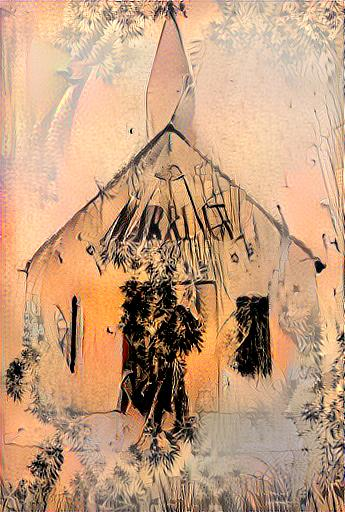

In [16]:
showarray(result_image/255)